### Environment setup

This project uses a reproducible Conda environment stored in  
`GassesPaper_environment.yml`.

Create and activate it with:

```bash
conda env create -f GassesPaper_environment.yml -n gasses-paper-env
conda activate gasses-paper-env

### Import Relevant Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import pickle
import sys
import openpyxl
import warnings
import itertools

from IPython.display import display, Markdown, Math, HTML
from scipy.linalg import cholesky
from scipy.optimize import curve_fit, minimize, root
from scipy.integrate import quad
from scipy.interpolate import CubicSpline, UnivariateSpline
from matplotlib.colors import to_hex, Normalize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D, proj3d
from pathlib import Path


# Path to repository root (folder where README.md lives)
REPO_ROOT = Path().resolve().parent

## Model Parameterization and Calibration

The parameterization used in this repository follows the scientific assessment of 
short-lived climate pollutants presented in 
[*Shindell et al., 2012*](https://www.annualreviews.org/content/journals/10.1146/annurev-earth-060313-054843).


In [33]:
##########################################
# Parameters (Pierrehumbert-style setup)
##########################################

# === Gas lifetimes (years) ===
# Atmospheric e-folding lifetimes for each gas
tau_CH4 = 12.4     # CH4 lifetime [years]
tau_N2O = 114.0    # N2O lifetime [years]
tau_SF6 = 3200.0   # SF6 lifetime [years]
tau_CO2 = 1e5      # Effective long tail for CO2 [years] (stylised, not a true single lifetime)


# === Radiative efficiencies (W/m^2 per ppb) ===
# Incremental radiative forcing per ppb increase in concentration.
a_CH4 = 3.7e-4     # CH4 radiative efficiency [W m^-2 ppb^-1]
a_N2O = 3.0e-3     # N2O radiative efficiency [W m^-2 ppb^-1]
a_SF6 = 0.52       # SF6 radiative efficiency [W m^-2 ppb^-1]
a_CO2 = 1.4e-5     # CO2 radiative efficiency [W m^-2 ppb^-1] (linearised; actual RF is log in CO2)


# === Molecular/atomic weights (g/mol) ===
# Used for converting between mass emissions and concentration changes.
moles_CH4 = 16.04  # Molecular weight of CH4 [g/mol]
moles_N2O = 44.0   # Molecular weight of N2O [g/mol]
moles_SF6 = 146.0  # Molecular weight of SF6 [g/mol]
moles_CO2 = 44.0   # Molecular weight of CO2 [g/mol]
moles_C   = 12.0   # Atomic weight of carbon [g/mol]


# === Two-box energy balance model parameters ===
# Simple climate model with a mixed layer and (optionally) a deep ocean box.

lamda = 1.2   # Climate feedback parameter λ [W m^-2 K^-1]
# gamma = 1.2          # (If used) ocean heat exchange parameter [W m^-2 K^-1]
# mu_mix = 10.0        # Example: mixed-layer heat capacity [J m^-2 K^-1]
# mu_deep = 200.0      # Example: deep-ocean heat capacity [J m^-2 K^-1]

# In your current implementation you are using:
mu_mix = 0.75          # Mixed-layer heat capacity (unit depends on your scaling; see 'adj' below)


# === Time step ===
dt_T = 1               # Time step for temperature/climate integration [years]


# === Scaling factor ===
adj = 1e9              # Generic scaling factor (e.g. to convert between kg and Gt)


--------------------------------------------------------------------------------


The data-source for aggregate **CO₂** emissions is [CO₂ Aggregate](https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2022).

The data-source for aggregate **CH₄** emissions is [CH₄ Aggregate](https://ourworldindata.org/grapher/methane-emissions).

CH4 CO2e column used: Annual methane emissions in CO₂ equivalents


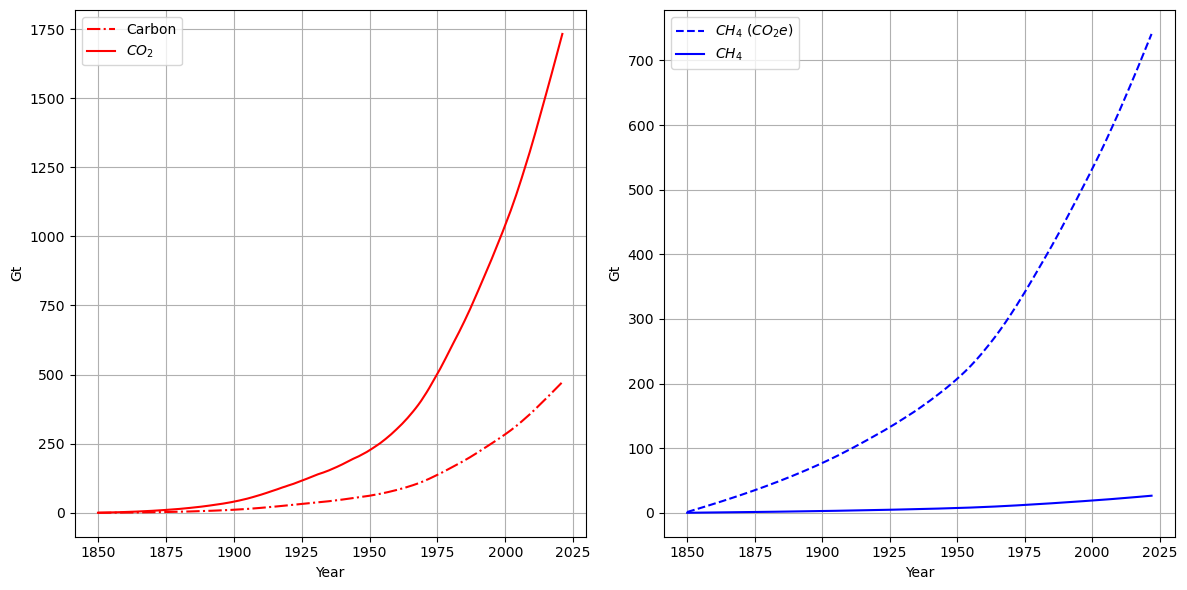

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Hence:


<IPython.core.display.Math object>

And hence for the unadjusted (CO₂e) case:


<IPython.core.display.Math object>

In [30]:
# -*- coding: utf-8 -*-
"""
Calibrate a bivariate Arithmetic Brownian Motion (ABM) to cumulative
CO₂ and CH₄ world-aggregate emissions.

- Annual timestep dt_T = 1.0 (annual data)
- Drift estimated as mean annual increments
- Diffusion estimated from covariance matrix of annual increments
- Sigma_MAT is the covariance of annual increments
- L_MAT is the instantaneous diffusion matrix with:
      L_MAT @ L_MAT.T = Sigma_MAT / dt_T
"""
######################################### Parameters #########################################
dt_T = 1.0  # annual time steps (the observations 1850, 1851, … are 1-yr apart)
GWP100_CH4 = 28  # CH4 GWP over 100y for CO2e → CH4 conversion

# Terminal width for pretty separators (nice in console / Jupyter)
try:
    columns = os.get_terminal_size().columns
except OSError:
    columns = 80

print("-" * columns)

######################################### Load CO2 Data #########################################

display(Markdown(
    "The data-source for aggregate **CO₂** emissions is "
    "[CO₂ Aggregate](https://www.icos-cp.eu/science-and-impact/global-carbon-budget/2022)."
))

file_path_CO2 = REPO_ROOT / "Data" / "National_Fossil_Carbon_Emissions_2022v1.0.xlsx"
sheet_name = "Territorial Emissions"

# Read and take cumulative sum for the world series
df_CO2 = pd.read_excel(file_path_CO2, sheet_name=sheet_name, index_col=0, skiprows=11)

# Carbon emissions for the world (as in original script)
df_CO2_World = df_CO2.filter(items=["World"]).cumsum()  # cumulative carbon; CO₂ conversion done later

######################################### Load CH4 Data #########################################

display(Markdown(
    "The data-source for aggregate **CH₄** emissions is "
    "[CH₄ Aggregate](https://ourworldindata.org/grapher/methane-emissions)."
))

file_path_CH4 = REPO_ROOT / "Data" / "methane-emissions.csv"

# Load OWID data; index by Year
df_CH4 = pd.read_csv(file_path_CH4)
df_CH4_World_raw = df_CH4[df_CH4["Entity"] == "World"].set_index("Year").copy()

# Keep only numeric columns to avoid string / object issues
numeric_cols = df_CH4_World_raw.select_dtypes(include=[np.number]).columns
if len(numeric_cols) == 0:
    raise ValueError("No numeric CH₄ emissions column found for 'World' in methane-emissions.csv.")
# Mimic original behaviour: use the 3rd column / last numeric col as CO2e
ch4_col = numeric_cols[-1]

# Cumulative CH4 in CO2e (keep as DataFrame to match original structure)
df_CH4_World = df_CH4_World_raw[[ch4_col]].cumsum()
column_Names_CH4 = ch4_col
print("CH4 CO2e column used:", column_Names_CH4)

# Convert CH4 given in CO₂e back to physical CH4 mass (same units as original, GWP100_CH4=28)
df_CH4_World["Original CH4"] = df_CH4_World[column_Names_CH4] / GWP100_CH4

######################################### Plot CO2 and CH4 #########################################

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Left: cumulative carbon vs CO₂ for the world
axes[0].plot(df_CO2_World / 1e3, label="Carbon", color="red", linestyle="-.")
axes[0].plot((df_CO2_World * 3.664) / 1e3, label="$CO_2$", color="red")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Gt")
axes[0].legend()
axes[0].grid()

# Right: cumulative CH4 (CO2e and physical CH4) in Gt
axes[1].plot(df_CH4_World[column_Names_CH4] / 1e9, label="$CH_4$ $(CO_2e)$", color="blue", linestyle="--")
axes[1].plot(df_CH4_World["Original CH4"] / 1e9, label="$CH_4$", color="blue")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Gt")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.savefig("CO2_and_CH4_Emissions_extra.png", bbox_inches="tight", dpi=300, facecolor="white")
plt.show()

######################################### Calibration #########################################

print("-" * columns)
display(Math(
    r"\text{Denoting sector }j=1\text{ as the }CO_2\text{ emitting sector and sector }j=2\text{ as the }CH_4\text{ emitting sector}"
))
display(Math(
    r"d\begin{bmatrix}E_1(t)\\E_2(t)\end{bmatrix} = "
    r"\begin{bmatrix}\mu^{1}\\\mu^{2}\end{bmatrix}dt + "
    r"\begin{bmatrix}\sigma_1 & \sigma_{12}\\\sigma_{21} & \sigma_2\end{bmatrix} "
    r"d\begin{bmatrix}W_1(t)\\W_2(t)\end{bmatrix}"
))

# ---------- Build time series in Gt per year ----------
# CO₂: convert cumulative carbon → cumulative CO₂ [Gt]
TimeSeries_CO2 = ((df_CO2_World["World"] * 3.664) / 1e3).astype("float")

# CH₄: physical CH₄ in Gt
TimeSeries_CH4 = (df_CH4_World["Original CH4"] / 1e9).astype("float")
TimeSeries_CH4_Unadjusted = (df_CH4_World[column_Names_CH4] / 1e9).astype("float")  # CH4 in CO2e, Gt

# Align both over 1850–2021
TimeSeries_VEC = np.column_stack((TimeSeries_CO2.loc[1850:2021],
                                  TimeSeries_CH4.loc[1850:2021]))
TimeSeries_VEC_Unadjusted = np.column_stack((TimeSeries_CO2.loc[1850:2021],
                                             TimeSeries_CH4_Unadjusted.loc[1850:2021]))

TimeSeries_df = pd.DataFrame(TimeSeries_VEC, columns=["CO2", "CH4"])
TimeSeries_df_Unadjusted = pd.DataFrame(TimeSeries_VEC_Unadjusted, columns=["CO2", "CH4"])

# ---------- Year-to-year increments ----------
increments = TimeSeries_df.diff().dropna()
increments_Unadjusted = TimeSeries_df_Unadjusted.diff().dropna()

# ---------- Mean of the increments (μ * dt_T) ----------
mu_VEC = increments.mean()                  # mean annual increment (Gt/year)
mu_VEC_Unadjusted = increments_Unadjusted.mean()

# ---------- Covariance of increments (Σ * dt_T) ----------
adjusted_increments = increments - mu_VEC
adjusted_increments_Unadjusted = increments_Unadjusted - mu_VEC_Unadjusted

Sigma_MAT = np.cov(adjusted_increments.values, rowvar=False)
Sigma_MAT_Unadjusted = np.cov(adjusted_increments_Unadjusted.values, rowvar=False)

# ---------- Instantaneous Σ  =  Σ_step / dt_T ----------
Sigma_inst = Sigma_MAT / dt_T
Sigma_inst_Unadjusted = Sigma_MAT_Unadjusted / dt_T

# ---------- Cholesky gives σ with σ σᵀ = Σ ----------
L_MAT = cholesky(Sigma_inst, lower=True)                 # σ (Gt/√year)
L_MAT_Unadjusted = cholesky(Sigma_inst_Unadjusted, lower=True)

# ---------- Display parameters per **year** ----------
mu_VEC_display = mu_VEC / dt_T                  # instantaneous drift (here dt_T = 1 so unchanged)
mu_VEC_Unadjusted_display = mu_VEC_Unadjusted / dt_T

mu_CO2  = mu_VEC_display["CO2"]
mu_CH4  = mu_VEC_display["CH4"]
mu_CO2_Unadjusted = mu_VEC_Unadjusted_display["CO2"]
mu_CH4_Unadjusted = mu_VEC_Unadjusted_display["CH4"]

sigma_CO2  = L_MAT[0, 0]
sigma_CH4  = L_MAT[1, 1]
sigma_CO2_Unadjusted = L_MAT_Unadjusted[0, 0]
sigma_CH4_Unadjusted = L_MAT_Unadjusted[1, 1]

print("Hence:")
display(Math(
    f"d\\begin{{bmatrix}}E_1(t)\\\\E_2(t)\\end{{bmatrix}} = "
    f"\\begin{{bmatrix}}{mu_CO2:.4f}\\\\{mu_CH4:.4f}\\end{{bmatrix}} dt + "
    f"\\begin{{bmatrix}}{sigma_CO2:.4f} & {L_MAT[0, 1]:.4f}\\\\"
    f"{L_MAT[1, 0]:.4f} & {sigma_CH4:.4f}\\end{{bmatrix}} "
    f"d\\begin{{bmatrix}}W_1(t)\\\\W_2(t)\\end{{bmatrix}}"
))

print("And hence for the unadjusted (CO₂e) case:")
display(Math(
    f"d\\begin{{bmatrix}}E_1(t)\\\\E_2(t)\\end{{bmatrix}} = "
    f"\\begin{{bmatrix}}{mu_CO2_Unadjusted:.4f}\\\\{mu_CH4_Unadjusted:.4f}\\end{{bmatrix}} dt + "
    f"\\begin{{bmatrix}}{sigma_CO2_Unadjusted:.4f} & {L_MAT_Unadjusted[0, 1]:.4f}\\\\"
    f"{L_MAT_Unadjusted[1, 0]:.4f} & {sigma_CH4_Unadjusted:.4f}\\end{{bmatrix}} "
    f"d\\begin{{bmatrix}}W_1(t)\\\\W_2(t)\\end{{bmatrix}}"
))


--------------------------------------------------------------------------------


Reference for the following CO₂ and CH₄ MAC curves: [ScienceDirect](https://www.sciencedirect.com/science/article/pii/S1462901115000623)

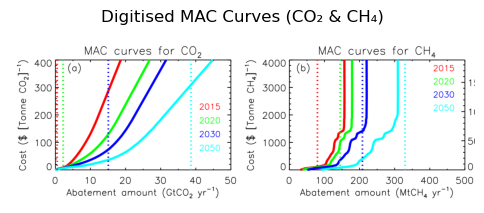

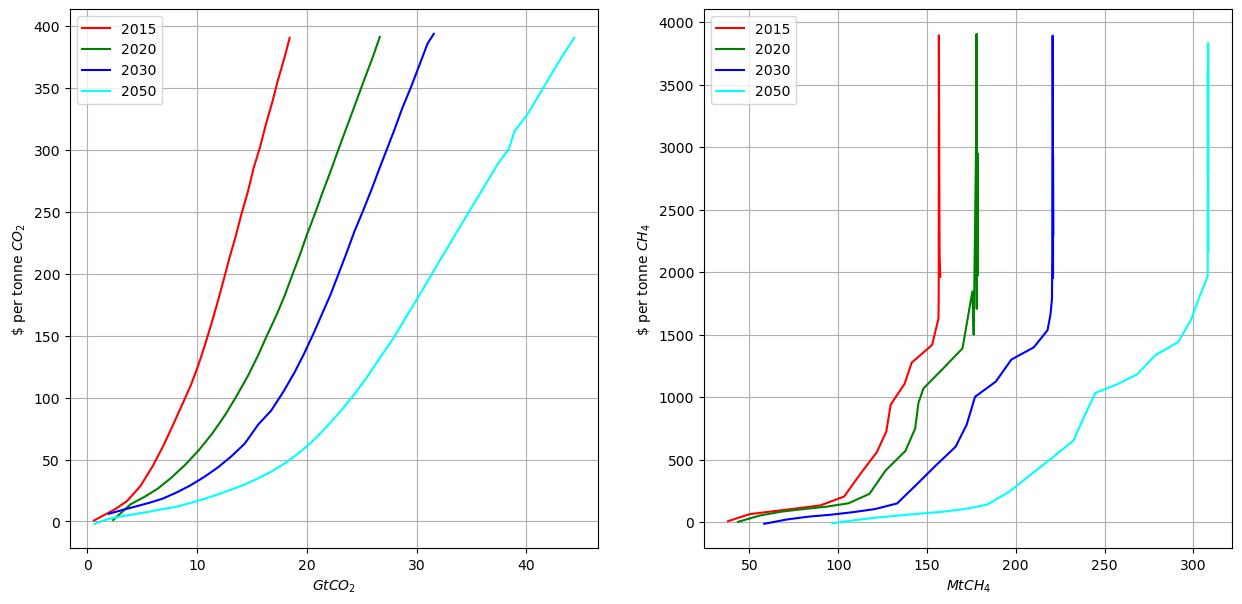

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

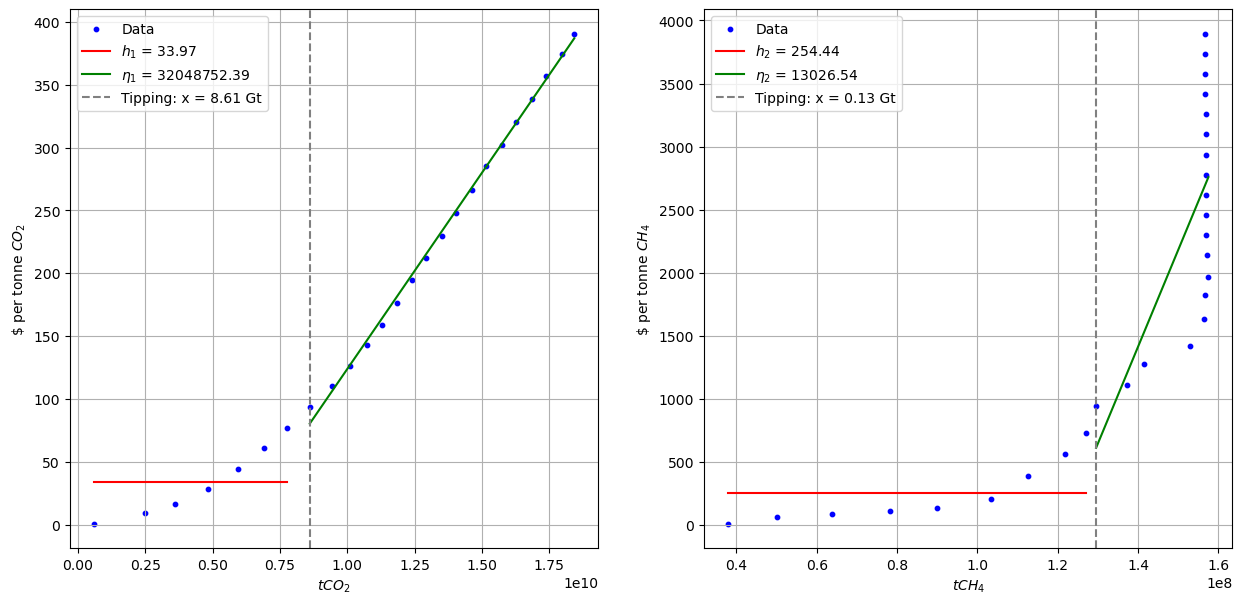

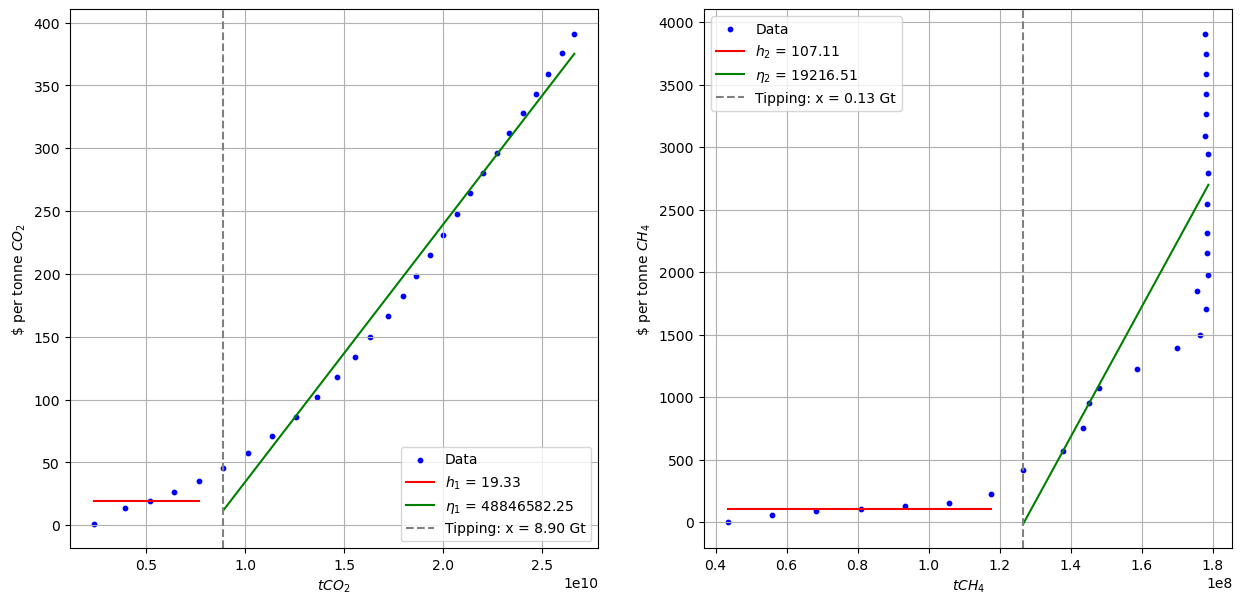

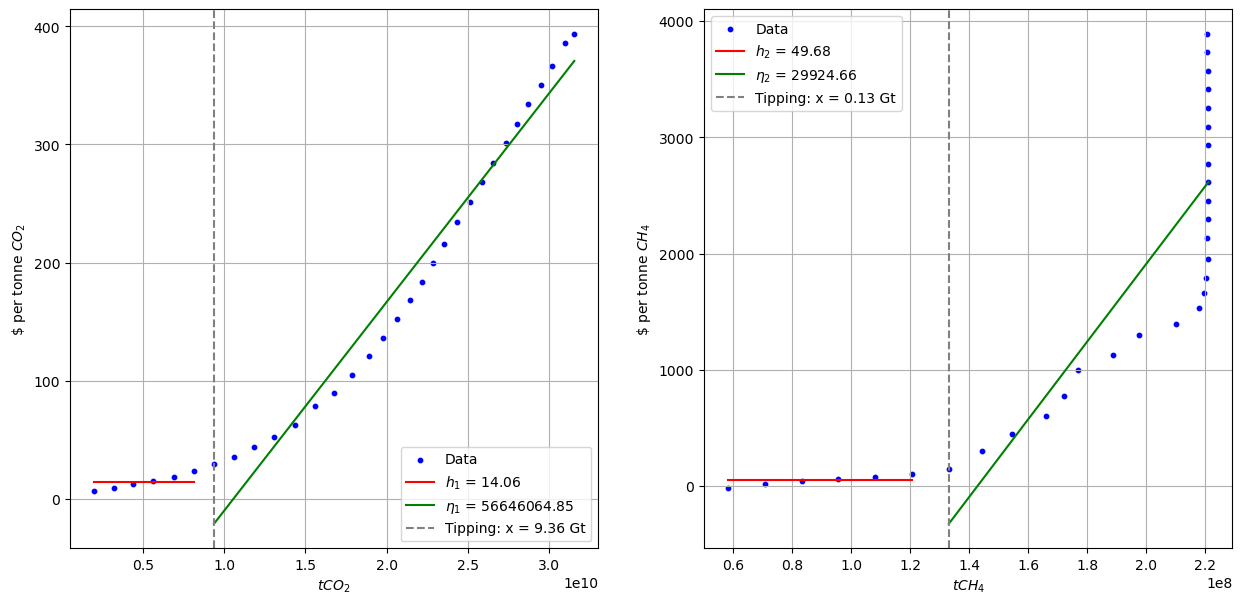

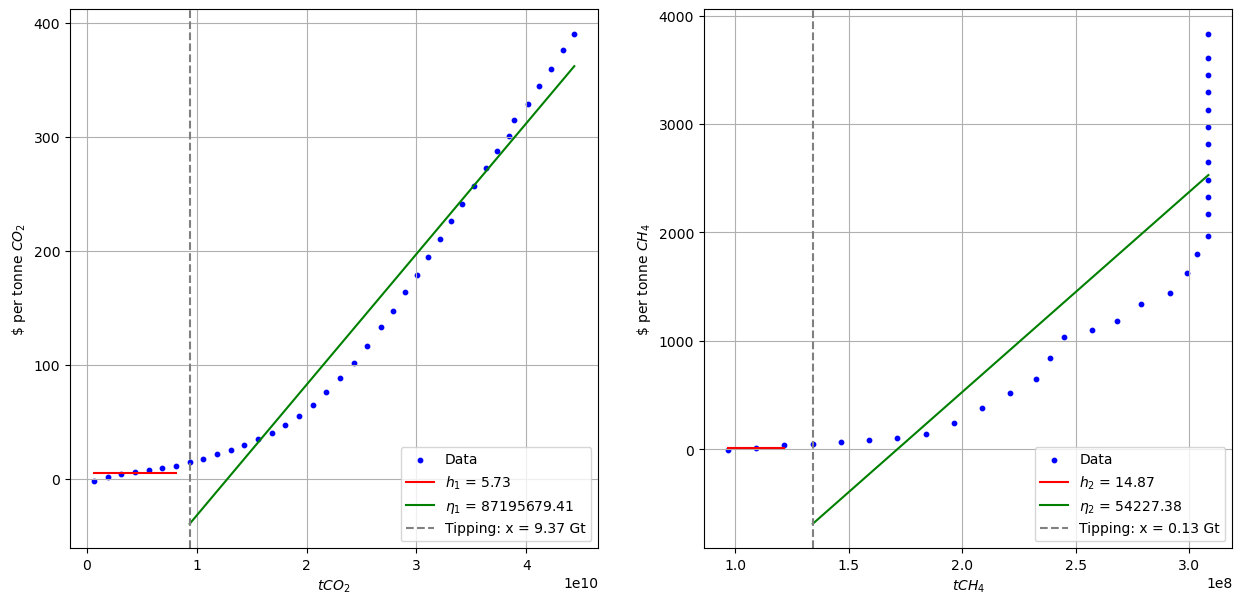

eta_CO2 values for each year: [32048752.387168795, 48846582.25374373, 56646064.852476634, 87195679.40660168]
eta_CH4 values for each year: [13026.53984642491, 19216.50848514621, 29924.65933669733, 54227.3814377266]
h_CO2 values for each year: [33.974920813351666, 19.327257805388808, 14.055220918491736, 5.72954582759259]
h_CH4 values for each year: [254.44314642410214, 107.11309449253713, 49.67698478307435, 14.866215196883784]


In [31]:
#################################### Cost function parameters (projection) ####################################


# Reference for the following CO2 and CH4 MAC curves:
print("-" * columns)
display(Markdown(
    "Reference for the following CO₂ and CH₄ MAC curves: "
    "[ScienceDirect](https://www.sciencedirect.com/science/article/pii/S1462901115000623)"
))

manual_tipping = "yes"  # "yes" = use manually chosen tipping points; "no" = use curvature-based ones

# -----------------------------------------------------------------------------------
# Manually chosen tipping points (where MAC curve becomes steep / high curvature)
# -----------------------------------------------------------------------------------

# You can change these if you like, but the scaling below now matches your original script.
tipps_CO2 = [0.9, 0.9, 0.9, 0.9]
tipps_CH4 = [1.3, 1.3, 1.3, 1.3]

tipps_CO2_scaled = [value * 1e10 for value in tipps_CO2]
tipps_CH4_scaled = [value * 1e8  for value in tipps_CH4]

# -----------------------------------------------------------------------------------
# Display the digitised MAC curves image (for visual reference)
# -----------------------------------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.imshow(plt.imread(REPO_ROOT / "Data" / "MACCurves.png"))
plt.title('Digitised MAC Curves (CO₂ & CH₄)')
plt.axis('off')
plt.show()

# -----------------------------------------------------------------------------------
# Load digitised MAC curves from CSVs
# -----------------------------------------------------------------------------------
columns_CO2 = [r'$GtCO_2$', r'\$ Tonne $CO_2$']
columns_CH4 = [r'$MtCH_4$', r'\$ Tonne $CH_4$']

Years_MAC = ['2015', '2020', '2030', '2050']
colors_MAC = ['red', 'green', 'blue', 'cyan']

CO2_MAC = []
CH4_MAC = []

# Read the digitised CSVs (x = quantity, y = $/tonne)
for year in Years_MAC:
    CO2_MAC.append(pd.read_csv(REPO_ROOT / "Data" / f"{year}_CO2.csv", names=columns_CO2))
    CH4_MAC.append(pd.read_csv(REPO_ROOT / "Data" / f"{year}_CH4.csv", names=columns_CH4))

# -----------------------------------------------------------------------------------
# Sort MAC data by quantity, preserving (x, y) pairs
# -----------------------------------------------------------------------------------
CO2_MAC_Sorted, CH4_MAC_Sorted = [], []

for i in range(len(CO2_MAC)):
    df_CO2 = CO2_MAC[i].sort_values(r'$GtCO_2$').reset_index(drop=True)
    CO2_MAC_Sorted.append(df_CO2)
    
    df_CH4 = CH4_MAC[i].sort_values(r'$MtCH_4$').reset_index(drop=True)
    CH4_MAC_Sorted.append(df_CH4)

# -----------------------------------------------------------------------------------
# Plot raw digitised MAC curves (in original units)
# -----------------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

for i, year in enumerate(Years_MAC):
    axes[0].plot(
        CO2_MAC_Sorted[i][r'$GtCO_2$'],
        CO2_MAC_Sorted[i][r'\$ Tonne $CO_2$'],
        color=colors_MAC[i], label=year
    )
    axes[1].plot(
        CH4_MAC_Sorted[i][r'$MtCH_4$'],
        CH4_MAC_Sorted[i][r'\$ Tonne $CH_4$'],
        color=colors_MAC[i], label=year
    )

axes[0].set_xlabel(r'$GtCO_2$')
axes[0].set_ylabel(r'\$ per tonne $CO_2$')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel(r'$MtCH_4$')
axes[1].set_ylabel(r'\$ per tonne $CH_4$')
axes[1].legend()
axes[1].grid(True)

plt.savefig('Digitized_curvefit.png', bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

print("-" * columns)

# -----------------------------------------------------------------------------------
# Prepare data for fitting MAC → (h_j, eta_j)
#
# For each year, we work in tonnes on the x-axis:
#   CO2:  GtCO2 * 1e9 = tCO2
#   CH4:  MtCH4 * 1e6 = tCH4
# -----------------------------------------------------------------------------------
x_data_CO2, y_data_CO2 = [], []
x_data_CH4, y_data_CH4 = [], []

for i in range(len(CO2_MAC_Sorted)):
    x_data_CO2.append(CO2_MAC_Sorted[i][r'$GtCO_2$'].values * 1e9)   # Gt → t
    y_data_CO2.append(CO2_MAC_Sorted[i][r'\$ Tonne $CO_2$'].values)  # $/t CO2
    
for i in range(len(CH4_MAC_Sorted)):
    x_data_CH4.append(CH4_MAC_Sorted[i][r'$MtCH_4$'].values * 1e6)   # Mt → t
    y_data_CH4.append(CH4_MAC_Sorted[i][r'\$ Tonne $CH_4$'].values)  # $/t CH4

# -----------------------------------------------------------------------------------
# Display the quadratic cost and MAC structure in LaTeX
# -----------------------------------------------------------------------------------
display(Math(r"\text{We assume quadratic abatement cost functions:}"))
display(Math(r"K_{ij}(t) = h_{ij} a_{ij}(t) + \frac{1}{2\eta_{ij}}\big(a_{ij}(t)\big)^2"))
display(Math(r"\text{Hence the MAC (marginal abatement cost) is:}"))
display(Math(r"\frac{\partial K_{ij}(t)}{\partial a_{ij}(t)} = h_{ij} + \frac{1}{\eta_{ij}} a_{ij}(t)"))

display(Math(
    r"\text{To obtain } h_j\text{ we fit a horizontal line } h_j = c "
    r"\text{ to the MAC curve up to the tipping point (low curvature region).}"
))
display(Math(
    r"\text{To obtain } \eta_j\text{ we fit the straight line } "
    r"h_j + \frac{1}{\eta_j} a_j(t) \text{ on the high-curvature region beyond the tipping point.}"
))

# -----------------------------------------------------------------------------------
# Helper functions for tipping point and linear fitting
# -----------------------------------------------------------------------------------
def find_closest_index(array, value):
    """Return index of the element in array closest to value."""
    array = np.asarray(array)
    return np.abs(array - value).argmin()

def linear_model(x, a, b):
    """Simple linear model a*x + b used for MAC slope fitting."""
    return a * x + b

eta_CO2, eta_CH4 = [], []
h_CO2,   h_CH4   = [], []

# -----------------------------------------------------------------------------------
# Loop over years and estimate h_j and eta_j
# -----------------------------------------------------------------------------------
for i in range(len(CO2_MAC_Sorted)):
    x_co2 = x_data_CO2[i]
    y_co2 = y_data_CO2[i]
    x_ch4 = x_data_CH4[i]
    y_ch4 = y_data_CH4[i]

    # --- Approximate MAC curvature via numerical gradients ---
    gradient_CO2 = np.gradient(y_co2, x_co2)
    gradient_CH4 = np.gradient(y_ch4, x_ch4)
    
    second_derivative_CO2 = np.gradient(gradient_CO2, x_co2)
    second_derivative_CH4 = np.gradient(gradient_CH4, x_ch4)
    
    # Curvature thresholds for "tipping"
    threshold_CO2 = np.percentile(second_derivative_CO2, 90)
    threshold_CH4 = np.percentile(second_derivative_CH4, 70)
    
    # --- Choose tipping point: automatic or manual ---
    if manual_tipping.lower() == "no":
        # First index where curvature exceeds threshold
        significant_increase_index_CO2 = np.argmax(second_derivative_CO2 > threshold_CO2)
        significant_increase_index_CH4 = np.argmax(second_derivative_CH4 > threshold_CH4)
    else:  # "yes"
        significant_increase_index_CO2 = find_closest_index(x_co2, tipps_CO2_scaled[i])
        significant_increase_index_CH4 = find_closest_index(x_ch4, tipps_CH4_scaled[i])

    # ---------------- SAFETY CLAMPS ----------------
    # We need at least:
    #   - 1 point in the "left" segment for h (mean)
    #   - 2 points in the "right" segment for eta (line fit)
    n_co2 = len(x_co2)
    n_ch4 = len(x_ch4)

    # clamp CO2 tipping index into [1, n_co2-2]
    if n_co2 < 3:
        raise ValueError(f"Not enough CO2 points in MAC curve for year index {i} to split.")
    significant_increase_index_CO2 = max(1, min(significant_increase_index_CO2, n_co2 - 2))

    # clamp CH4 tipping index into [1, n_ch4-2]
    if n_ch4 < 3:
        raise ValueError(f"Not enough CH4 points in MAC curve for year index {i} to split.")
    significant_increase_index_CH4 = max(1, min(significant_increase_index_CH4, n_ch4 - 2))
    # ------------------------------------------------

    significant_increase_point_CO2 = x_co2[significant_increase_index_CO2]
    significant_increase_point_CH4 = x_ch4[significant_increase_index_CH4]
    
    # --- Fit horizontal line (h) on low-curvature segment ---
    x1_CO2 = x_co2[:significant_increase_index_CO2]
    y1_CO2 = y_co2[:significant_increase_index_CO2]
    mean_y1_CO2 = np.mean(y1_CO2)    # h_1 estimate
    line1_CO2 = np.full_like(x1_CO2, mean_y1_CO2)
    
    x1_CH4 = x_ch4[:significant_increase_index_CH4]
    y1_CH4 = y_ch4[:significant_increase_index_CH4]
    mean_y1_CH4 = np.mean(y1_CH4)    # h_2 estimate
    line1_CH4 = np.full_like(x1_CH4, mean_y1_CH4)
    
    # --- Fit linear MAC segment to estimate slope → eta ---
    x2_CO2 = x_co2[significant_increase_index_CO2:]
    y2_CO2 = y_co2[significant_increase_index_CO2:]
    x2_CH4 = x_ch4[significant_increase_index_CH4:]
    y2_CH4 = y_ch4[significant_increase_index_CH4:]

    # extra safety: if we somehow still have < 2 points, skip / raise
    if len(x2_CO2) < 2 or len(x2_CH4) < 2:
        raise ValueError(f"Not enough points in right-hand segment after tipping for year index {i}.")

    params_CO2, _ = curve_fit(linear_model, x2_CO2, y2_CO2)
    line2_CO2 = linear_model(x2_CO2, *params_CO2)
    
    params_CH4, _ = curve_fit(linear_model, x2_CH4, y2_CH4)
    line2_CH4 = linear_model(x2_CH4, *params_CH4)
    
    # --------------------------------------------------------------------------------
    # Plot the MAC data and piecewise fits (h and eta) for visual inspection
    # --------------------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    # CO2
    axes[0].scatter(x_co2, y_co2, label='Data', color='blue', s=10)
    axes[0].plot(x1_CO2, line1_CO2, label=f'$h_1$ = {mean_y1_CO2:.2f}', color='red')
    axes[0].plot(x2_CO2, line2_CO2, label=f'$\\eta_1$ = {1/params_CO2[0]:.2f}', color='green')
    axes[0].axvline(
        x=significant_increase_point_CO2,
        color='gray', linestyle='--',
        label=f'Tipping: x = {significant_increase_point_CO2 / adj:.2f} Gt'
    )
    axes[0].set_xlabel(r'$tCO_2$')
    axes[0].set_ylabel(r'\$ per tonne $CO_2$')
    axes[0].legend()
    axes[0].grid(True)
    
    # CH4
    axes[1].scatter(x_ch4, y_ch4, label='Data', color='blue', s=10)
    axes[1].plot(x1_CH4, line1_CH4, label=f'$h_2$ = {mean_y1_CH4:.2f}', color='red')
    axes[1].plot(x2_CH4, line2_CH4, label=f'$\\eta_2$ = {1/params_CH4[0]:.2f}', color='green')
    axes[1].axvline(
        x=significant_increase_point_CH4,
        color='gray', linestyle='--',
        label=f'Tipping: x = {significant_increase_point_CH4 / adj:.2f} Gt'
    )
    axes[1].set_xlabel(r'$tCH_4$')
    axes[1].set_ylabel(r'\$ per tonne $CH_4$')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.savefig(f'Digitized_curvefit_equation_{i}.png',
                bbox_inches='tight', dpi=300, facecolor='white')
    plt.show()

    # --- Extract fitted parameters for this year ---
    a_t_CO2, b_CO2 = params_CO2
    a_t_CH4, b_CH4 = params_CH4

    # eta from MAC slope: MAC = h + (1/eta)*a ⇒ slope = 1/eta
    eta_CO2.append(1 / a_t_CO2)
    eta_CH4.append(1 / a_t_CH4)
    
    # h from low-curvature horizontal fit
    h_CO2.append(mean_y1_CO2)
    h_CH4.append(mean_y1_CH4)

# -----------------------------------------------------------------------------------
# Print calibrated parameters across years
# -----------------------------------------------------------------------------------
print("eta_CO2 values for each year:", eta_CO2)
print("eta_CH4 values for each year:", eta_CH4)
print("h_CO2 values for each year:", h_CO2)
print("h_CH4 values for each year:", h_CH4)


In [46]:
############################################   Parameters (All)   #############################################


# === Horizon & sizes ===
print("-" * columns)
display(Math(r"\text{Firms' horizon }T,\quad\text{Regulator's horizon }\widetilde{T},\quad\text{Number of sectors }K,\quad\text{Number of firms in each sector }N_j:"))

# T: firm horizon, T_tilde: regulator horizons (can be a list of scenarios)
T       = 26
T_tilde = [26, 100, 250, 500]
K       = 2      # number of sectors
N       = 1      # number of firms per sector (in this implementation)

if not isinstance(T_tilde, list):
    # Single regulator horizon
    display(Math(f"""
    \\begin{{align}}
    T &= {T}\\\\
    \\widetilde{{T}} &= {T_tilde}\\\\
    K &= {K}\\\\
    N_j &= N = {N}\\quad\\forall j
    \\end{{align}}
    """))
else:
    # Multiple regulator horizons – display as cases
    T_tilde_cases = '\\\\ '.join([str(x) for x in T_tilde])
    display(Math(f"""
    \\begin{{align}}
    T &= {T}\\\\
    \\widetilde{{T}} &=
    \\begin{{cases}}
    {T_tilde_cases}\\\\
    \\end{{cases}}\\\\
    K &= {K}\\\\
    N_j &= N = {N}\\quad\\forall j
    \\end{{align}}
    """))


# === Means and standard deviations of emissions ===
print("-" * columns)
display(Math(f"\\text{{The mean and standard deviation of Emissions trajectories are }}\\bar{{\\mu}}^j\\text{{ and }}\\bar{{\\sigma}}^j:"))

mu_1 = mu_CO2
mu_2 = mu_CH4
mu   = {"0": mu_1, "1": mu_2}

mu_1_Unadjusted = mu_CO2_Unadjusted
mu_2_Unadjusted = mu_CH4_Unadjusted
mu_Unadjusted   = {"0": mu_1_Unadjusted, "1": mu_2_Unadjusted}

std_1     = sigma_CO2
std_2     = sigma_CH4
std       = {"0": std_1, "1": std_2}

std_1_Unadjusted = sigma_CO2_Unadjusted
std_2_Unadjusted = sigma_CH4_Unadjusted
std_Unadjusted   = {"0": std_1_Unadjusted, "1": std_2_Unadjusted}

std_sci_1 = np.round(std_1, 4) 
std_sci_2 = std_2 

display(Math(
    f"\\bar{{\\mu}}^1 = {np.round(mu_1, 4)}\\text{{ and }}\\bar{{\\sigma}}^1 = {np.round(std_1, 4)}\\text{{ for sector 1.}}"
    "\\\\ "
    f"\\bar{{\\mu}}^2 = {np.round(mu_2, 4)}\\text{{ and }}\\bar{{\\sigma}}^2 = {np.round(std_2, 2)}\\text{{ for sector 2.}}"
))


# === Cost constraint parameters \bar h^j ===
print("-" * columns)
display(Math(f"\\text{{The cost constraint for each sector }}{{j}}\\text{{ is }}\\bar{{h}}^j:"))

# Here you use four values per sector (e.g. combinations to be paired with eta)
h_1 = [h_CO2[0], h_CO2[1], h_CO2[2], h_CO2[3]]
h_2 = [h_CH4[0], h_CH4[1], h_CH4[2], h_CH4[3]]

h = {"0" : h_1, "1" : h_2}

def create_cases(h):
    """Format a scalar or list as a LaTeX cases expression."""
    if isinstance(h, list):
        return "\\begin{cases} " + " \\\\ ".join(f"{x}" for x in h) + " \\end{cases}"
    else:
        return h

h_1_latex = create_cases(h_1)
h_2_latex = create_cases(h_2)

latex_code = f"""
\\begin{{align}}
\\bar{{h}}^1 &= {h_1_latex}\\quad £/ton \\\\
\\bar{{h}}^2 &= {h_2_latex}\\quad £/ton
\\end{{align}}
"""
display(Math(latex_code))


# === Flexibility parameters \eta^{ij} ===
print("-" * columns)
display(Math(f"\\text{{The flexibility parameter }}\\eta^{{ij}}\\text{{ is}}:"))

def format_sci(number):
    """Write scalar or list in scientific notation for LaTeX."""
    if not isinstance(number, list):
        exponent = int(np.floor(np.log10(abs(number))))
        mantissa = number / (10**exponent)
        return f"{mantissa:.3f} \\times 10^{{{exponent}}}"
    else:
        strings = []
        for num in number:
            exponent = int(np.floor(np.log10(abs(num))))
            mantissa = num / (10**exponent)
            strings.append(f"{mantissa:.3f} \\times 10^{{{exponent}}}")
        return strings

eta_1     = [eta_CO2[0], eta_CO2[1], eta_CO2[2], eta_CO2[3]] 
eta_sci_1 = format_sci(eta_1)

eta_2     = [eta_CH4[0], eta_CH4[1], eta_CH4[2], eta_CH4[3]]
eta_sci_2 = format_sci(eta_2)

eta = {"0" : eta_1, "1" : eta_2}

def create_cases(eta):
    """Format eta values as LaTeX cases."""
    if isinstance(eta, list):
        return "\\begin{cases} " + " \\\\ ".join(f"{x}" for x in eta) + " \\end{cases}"
    else:
        return str(eta)

eta_sci_1_latex = create_cases(eta_sci_1)
eta_sci_2_latex = create_cases(eta_sci_2)

latex_code = f"""
\\begin{{align}}
\\eta^{{i1}} &= {eta_sci_1_latex}\\quad \\text{{ton}}^2/(£\\quad \\text{{yr}}) \\\\
\\eta^{{i2}} &= {eta_sci_2_latex}\\quad \\text{{ton}}^2/(£\\quad \\text{{yr}})
\\end{{align}}
"""
display(Math(latex_code))

print("We further know that:")
display(Math(f"\\bar{{c}}^j=\\sum_{{i=1}}^{{n_j}}\\frac{{\\eta^{{ij}}h^{{ij}}}}{{n_j}}."))
print("and")
display(Math(f"\\bar{{\\nu}}^j=\\sum_{{i=1}}^{{n_j}}\\frac{{\\eta^{{ij}}(h^{{ij}})^2}}{{n_j}}."))

print(r"Hence assuming:")
display(Math(
    f"\\eta^{{i1}}=\\bar{{\\eta}}^{{1}}\\quad\\text{{ and }}\\quad h^{{i1}}=\\bar{{h}}^{{1}}\\quad\\text{{ and }}\\quad N_1=N=1"
    "\\\\ "
    f"\\eta^{{i2}}=\\bar{{\\eta}}^{{2}}\\quad\\text{{ and }}\\quad h^{{i2}}=\\bar{{h}}^{{2}}\\quad\\text{{ and }}\\quad N_2=N=1"
))


# === Functions for \bar c^j and \bar ν^j ===
def c_fun(h, eta, combs = False):
    """
    Compute c = η h.  If combs=True, return all pairwise products (h,η) cartesian product.
    """
    if isinstance(h, list) and isinstance(eta, list) and combs == True:
        heta = []
        combinations = list(itertools.product(h, eta))
        for x in combinations:
            heta.append(x[0] * x[1])
        return heta, combinations
    
    elif isinstance(h, list) and isinstance(eta, list) and combs == False:
        heta = []
        for i in range(len(h)):
            heta.append(h[i] * eta[i])
        return heta
    else:
        return h * eta
    
def nu_fun(h, eta, combs = False):
    """
    Compute ν = η h^2, same combinatorial logic as c_fun.
    """
    if isinstance(h, list) and isinstance(eta, list) and combs == True:
        heta = []
        combinations = list(itertools.product(h, eta))
        for x in combinations:
            heta.append(x[0]**2 * x[1])
        return heta, combinations
    
    elif isinstance(h, list) and isinstance(eta, list) and combs == False:
        heta = []
        for i in range(len(h)):        
            heta.append(h[i] ** 2 * eta[i])
        return heta
    else:
        return h ** 2 * eta
    

# === Sector-level c and ν for your eta/h grids ===
if isinstance(h_1, list) and isinstance(eta_1, list):
    c_1 = c_fun(h = h_1, eta = eta_1, combs = False)
else:
    c_1 = c_fun(h = h_1, eta = eta_1, combs = False)
c_sci_1 = format_sci(c_1)

if isinstance(h_1, list) and isinstance(eta_1, list):
    c_2 = c_fun(h = h_2, eta = eta_2, combs = False)
else:
    c_2 = c_fun(h = h_2, eta = eta_2)
c_sci_2 = format_sci(c_2)

c = {"0" : c_1, "1" : c_2}

if isinstance(h_1, list) and isinstance(eta_1, list):
    nu_1 = nu_fun(h = h_1, eta = eta_1, combs = False)
else:
    nu_1 = nu_fun(h = h_1, eta = eta_1)
nu_sci_1 = format_sci(nu_1)

if isinstance(h_1, list) and isinstance(eta_1, list):
    nu_2 = nu_fun(h = h_2, eta = eta_2, combs = False)
else:
    nu_2 = nu_fun(h = h_2, eta = eta_2)
nu_sci_2 = format_sci(nu_2)

nu = {"0" : nu_1, "1" : nu_2}

# If combinations_c1/c2 already exist (from earlier cartesian products), reuse them
if isinstance(h_1, list) and isinstance(eta_1, list) and 'combinations_c1' in globals():
    combinations = {"0" : combinations_c1, "1" : combinations_c2}

# === c_sq and combinations_sq (pairwise combinations of (h,η)) ===
if isinstance(h_1, list) and isinstance(eta_1, list) and 'combinations_c1' in globals():
    c_sq = {}
    for key in combinations.keys():
        c_sq[key] = list(itertools.product(c[key], c[key]))

    c_1_sq     = [tup[0] for tup in c_sq["0"]]
    c_2_sq     = [tup[0] for tup in c_sq["1"]]

    c_sci_1_sq = format_sci(c_1_sq)
    c_sci_2_sq = format_sci(c_2_sq)

    c_sq ={"0" : c_1_sq, "1" : c_2_sq}

delta_1, delta_2 = 0.25, 0.25
delta = {"0" : delta_1, "1" : delta_2}

# === squaring combinations if combinations_sq already built ===
if isinstance(nu_1, list) and isinstance(c_1, list) and 'combinations_sq' in globals():
    
    combinations_1_sq = [tup[0] for tup in combinations_sq["0"]]
    combinations_2_sq = [tup[0] for tup in combinations_sq["1"]]

    combinations_sq = {"0" : combinations_1_sq, "1" : combinations_2_sq}

    # Combinations table
    print("-" * columns)
    print("We have the combinations:")

    hEtaCart = pd.DataFrame(combinations["0"], columns=["h", "\\eta "])

    latex_code = hEtaCart.to_latex(index=False, escape=False, column_format="cc")
    latex_code = latex_code.replace("\\begin{tabular}{cc}", "\\begin{matrix}")
    latex_code = latex_code.replace("\\end{tabular}", "\\end{matrix}")
    latex_code = latex_code.replace("\\toprule", "").replace("\\midrule", "").replace("\\bottomrule", "")

    html_code = f"""
    <div style="display: flex; justify-content: center;">
      <div>{Math(latex_code).data}</div>
    </div>
    """
    display(HTML(html_code))

    print("and more importantly the combinations:")

    combinations_sq = {}
    for key in combinations.keys():
        combinations_sq[key] = list(itertools.product(combinations[key], combinations[key]))

    hEtaCart_sq = pd.DataFrame(combinations_sq["0"], columns=["(h_1, eta_1)", "(h_2, eta_2)"])

    latex_code = hEtaCart_sq.to_latex(index=False, escape=False, column_format="cc")
    latex_code = latex_code.replace("\\begin{tabular}{cc}", "\\begin{matrix}")
    latex_code = latex_code.replace("\\end{tabular}", "\\end{matrix}")
    latex_code = latex_code.replace("\\toprule", "").replace("\\midrule", "").replace("\\bottomrule", "")
    latex_code = latex_code.replace("eta_1", " \\eta_1").replace("eta_2", " \\eta_2")

    html_code = f"""
    <div style="display: flex; justify-content: center;">
      <div>{Math(latex_code).data}</div>
    </div>
    """
    display(HTML(html_code))


# === Average allocation constraints \bar b^j ===
print("-" * columns)
print("The average allocation to sector j, and henceforth the sector total allocation verifies:")

display(Math(f'\\bar{{b}}^j\\in[0,(1-\\delta_j)(\\bar{{\\mu}}^j+\\bar{{c}}^j)T]\\quad\\text{{ for some }}\\delta_j\\in(0,1)'))

print("or:")

def create_latex(mu, c_sci, sector, combinations, T, delta):
    """Build LaTeX for the admissible range of \bar b^j for given (h,η) combos."""
    latex_string = ""
    if isinstance(h_1, list) and isinstance(eta_1, list):
        for i in range(len(combinations)):
            latex_string += (f"\\bar{{b}}^{sector}\\in [0,(1-{delta})({np.round(mu, 3)}\\times 10^9 + {c_sci[i]}){T}]\\quad"
                             f"\\text{{for}}\\quad\\bar{{\\eta}}^{sector} = {format_sci(combinations[i][1])}\\quad"
                             f"\\text{{and}}\\quad\\bar{{h}}^{sector} = {combinations[i][0]}\\\\")
    else:
        latex_string += (f"\\bar{{b}}^{sector}\\in [0,(1-{delta})({np.round(mu, 3)}\\times 10^9 + {c_sci}){T}]\\quad"
                 f"\\text{{for}}\\quad\\bar{{\\eta}}^{sector} = {format_sci(combinations[1])}\\quad"
                 f"\\text{{and}}\\quad\\bar{{h}}^{sector} = {combinations[0]}\\\\")
    return latex_string

# Sector 1
display(Math(r"\text{For sector 1:}"))

if isinstance(h_1, list) and isinstance(eta_1, list) and 'combinations_1_sq' in globals():
    latex_output_1 = create_latex(mu = mu_1, c_sci = c_sci_1_sq, sector = 1, combinations = combinations_1_sq, T = T, delta = delta_1)
    display(Math(latex_output_1))
else:   
    combinations_1 = list(zip(h_1, eta_1))
    latex_output_1 = create_latex(mu = mu_1, c_sci = c_sci_1, sector = 1, combinations = combinations_1, T = T, delta = delta_1)
    display(Math(latex_output_1))

# Sector 2
display(Math(r"\text{For sector 2:}"))

if isinstance(h_1, list) and isinstance(eta_1, list) and 'combinations_2_sq' in globals():
    latex_output_2 = create_latex(mu = mu_2, c_sci = c_sci_2_sq, sector = 2, combinations = combinations_2_sq, T = T, delta = delta_2)
    display(Math(latex_output_2))
else:
    combinations_2 = list(zip(h_2, eta_2))
    latex_output_2 = create_latex(mu = mu_2, c_sci = c_sci_2, sector = 2, combinations = combinations_2, T = T, delta = delta_2)
    display(Math(latex_output_2))


def Alloc(mu, adj, c, T, delta):
    """
    Compute admissible average allocations b (upper bound) and bMin (here 0),
    using \bar b^j ∈ [0,(1−δ_j)(\bar μ^j + \bar c^j)T].
    """
    if delta >= 1 or delta <= 0:
        warnings.warn("delta must be between 0 and 1", UserWarning)
        raise RuntimeError("Execution stopped due to condition violation.")
    if isinstance(h_1, list) and isinstance(eta_1, list):
        b, bMin = [], []
        for i in range(len(c)):
            b.append((1-delta) * (((mu * adj) + c[i]) * T))
            bMin.append(0 * (((mu * adj) + c[i]) * T))
    else:
        b = (1-delta) * (((mu * adj) + c) * T)
        bMin = 0 * (((mu * adj) + c) * T)
    return b, bMin

b_1, b_1_null = Alloc(mu = mu_1, adj = adj, c = c_1, T = T, delta = delta["0"]) 
b_2, b_2_null = Alloc(mu = mu_2, adj = adj, c = c_2, T = T, delta = delta["1"]) 
    
b      = {"0" : b_1       , "1" : b_2}
b_null = {"0" : b_1_null  , "1" :  b_2_null}

if isinstance(h_1, list) and isinstance(eta_1, list) and 'c_1_sq' in globals():

    b_1_sq, b_1_null_sq  = Alloc(mu = mu_1, adj = adj, c = c_1_sq, T = T, delta = delta["0"]) 
    b_2_sq, b_2_null_sq  = Alloc(mu = mu_2, adj = adj, c = c_2_sq, T = T, delta = delta["1"]) 

    b_sq      = {"0" : b_1_sq       , "1" : b_2_sq}
    b_null_sq = {"0" : b_1_null_sq  , "1" :  b_2_null_sq}

def create_latex_alloc(b_1, b_2, mu_1, mu_2, c_1, c_2, alloc, adj):
    """Display actual Gt allocations given (μ,c) and adj scaling."""
    latex_string = ""
    if isinstance(h_1, list) and isinstance(eta_1, list):
        for i in range(len(c_1)):
            latex_string += (f"\\text{{Average allocation to sector 1 is }}{np.round(b_1[i] / adj, 3)}\\text{{ and to sector 2 is }}{np.round(b_2[i] / adj, 3)}\\text{{Gt, for }}c_1 = {np.round(c_1[i] / adj, 3)}\\text{{Gt and }}c_2 = {np.round(c_2[i] / adj, 3)}\\text{{Gt, with }}\\mu_1 = {np.round(mu_1, 3)}\\text{{ and }}\\mu_2 = {np.round(mu_2, 3)}!\\\\")
    else:
        latex_string += (f"\\text{{Average allocation to sector 1 is }}{np.round(b_1 / adj, 3)}\\text{{ and to sector 2 is }}{np.round(b_2 / adj, 3)}\\text{{Gt, for }}c_1 = {np.round(c_1 / adj, 3)}\\text{{Gt and }}c_2 = {np.round(c_2 / adj, 3)}\\text{{Gt, with }}\\mu_1 = {np.round(mu_1, 3)}\\text{{ and }}\\mu_2 = {np.round(mu_2, 3)}!\\\\")
    return latex_string

if isinstance(h_1, list) and isinstance(eta_1, list) and 'b_1_sq' in globals(): 
    latex_output_3 = create_latex_alloc(b_1 = b_1_sq, b_2 = b_2_sq, mu_1 = mu_1, mu_2 = mu_2, c_1 = c_1_sq, c_2 = c_2_sq, alloc = delta, adj = adj)    
else:
    latex_output_3 = create_latex_alloc(b_1 = b_1, b_2 = b_2, mu_1 = mu_1, mu_2 = mu_2, c_1 = c_1, c_2 = c_2, alloc = delta, adj = adj)    
display(Math(latex_output_3))


--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

We further know that:


<IPython.core.display.Math object>

and


<IPython.core.display.Math object>

Hence assuming:


<IPython.core.display.Math object>

--------------------------------------------------------------------------------
The average allocation to sector j, and henceforth the sector total allocation verifies:


<IPython.core.display.Math object>

or:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [47]:
#########################################  The Modified Brownian process  #########################################

# --- Exposition / LaTeX: structure of the noise decomposition ---

display(Math(
    r"N\text{ countries and }K\text{ sectors. We have a }1+K+N\text{ dimensional Brownian motion.}"
))
display(Math(
    r"\text{The notations are in turn }\widetilde{W}_0,\left\{\widetilde{W}_j\right\}_{j=1}^K"
    r"\text{ and }\left\{\widetilde{W}_{ij}\right\}_{i=1}^{N_j}"
))

print("With the energy dynamics:")
display(Math(
    r"dE_{ij}^{a}(t) = (\mu^{ij} - a_{ij}(t))\,dt + \sigma_{ij}(t)\,dW_{ij}(t)"
))

print("where the firm-level Brownian motion is decomposed as")
display(Math(
    r"W_{ij}(t)=\sqrt{1-(h^{ij}_0)^2-(h^{ij}_j)^2}\,\widetilde{W}_{ij}(t)"
    r"+h^{ij}_0\,\widetilde{W}_0(t)+h^{ij}_j\,\widetilde{W}_j(t)"
))

display(Math(
    r"\text{Thus, in our case with }K\text{ sectors and one company in each sector, the }"
    r"K\times K\text{ covariance matrix }\Sigma\text{ of the Brownian terms is}"
))
display(Math(r"""
    \Sigma_{K\times K} =
    \begin{pmatrix}
    1 & h_{0}^{11}h_{0}^{12} & \cdots & h_{0}^{11}h_{0}^{1K}\\
    h_{0}^{12}h_{0}^{11} & 1 & \cdots & h_{0}^{12}h_{0}^{1K}\\
    \vdots & \ddots & \ddots & \vdots \\
    h_{0}^{1K}h_{0}^{11} & h_{0}^{1K}h_{0}^{12} & \cdots & 1
    \end{pmatrix}
"""))

display(Math(r"""
\text{In our case, with }K=2\text{ sectors and one firm in each, the covariance between the}
\\
\text{two firms' emissions is driven by the common shock }\widetilde{W}_0(t).
"""))

display(Math(r"""
\text{The firm-specific variance component reflects the combined influence of the} \\
\text{sector-specific shock }\widetilde{W}_j(t)\text{ and the idiosyncratic firm noise }\widetilde{W}_{ij}(t).
"""))

display(Math(r"""
\text{Given the SDEs and the noise decomposition, we calibrate } h_0^{ij} \text{ and } h_j^{ij}
\text{ so that}
"""))

display(Math(r"""
\begin{cases}
h_0^{11} h_0^{12} = \rho_{12}, & \text{Correlation due to common shock} \\
(h_0^{11})^2 + (h_1^{11})^2 = 1, & \text{Variance normalization for firm 1 in sector 1} \\
(h_0^{12})^2 + (h_2^{12})^2 = 1, & \text{Variance normalization for firm 1 in sector 2.}
\end{cases}
"""))

# ============================================================
# 1. Correlation from calibrated ABM (Sigma_MAT)
# ============================================================

# Sigma_MAT is the 2x2 covariance matrix of annual increments from the ABM calibration:
#   [ σ_CO2^2      Cov(CO2,CH4) ]
#   [ Cov(CO2,CH4) σ_CH4^2      ]

sigma_CO2    = np.sqrt(Sigma_MAT[0, 0])         # Volatility of CO2
sigma_CH4    = np.sqrt(Sigma_MAT[1, 1])         # Volatility of CH4
cov_CO2_CH4  = Sigma_MAT[0, 1]                  # Covariance between CO2 and CH4
corr_CO2_CH4 = cov_CO2_CH4 / (sigma_CO2 * sigma_CH4)  # Empirical correlation

# ============================================================
# 2. Calibrate h_0^{11}, h_0^{12}, h_j^{11}, h_j^{12}
# ============================================================

def objective(vars):
    """
    Sum of squared residuals of the three calibration equations:

    1) (h0_11)^2 + (hj_11)^2 = 1
    2) (h0_12)^2 + (hj_12)^2 = 1
    3) h0_11 * h0_12        = corr_CO2_CH4

    We also enforce these as hard equality constraints in SLSQP;
    keeping them in the objective helps numerical stability but
    does not change the target solution.
    """
    h0_11, h0_12, hj_11, hj_12 = vars

    eq1 = h0_11**2 + hj_11**2 - 1.0
    eq2 = h0_12**2 + hj_12**2 - 1.0
    eq3 = h0_11 * h0_12 - corr_CO2_CH4

    return eq1**2 + eq2**2 + eq3**2


# Equality constraints mirroring the three equations
def constraint_eq1(vars):
    h0_11, h0_12, hj_11, hj_12 = vars
    return h0_11**2 + hj_11**2 - 1.0  # Var(W_11) = 1


def constraint_eq2(vars):
    h0_11, h0_12, hj_11, hj_12 = vars
    return h0_12**2 + hj_12**2 - 1.0  # Var(W_12) = 1


def constraint_eq3(vars):
    h0_11, h0_12, hj_11, hj_12 = vars
    return h0_11 * h0_12 - corr_CO2_CH4  # Corr(W_11, W_12) = corr_CO2_CH4


# Bounds for the parameters:
#   - |h_0^{ij}| < 1
#   - h_j^{ij} > 0 (we keep them positive without loss of generality)
bounds = [(-0.99, 0.99),  # h0_11
          (-0.99, 0.99),  # h0_12
          (0.01, 0.99),   # hj_11
          (0.01, 0.99)]   # hj_12

# Initial guess for the variables (reasonably correlated sectors)
initial_guess = [0.9, 0.7, 0.3, 0.1]

constraints = [
    {'type': 'eq', 'fun': constraint_eq1},
    {'type': 'eq', 'fun': constraint_eq2},
    {'type': 'eq', 'fun': constraint_eq3},
]

# Solve the constrained least-squares problem
result = minimize(
    objective,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

h0_11, h0_12, hj_11, hj_12 = result.x

# --- Display calibrated h-parameters ---

display(Math(r"h_0^{11} = " + f"{h0_11:.6f}"))
display(Math(r"h_0^{12} = " + f"{h0_12:.6f}"))
display(Math(r"h_j^{11} = " + f"{hj_11:.6f}"))
display(Math(r"h_j^{12} = " + f"{hj_12:.6f}"))

display(Math(
    r"\text{Correlation from calibrated common shock: }"
    r"h_0^{11} h_0^{12} = " + f"{(h0_11 * h0_12):.6f}"
))
display(Math(
    r"\text{Correlation from data: }" + f"{corr_CO2_CH4:.6f}"
))

# Residual diagnostics
residual_eq1 = constraint_eq1(result.x)
residual_eq2 = constraint_eq2(result.x)
residual_eq3 = constraint_eq3(result.x)

print(f"Residual for eq1 (variance normalization sector 1): {residual_eq1}")
print(f"Residual for eq2 (variance normalization sector 2): {residual_eq2}")
print(f"Residual for eq3 (correlation constraint):        {residual_eq3}")

if all(abs(r) < 1e-6 for r in (residual_eq1, residual_eq2, residual_eq3)):
    print("Solution is within acceptable residual limits.")
else:
    print("Some residuals exceed acceptable threshold. Reassess the solution.")


# ============================================================
# 3. Augmented Brownian motion generator
# ============================================================

def AugmentedBM(T, K, N, B, h_agg, h_sector, dt, seed=True):
    """
    Generate an augmented Brownian motion with:
        - one aggregate Brownian shock W_0,
        - K sector shocks W_j,
        - N firm-specific residual shocks per sector.

    For each firm (n, k):
        W_{nk}(t) = sqrt(1 - h_agg[k]^2 - h_sector[k]^2) * Wtilde_{nk}(t)
                    + h_agg[k] * W_0(t)
                    + h_sector[k] * W_k(t),

    which matches the decomposition:
        W_{ij} = sqrt(1 - (h_0^{ij})^2 - (h_j^{ij})^2) * \widetilde{W}_{ij}
                 + h_0^{ij} \widetilde{W}_0 + h_j^{ij} \widetilde{W}_j,

    used in the paper (with h_agg ≈ h_0^{ij} and h_sector ≈ h_j^{ij}).

    Parameters
    ----------
    T : float
        Time horizon.
    K : int
        Number of sectors.
    N : int
        Number of firms per sector.
    B : int
        Number of Monte-Carlo simulation paths.
    h_agg : list of float
        Aggregate (common) shock loadings per sector (length K).
    h_sector : list of float
        Sector-specific shock loadings per sector (length K).
    dt : float
        Time step for the Brownian increments.
    seed : bool, optional
        If True, use deterministic seeding for reproducibility.

    Returns
    -------
    t : ndarray
        Time grid.
    W_all : dict
        For each simulation m, a dict of Brownian paths:
        "Aggregate", "Sector_k", "FirmTilde_nk", "Firm_nk".
    Sigma : dict
        Approximate within-sector covariance structure. With N=1
        this is just the identity; for N>1 off-diagonals reflect
        h_agg[k]*h_sector[k] as a simple proxy.
    """
    if not isinstance(h_sector, list):
        raise TypeError("The 'h_sector' input must be a list.")
    if not isinstance(h_agg, list):
        raise TypeError("The 'h_agg' input must be a list.")

    NN = int(T / dt)
    t = np.linspace(0.0, T, NN)

    W_all = {}
    counter_m = 1

    for m in range(B):
        W = {}

        # Aggregate shock W_0
        if seed:
            np.random.seed(42 + counter_m)
        W["Aggregate"] = np.random.normal(0.0, np.sqrt(dt), NN)

        # Sector-level shocks W_j
        counter_k = 1
        for k in range(K):
            if seed:
                np.random.seed(43 + counter_m + counter_k)
            W[f"Sector_{k}"] = np.random.normal(0.0, np.sqrt(dt), NN)
            counter_k += 1

        # Firm-specific residual shocks \widetilde{W}_{nk}
        counter_k = 1
        for k in range(K):
            counter_n = 1
            for n in range(N):
                if seed:
                    np.random.seed(44 + counter_m + counter_k + counter_n)
                W[f"FirmTilde_{n}{k}"] = np.random.normal(0.0, np.sqrt(dt), NN)
                counter_n += 1
            counter_k += 1

        # Construct firm-level Brownian motions W_{nk}
        for k in range(K):
            for n in range(N):
                # Ensure the argument of sqrt is non-negative
                sqrt_term = np.clip(1.0 - h_agg[k]**2 - h_sector[k]**2, 0.0, None)
                W[f"Firm_{n}{k}"] = (
                    np.sqrt(sqrt_term) * W[f"FirmTilde_{n}{k}"]
                    + h_agg[k] * W["Aggregate"]
                    + h_sector[k] * W[f"Sector_{k}"]
                )

        W_all[f"{m}"] = W
        counter_m += 1

    # Simple within-sector covariance template Σ_k (N x N)
    Sigma = {}
    for k in range(K):
        Sigma[f"{k}"] = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                if i == j:
                    Sigma[f"{k}"][i, j] = 1.0
                else:
                    # With N>1, a simple structure where off-diagonals reflect
                    # the common + sectoral components via h_agg*h_sector.
                    Sigma[f"{k}"][i, j] = h_agg[k] * h_sector[k]

    return t, W_all, Sigma


# ============================================================
# 4. Example run of the augmented Brownian motion
# ============================================================

T = 26   # Total time horizon (years)
K = 2    # Number of sectors (2 firms, 1 per sector)
N = 1    # Firms per sector
B = 100  # Number of simulation paths
dt = 0.01

h_agg    = [h0_11, h0_12]   # Aggregate influence coefficients (common shock)
h_sector = [hj_11, hj_12]   # Sector-specific influence coefficients

t, W_all, Sigma = AugmentedBM(T, K, N, B, h_agg, h_sector, dt)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

With the energy dynamics:


<IPython.core.display.Math object>

where the firm-level Brownian motion is decomposed as


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Residual for eq1 (variance normalization sector 1): 0.01337841318015287
Residual for eq2 (variance normalization sector 2): 0.10708941245489267
Residual for eq3 (correlation constraint):        -0.004175573318738746
Some residuals exceed acceptable threshold. Reassess the solution.


In [48]:
###############################################################
# Example: Generate Modified Brownian Motions for Our Case
# 2 sectors, 1 firm per sector, finite horizon T
###############################################################

# Number of Monte-Carlo simulations
B = 100  

# Generate Brownian motions using calibrated h-parameters
t, W, Sigma = AugmentedBM(
    T       = T,                     # horizon (years)
    K       = K,                     # number of sectors (here 2)
    N       = N,                     # firms per sector (here 1)
    B       = B,                     # number of simulation paths
    h_agg   = [h0_11, h0_12],        # aggregate-shock loadings per sector
    h_sector= [hj_11, hj_12],        # sector-specific loadings per sector
    dt      = dt_T,                  # time-step (annual here)
    seed    = True                   # reproducibility
)

--------------------------------------------------------------------------------
Time-varying volatility that vanishes as t -> T: σ_ij(t) = σ^0_ij sqrt(T - t)


<IPython.core.display.Math object>

Proof of integrability condition:
We wish to verify:


<IPython.core.display.Math object>

We have:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Hence, the integrability condition holds.
--------------------------------------------------------------------------------
The aggregate martingale is defined by:


<IPython.core.display.Math object>

There are 2 sectors!
There are 1 firms in sector 1!
There are 1 firms in sector 2!


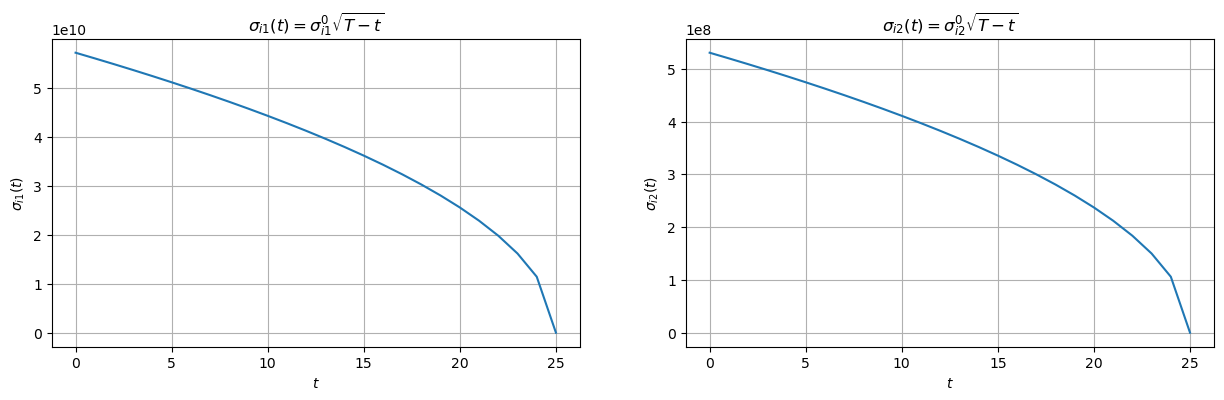

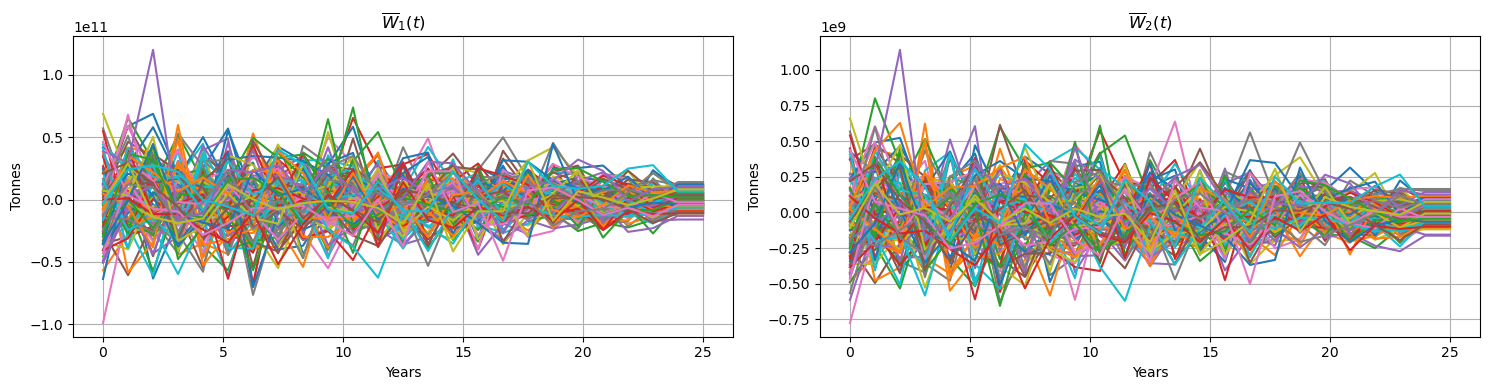

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

The tolerance level must satisfy:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 2 sectors!


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------------------------------------------------------------------------
The price process:


<IPython.core.display.Math object>

where:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_25036\4002917206.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_result, _ = quad(integrand, 0, T, args=(y,))
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_25036\4002917206.py:364: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral_result, _ = quad(integrand, 0, T, args=(y,))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [51]:
#################################################      Price process      #################################################

try:
    columns = os.get_terminal_size().columns
except OSError:
    columns = 80  # Default width for non-terminal environments

# Time-varying volatility that vanishes at t -> T:  sigma_ij(t) = sigma^0_ij * sqrt(T - t)
print("-" * columns)
print("Time-varying volatility that vanishes as t -> T: σ_ij(t) = σ^0_ij sqrt(T - t)")

display(Math(r"""
\begin{equation*}
\boxed{\sigma_{ij}(t) = \sigma^0_{ij}\sqrt{T - t}}
\end{equation*}
"""))

# Kept for backwards-compatibility with existing function signatures (no longer used in σ(t))
lambda_ = 0.25

def volatility_sqrt(std, T, dt, W, adj, lambda_ = 1):
    """
    Deterministic volatility profile consistent with the paper:
        σ_{ij}(t) = σ^0_{ij} * sqrt(T - t)
    for each sector j and firm i.

    std[f"{j}"] : baseline σ^0_j for sector j
    adj         : unit scaling (same adj you use elsewhere)
    W           : Brownian dictionary used only to infer #sectors and #firms
    """
    # Count sectors from W["1"] keys
    sectors = 0
    for key in W["1"].keys():
        if key.startswith("Sector"):
            sectors += 1  

    # Count firms per sector
    firms_All = {}
    for i in range(sectors):
        firms = 0
        for key in W["1"].keys():
            if key.startswith("Firm_") and key.endswith(f"{i}"):
                firms += 1
        firms_All[f"{i}"] = firms        

    if isinstance(std, dict):
        vol = {}

        # Build σ_j(t) for each sector j
        for i in range(sectors):
            # Time grid 0, dt, ..., T-dt (consistent with the rest of the notebook)
            t = np.linspace(0., T, int(T / dt))
            # Defensive max(·,0) in case of rounding at T
            vol[f"{i}"] = (std[f"{i}"] * adj) * np.sqrt(np.maximum(T - t, 0.0))

        # Replicate sector-level σ_j(t) across all firms in that sector
        vol_vec = {}
        for key in firms_All.keys():
            j = int(key)
            vol_vec[key] = np.full((firms_All[key], len(vol[f"{j}"])), vol[f"{j}"])

    return t, vol, vol_vec


# Build and plot σ_j(t)
t, vol_exp, vol_vec_exp = volatility_sqrt(std = std, T = T, dt = dt_T, W = W, adj = adj, lambda_ = lambda_)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

axes[0].plot(np.arange(0, T, dt_T), vol_exp["0"])
axes[0].set_title(r'$\sigma_{i1}(t) = \sigma^0_{i1}\sqrt{T - t}$')
axes[0].set_xlabel(r'$t$')
axes[0].set_ylabel(r'$\sigma_{i1}(t)$')
axes[0].grid()

axes[1].plot(np.arange(0, T, dt_T), vol_exp["1"])
axes[1].set_title(r'$\sigma_{i2}(t) = \sigma^0_{i2}\sqrt{T - t}$')
axes[1].set_xlabel(r'$t$')
axes[1].set_ylabel(r'$\sigma_{i2}(t)$')
axes[1].grid()

plt.savefig('VolFunctions.png', bbox_inches = 'tight', dpi = 300, facecolor = 'white')

print("Proof of integrability condition:")

print("We wish to verify:")

display(Math(r"\mathbb{E}\left[\int_{0}^{T}\frac{\sigma_{ij}^2(t)}{(T-t)}\,dt\right]<\infty"))

print("We have:")

display(Math(r'\sigma_{ij}(t) = \sigma^0_{ij}\sqrt{T-t}\text{, which leads to:}'))

display(Math(r"""
\begin{align*}
\int_{0}^{T}\frac{\sigma_{ij}^2(t)}{(T-t)}dt 
&= \int_{0}^{T}\frac{\left(\sigma^0_{ij}\sqrt{T-t}\right)^2}{(T-t)}dt \\
&= \int_{0}^{T}\frac{\sigma_{0,ij}^2 (T-t)}{(T-t)}dt \\
&= \sigma_{0,ij}^2 \int_{0}^{T} 1 \, dt \\
&= \sigma_{0,ij}^2 T < \infty.
\end{align*}
"""))

print("Hence, the integrability condition holds.")

# The aggregate Martingale
print("-" * columns)
print("The aggregate martingale is defined by:")

display(Math(r"\overline{W}_j(t)=\frac{\sum\limits_{i=1}^{N_j}\int_0^t\sigma^{ij}(s)dW_{ij}(s)}{N^j}"))


def aggW(W, std, dt , adj):
    """
    Construct the aggregate martingales \bar{W}_j(t) using the
    deterministic volatility σ^{ij}(t) = σ^0_{ij} sqrt(T - t).
    """
    sectors = 0
    Steps = len(W["1"]["Firm_00"])  # Assuming "Firm_00" is a valid key for initialization
    T = dt * (Steps - 1)
    timeSteps = np.linspace(0., T, Steps)
    
    # Universal volatility profile σ_j(t) for all Monte Carlo paths
    t, vol_sq, vol_vec = volatility_sqrt(std = std, T = T, dt = dt, W = W, adj = adj, lambda_ = lambda_)  
    
    for key in W["1"].keys():
        if key.startswith("Sector"):
            sectors += 1
    
    print(f"There are {sectors} sectors!")

    firms_All = {}
    for i in range(sectors):
        firms = 0
        for key in W["1"].keys():
            if key.startswith(f"Firm_") and key.endswith(f"{i}"):
                firms += 1
        firms_All[f"{i}"] = firms
        
    for i, key in enumerate(firms_All.keys()):
        print(f"There are {firms_All[key]} firms in sector {int(key) + 1}!")
    
    wAgg_All = {}
    
    for w in W.keys():
        wAgg = {}
        counter = 0  # Reset for each Monte Carlo simulation
        
        for i in range(sectors):
            wAgg[f"{i}"] = np.zeros(Steps)
            for key in W[w].keys():
                if key.startswith(f"Firm_") and key.endswith(f"{i}"):  # Ensure this matches your naming convention
                    counter += 1
                    dW = np.diff(W[w][key], prepend = 0)
                    
                    for j in range(len(dW)):
                        for l in range(j):
                            if isinstance(vol_sq, dict):
                                wAgg[f"{i}"][j] += (vol_sq[f"{i}"][l] * dW[l])    
                            else:
                                wAgg[f"{i}"][j] += (vol_sq[l] * dW[l])
        wAgg_All[w] = {}
        
        for key in wAgg.keys():
            wAgg_All[w][key] = wAgg[key] / counter
    
    return t, wAgg_All, firms_All
    
t, wAgg_All, firms_All = aggW(W = W, std = std, dt = dt_T , adj = adj)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

for key in wAgg_All.keys():
    axes[0].plot(t, wAgg_All[key]["0"][1:])
axes[0].set_title("$\overline{W}_1(t)$")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Tonnes")
axes[0].grid()

for key in wAgg_All.keys():
    axes[1].plot(t, wAgg_All[key]["1"][1:])
axes[1].set_title("$\overline{W}_2(t)$")
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Tonnes")
axes[1].grid()

plt.tight_layout()
plt.show()


# The tolerance
print("-" * columns)

display(Math(r"\text{Supposing that we have the covariance matrix: }\sigma_j(t)=(\sigma_{1j}(t),\cdots,\sigma_{N^jj}(t))'"))

print("The tolerance level must satisfy:")

display(Math(r"\epsilon\in\left(0,\min_j\left(\delta_j((\bar{\mu}_j+\bar{c}_j)T)^2+\int_0^T\mathbb{E}[(\sigma^j(t))'\Sigma^j\sigma^j(t)]dt\right)^{\frac{1}{2}}\right)"))

display(Math(r"\text{or if }\sigma^j(t)\text{ is deterministic, as in the above example then:}"))

display(Math(r"\epsilon\in\left(0,\min_j\left(\delta_j((\bar{\mu}_j+\bar{c}_j)T)^2+\int_0^T(\sigma^j(t))'\Sigma^j\sigma^j(t)dt\right)^{\frac{1}{2}}\right)"))

display(Math(r"\text{In our case, since we are only considering one firm in each sector, this simplifies to:}"))

display(Math(r"\epsilon\in\left(0,\min_j\left(\delta_j((\bar{\mu}_j+\bar{c}_j)T)^2+\int_0^T\sigma^j(t)^2dt\right)^{\frac{1}{2}}\right)"))


def tolerance_AllSectors(T, mu, c, std, adj, dt, W, delta):
    """
    Compute ε_j bounds using σ_j(t) = σ^0_j sqrt(T - t).
    """
    sectors = 0
    Steps = len(W["1"]["Firm_00"])  # Assuming "Firm_00" is a valid key for initialization
        
    for key in W["1"].keys():
        if key.startswith("Sector"):
            sectors += 1
    
    print(f"There are {sectors} sectors!")

    def toler(T, mu, c, std, adj, dt, delta):
        # ∫_0^T σ_j(t)^2 dt with σ_j(t) = σ^0_j sqrt(T - t)
        def integrand(t):
            vol = (std * adj) * np.sqrt(np.maximum(T - t, 0.0))
            return vol ** 2

        integral_result, _ = quad(integrand, 0, T)

        epsilon_min = np.sqrt(delta * ((mu + c) * T)**2 + integral_result)

        return epsilon_min
    
    epsilons = {}
    
    for i in range(sectors):
        if not isinstance(c[f"{i}"], list):
            epsilons[f"{i}"] = toler(T = T, mu = mu[f"{i}"], c = c[f"{i}"],
                                     std = std[f"{i}"], adj = adj, dt = dt_T,
                                     delta = delta[f"{i}"])
        else:
            epsilons[f"{i}"] = []
            for k in range(len(c[f"{i}"])):
                epsilons[f"{i}"].append(
                    toler(T = T, mu = mu[f"{i}"], c = c[f"{i}"][k],
                          std = std[f"{i}"], adj = adj, dt = dt_T,
                          delta = delta[f"{i}"])
                )
      
    if not isinstance(c["0"], list):
        epsilon_min = min(epsilons.values())
        print(f"Epsilon should be in the range (0, {epsilon_min})")
    else:
        epsilon_min = [] 
        for k in range(len(c["0"])):
            epsilon_min_k = min(
                [epsilons[f"{i}"][k] for i in range(sectors) if isinstance(epsilons[f"{i}"], list)]
            )
            epsilon_min.append(epsilon_min_k)
            display(Math(
                f"\\varepsilon\\text{{ should be in the range }} (0, {epsilon_min_k})"
                f"\\text{{ for }} \\bar{{c}}_1 = {c['0'][k]} \\text{{ and }} \\bar{{c}}_2 = {c['1'][k]}!"
            ))
        
    return epsilons, epsilon_min


if isinstance(h_1, list) and isinstance(eta_1, list) and 'c_sq' in globals():
    epsilons, epsilon_min = tolerance_AllSectors(
        T = T, mu = mu, c = c_sq, std = std, adj = adj, dt = dt_T, W = W, delta = delta
    )
else:
    epsilons, epsilon_min = tolerance_AllSectors(
        T = T, mu = mu, c = c, std = std, adj = adj, dt = dt_T, W = W, delta = delta
    )


# The price process
print("-" * columns)
print("The price process:")

display(Math(r'd\hat{P}_j(t) = \frac{2y^j}{1+2y^{j}\bar{\eta}^j(T-t)}d\overline{W}_j(t)'))

print("where:")

display(Math(r'\hat{P}_j(0) = \frac{2y^j((\bar{\mu}^j+\bar{c}^j)T-\bar{b}^j)}{1+2y^{j}\bar{\eta}^jT}'))

display(Math(r'\text{ and where }y^j\text{ for }y^j\geq 0 \text{ and some tolerance level }\varepsilon^j\text{ is the solution to:}'))

display(Math(r"""
\begin{equation}
\varepsilon^2=\left(\frac{((\bar{\mu}^j+\bar{c}^j)T-\bar{b}^j)}{1+2y^j\bar{\eta}^jT}\right)^2+\int_0^T\frac{1}{(1+2y^j\bar{\eta}^j(T-t))^2}\mathbb{E}[(\sigma^j(t))'\Sigma^j\sigma^j(t)]dt
\end{equation}
"""))

display(Math(r"\text{In our case, since the volatility is deterministic, the problem simplifies to}"))

display(Math(r"""
\begin{equation}
\varepsilon^2=\left(\frac{((\bar{\mu}^j+\bar{c}^j)T-\bar{b}^j)}{1+2y^j\bar{\eta}^jT}\right)^2+\int_0^T\frac{(\sigma^j(t))'\Sigma^j\sigma^j(t)}{(1+2y^j\bar{\eta}^j(T-t))^2}dt
\end{equation}
"""))

display(Math(r"\text{Moreover, since we are assuming one firm per sector, the problem further simplifies to}"))

display(Math(r"""
\begin{equation}
\varepsilon^2=\left(\frac{((\bar{\mu}^j+\bar{c}^j)T-\bar{b}^j)}{1+2y^j\bar{\eta}^jT}\right)^2+\int_0^T\frac{\sigma^j(t)^2}{(1+2y^j\bar{\eta}^j(T-t))^2}dt
\end{equation}
"""))


def solveY(W, std, T, eta, mu, c, adj, eps, b, y_initial_guess, lambda_, combinations=None):
    """
    Solve for the Lagrange multipliers y^j given ε, with σ_j(t) = σ^0_j sqrt(T - t).
    The parameter 'lambda_' is kept only for API compatibility.
    """
    sectors = 0
    for key in W["1"].keys():
        if key.startswith("Sector"):
            sectors += 1  
    
    if isinstance(std, dict):
        # Multi-sector case
        if combinations is None:
            y = {}
            for i in range(sectors):
                def integrand(t, y):
                    vol = (std[f"{i}"] * adj) * np.sqrt(np.maximum(T - t, 0.0))
                    return (vol ** 2) / (1 + 2 * y * eta[f"{i}"] * (T - t)) ** 2

                def equation(y):
                    integral_result, _ = quad(integrand, 0, T, args=(y,))
                    term_1 = (((mu[f"{i}"] * adj + c[f"{i}"]) * T) - b[f"{i}"]) / (1 + (2 * y * eta[f"{i}"] * T))  
                    return (term_1 ** 2) + integral_result - (eps ** 2)

                sol = root(equation, y_initial_guess)            
                if sol.success:
                    y[f"{i}"] = sol.x[0]
                else:
                    print(f"Solver failed to converge for sector {i}")
                    y[f"{i}"] = None

            for key in y.keys():
                display(Math(
                    f"\\text{{The Lagrange multiplier for sector }}{str(int(key) + 1)}"
                    f"\\text{{ and }}\\bar{{b}}^{str(int(key) + 1)}={np.round(b[key] / adj, 2)}"
                    f"\\text{{ is }}{np.round(y[key], 2)}\\text{{, with }}"
                    f"\\bar{{h}}^{str(int(key) + 1)}={h[key]}"
                    f"\\text{{ and }}\\bar{{\\eta}}^{str(int(key) + 1)}={eta[key]}"
                    "\\; ton^2/(£\\; year)!"
                ))

        else:
            y = {}
            for i in range(sectors):
                y[f"{i}"] = []
                for j in range(len(combinations[f"{i}"])):
                    def integrand(t, y):
                        vol = (std[f"{i}"] * adj) * np.sqrt(np.maximum(T - t, 0.0))
                        return (vol ** 2) / (1 + 2 * y * combinations[f"{i}"][j][1] * (T - t)) ** 2

                    def equation(y):
                        integral_result, _ = quad(integrand, 0, T, args=(y,))
                        term_1 = (((mu[f"{i}"] * adj + c[f"{i}"][j]) * T) - b[f"{i}"][j]) / (1 + (2 * y * combinations[f"{i}"][j][1] * T))  
                        return (term_1 ** 2) + integral_result - (eps[j] ** 2)

                    sol = root(equation, y_initial_guess)
                    if sol.success:
                        y[f"{i}"].append(sol.x[0])
                    else:
                        print(f"Solver failed to converge for sector {i}")
                        y[f"{i}"].append(None)
        
            for key in y.keys():
                for j in range(len(y[key])):
                    display(Math(
                        f"\\text{{The Lagrange multiplier for sector }}{str(int(key) + 1)}"
                        f"\\text{{ and }}\\bar{{b}}^{str(int(key) + 1)}={np.round(b[key][j] / adj, 2)}"
                        f"\\text{{ is }}{np.round(y[key][j], 2)}\\text{{, with }}"
                        f"\\bar{{h}}^{str(int(key) + 1)}={combinations[key][j][0]}"
                        f"\\text{{ and }}\\bar{{\\eta}}^{str(int(key) + 1)}={combinations[key][j][1]}"
                        "\\; ton^2/(£\\; year)!"
                    ))
    else:
        # Single-sector case
        if combinations is None:
            def integrand(t, y):
                vol = (std * adj) * np.sqrt(np.maximum(T - t, 0.0))
                return (vol ** 2) / (1 + 2 * y * eta * (T - t)) ** 2

            def equation(y):
                integral_result, _ = quad(integrand, 0, T, args=(y,))
                term_1 = (((mu * adj + c) * T) - b) / (1 + (2 * y * eta * T))  
                return (term_1 ** 2) + integral_result - (eps ** 2)

            sol = root(equation, y_initial_guess)
            if sol.success:
                y = sol.x[0]
            else:
                print("Solver failed to converge")
                y = None

            print(f"The Lagrange multiplier is {np.round(y, 2)}")
        else:
            y = []
            for j in range(len(combinations)):
                def integrand(t, y):
                    vol = (std * adj) * np.sqrt(np.maximum(T - t, 0.0))
                    return (vol ** 2) / (1 + 2 * y * combinations[j][1] * (T - t)) ** 2

                def equation(y):
                    integral_result, _ = quad(integrand, 0, T, args=(y,))
                    term_1 = (((mu * adj + c[j]) * T) - b[j]) / (1 + (2 * y * combinations[j][1] * T))  
                    return (term_1 ** 2) + integral_result - (eps[j] ** 2)

                sol = root(equation, y_initial_guess)
                if sol.success:
                    y.append(sol.x[0])
                else:
                    y.append(None)

    return y


combinations = {"0": combinations_1, "1": combinations_2}

# Solve for y.  epsilon_min is divided by adj^2 to aid numerical convergence
if isinstance(h_1, list) and isinstance(eta_1, list) and 'c_sq' in globals():
    adjusted_eps_list = [value / adj**2 for value in epsilon_min]

    y_solution       = solveY(W = W, std = std, T = T, eta = eta, mu = mu,
                              c = c_sq, adj = adj, eps = adjusted_eps_list,
                              b = b_sq, y_initial_guess = 1e-9,
                              lambda_ = lambda_, combinations = combinations_sq)
    y_solution_bnull = solveY(W = W, std = std, T = T, eta = eta, mu = mu,
                              c = c_sq, adj = adj, eps = adjusted_eps_list,
                              b = b_null_sq, y_initial_guess = 1e-9,
                              lambda_ = lambda_, combinations = combinations_sq)

elif isinstance(h_1, list) and isinstance(eta_1, list):
    
    adjusted_eps_list = [value / adj**2 for value in epsilon_min]

    y_solution       = solveY(W = W, std = std, T = T, eta = eta, mu = mu,
                              c = c, adj = adj, eps = adjusted_eps_list,
                              b = b, y_initial_guess = 1e-9,
                              lambda_ = lambda_, combinations = combinations)
    y_solution_bnull = solveY(W = W, std = std, T = T, eta = eta, mu = mu,
                              c = c, adj = adj, eps = adjusted_eps_list,
                              b = b_null, y_initial_guess = 1e-9,
                              lambda_ = lambda_, combinations = combinations)

else:
    
    adjusted_eps = epsilon_min / adj**2

    y_solution       = solveY(W = W, std = std, T = T, eta = eta, mu = mu,
                              c = c, adj = adj, eps = adjusted_eps,
                              b = b, y_initial_guess = 1e-9,
                              lambda_ = lambda_, combinations = None)
    y_solution_bnull = solveY(W = W, std = std, T = T, eta = eta, mu = mu,
                              c = c, adj = adj, eps = adjusted_eps,
                              b = b_null, y_initial_guess = 1e-9,
                              lambda_ = lambda_, combinations = None)


def priceProcess(yhat, mu, c, b, eta, T, dt, W_agg, adj, combinations = None):
    """
    Simulate the optimal price process \hat{P}_j(t) given y^j and \bar{W}_j(t).
    This part is unchanged; it still uses the generic formula driven by wAgg_All.
    """
    if isinstance(W_agg["0"], dict):
        N = int
        P = {}
        dW = {}

        for key in W_agg["1"].keys():
            NN = len(W_agg["1"][key])
            B = len(W_agg.keys())
            if combinations == None:
                P[key] = np.zeros((NN, B))
                P[key][0, : ] = (2 * yhat[key] * (((mu[key] * adj) + c[key]) * T - b[key])) / (1 + (2 * yhat[key] * eta[key] * T))
                dW[key] = np.zeros((NN, B))
            else:
                P[key]  = []
                dW[key] = np.zeros((NN, B))
                for j in range(len(yhat[key])):
                    P[key].append(np.zeros((NN, B)))
                    P[key][j][0, : ] = (2 * yhat[key][j] * (((mu[key] * adj) + c[key][j]) * T - b[key][j])) / (1 + (2 * yhat[key][j] * combinations[key][j][1] * T))            

        for key in W_agg["1"].keys():
            for i,keys in enumerate(W_agg.keys()):
                dW[key][ : , i] = np.diff(W_agg[keys][key], prepend = 0)
            if combinations == None:
                for j in range(B):
                    for i in range(NN - 1):
                        P[key][i + 1, j] = P[key][i, j] + (((2 * yhat[key]) / (1 + (2 * yhat[key] * eta[key] * (T - t[i]))))* dW[key][i, j])
            else:
                for jj in range(len(yhat[key])): 
                    for j in range(B):
                        for i in range(NN - 1):
                            P[key][jj][i + 1, j] = P[key][jj][i, j] + (((2 * yhat[key][jj]) / (1 + (2 * yhat[key][jj] * combinations[key][jj][1] * (T - t[i]))))* dW[key][i, j])
    else:
        N = int
        NN = len(W_agg["1"])
        B = len(W_agg.keys())
        if combinations == None:
            P = np.zeros((NN, B))
            P[0, : ] = (2 * yhat * (((mu * adj) + c) * T - b)) / (1 + (2 * yhat * eta * T))
            dW = np.zeros((NN, B))
        else:
            P  = []
            dW = np.zeros((NN, B))
            for j in range(len(yhat)):
                P.append(np.zeros((NN, B)))
                P[j][0, : ] = (2 * yhat[j] * (((mu * adj) + c[j]) * T - b[j])) / (1 + (2 * yhat[j] * combinations[1][j] * T))            

        for i,keys in enumerate(W_agg.keys()):
            dW[ : , i] = np.diff(W_agg[keys], prepend = 0)
        if combinations == None:
            for j in range(B):
                for i in range(NN - 1):
                    P[i + 1, j] = P[i, j] + (((2 * yhat) / (1 + (2 * yhat * eta * (T - t[i]))))* dW[i, j])
        else:
            for jj in range(len(yhat)): 
                for j in range(B):
                    for i in range(NN - 1):
                        P[jj][i + 1, j] = P[jj][i, j] + (((2 * yhat[jj]) / (1 + (2 * yhat[jj] * combinations[1][jj] * (T - t[i]))))* dW[i, j])

    return t, P, dW



if isinstance(h_1, list) and isinstance(eta_1, list) and 'c_sq' in globals():

    t      , PP      , dW       = priceProcess(yhat = y_solution,       mu = mu, c = c_sq, b = b_sq,     eta = eta, T = T, dt = dt_T, W_agg = wAgg_All, adj = adj, combinations = combinations_sq)
    t_bnull, PP_bnull, dW_bnull = priceProcess(yhat = y_solution_bnull, mu = mu, c = c_sq, b = b_null_sq, eta = eta, T = T, dt = dt_T, W_agg = wAgg_All, adj = adj, combinations = combinations_sq)

elif isinstance(h_1, list) and isinstance(eta_1, list):
    
    t      , PP      , dW       = priceProcess(yhat = y_solution,       mu = mu, c = c, b = b,         eta = eta, T = T, dt = dt_T, W_agg = wAgg_All, adj = adj, combinations = combinations)
    t_bnull, PP_bnull, dW_bnull = priceProcess(yhat = y_solution_bnull, mu = mu, c = c, b = b_null,   eta = eta, T = T, dt = dt_T, W_agg = wAgg_All, adj = adj, combinations = combinations)

else:
    
    t      , PP      , dW       = priceProcess(yhat = y_solution,       mu = mu, c = c, b = b,       eta = eta, T = T, dt = dt_T, W_agg = wAgg_All, adj = adj, combinations = None)
    t_bnull, PP_bnull, dW_bnull = priceProcess(yhat = y_solution_bnull, mu = mu, c = c, b = b_null, eta = eta, T = T, dt = dt_T, W_agg = wAgg_All, adj = adj, combinations = None)


In [52]:
################################################# Price, Lagrange, y plots #################################################

# Generates 100 evenly spaced allocation levels between 0 and sector cap b^j
def linspaceAllocations(b, number=100):
    """
    Input
    -----
    b : dict
        Keys correspond to sectors ("0","1")
        Values may be scalars or lists (multiple h-η combinations)
    number : int
        Number of allocation grid points

    Output
    ------
    b_linspace_sq : dict
        Same structure as b, but replaced with allocation vectors
    """
    b_linspace_sq = {}

    # Case: multiple regulatory scenarios per sector
    if isinstance(b["0"], list):
        for key in b.keys():
            b_linspace_sq[key] = [
                np.linspace(0, b[key][k], number) for k in range(len(b[key]))
            ]
    # Case: single allocation cap per sector
    else:
        for key in b.keys():
            b_linspace_sq[key] = np.linspace(0, b[key], number)

    return b_linspace_sq


# Generate allocation grid consistent with whether c, η are list-valued
if isinstance(h_1, list) and isinstance(eta_1, list) and "b_sq" in globals():
    b_linspace_sq = linspaceAllocations(b=b_sq, number=100)
else:
    b_linspace_sq = linspaceAllocations(b=b, number=100)


#############################################################
# Compute y(b) and P(b) for every grid allocation
#############################################################

y_solution_plots = {}
PP_plots = {}

for key in b_linspace_sq.keys():  # iterate over sectors "0","1"

    y_solution_plots[key] = []
    PP_plots[key] = []

    # Case: multiple gas–cost combinations
    if isinstance(b_linspace_sq["0"], list):

        for i in range(len(b_linspace_sq[key])):  # loop over combinations

            y_inner = []
            PP_inner = []

            for b_val in b_linspace_sq[key][i]:  # loop over allocation values

                # Solve for optimal y under allocation b_val
                y_temp = solveY(
                    W=W,
                    std=std[key],
                    T=T,
                    eta=combinations[key][i][1],
                    mu=mu[key],
                    c=c[key][i],
                    adj=adj,
                    eps=adjusted_eps_list[i],
                    b=b_val,
                    y_initial_guess=1e-9,   # small positive starting value
                    lambda_=lambda_,
                    combinations=None
                )

                # Compute price path under solved y
                t_temp, PP_temp, _ = priceProcess(
                    yhat=y_temp,
                    mu=mu[key],
                    c=c[key][i],
                    b=b_val,
                    eta=combinations[key][i][1],
                    T=T,
                    dt=dt_T,
                    W_agg=wAgg_All[key],
                    adj=adj,
                    combinations=None
                )

                y_inner.append(y_temp)
                PP_inner.append(PP_temp[0][0])  # initial price P_j(0)

            y_solution_plots[key].append(y_inner)
            PP_plots[key].append(PP_inner)

    # Case: single parameter set per sector
    else:
        for b_val in b_linspace_sq[key]:

            y_temp = solveY(
                W=W,
                std=std[key],
                T=T,
                eta=eta[key],
                mu=mu[key],
                c=c[key],
                adj=adj,
                eps=adjusted_eps,
                b=b_val,
                y_initial_guess=1e-9,
                lambda_=lambda_,
                combinations=None
            )

            t_temp, PP_temp, _ = priceProcess(
                yhat=y_temp,
                mu=mu[key],
                c=c[key],
                b=b_val,
                eta=eta[key],
                T=T,
                dt=dt_T,
                W_agg=wAgg_All[key],
                adj=adj,
                combinations=None
            )

            y_solution_plots[key].append(y_temp)
            PP_plots[key].append(PP_temp[0][0])  # store starting price


C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_25036\4002917206.py:393: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral_result, _ = quad(integrand, 0, T, args=(y,))
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_25036\4002917206.py:393: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  integral_result, _ = quad(integrand, 0, T, args=(y,))


The Lagrange multiplier is 280141009106.47
The Lagrange multiplier is 279915486159.78
The Lagrange multiplier is 279691498440.21
The Lagrange multiplier is 279469049639.11
The Lagrange multiplier is 279248143434.18
The Lagrange multiplier is 279028783489.22
The Lagrange multiplier is 278810973453.89
The Lagrange multiplier is 278594716963.42
The Lagrange multiplier is 278380017638.38
The Lagrange multiplier is 278166879084.39
The Lagrange multiplier is 277955304891.9
The Lagrange multiplier is 277745298635.89
The Lagrange multiplier is 277536863875.63
The Lagrange multiplier is 277330004154.43
The Lagrange multiplier is 277124722999.34
The Lagrange multiplier is 276921023920.94
The Lagrange multiplier is 276718910413.02
The Lagrange multiplier is 276518385952.38
The Lagrange multiplier is 276319453998.53
The Lagrange multiplier is 276122117993.42
The Lagrange multiplier is 275926381361.2
The Lagrange multiplier is 275732247507.95
The Lagrange multiplier is 275539719821.46
The Lagrange 

In [54]:
################################################       3D Plot codes       ################################################

def priceProcess_t0(yhat, mu, c, b, eta, T, adj):
    """
    Compute the t=0 equilibrium permit price:
        P(0) = (2 y (( (mu*adj + c)*T ) - b )) / (1 + 2 y eta T)

    Inputs:
        yhat  : regulator's intensity (scalar)
        mu    : mean emissions level for sector j
        c     : cost parameter c_j
        b     : average allocation b_j
        eta   : flexibility parameter η_j
        T     : horizon
        adj   : scaling constant converting emissions to correct units

    Returns:
        P : permit price at time 0
    """
    P = (2 * yhat * ((((mu * adj) + c) * T) - b)) / (1 + (2 * yhat * eta * T))
    return P


# Containers for final 3D-plot objects (one per scenario in eta["0"])
y_3D_plot, PP_3D_plot = [], []  


for ii in range(len(eta["0"])):       # Loop over all (h,η) scenarios

    # Initialize 3D plot dictionaries for sector 1 ("0") and sector 2 ("1")
    y_3D_plott  = {"0": [], "1": []}
    PP_3D_plott = {"0": [], "1": []}

    # Loop across sectors
    for key in PP_3D_plott.keys():

        counter = 0 
        y_inner = []       # Stores y-grid values
        PP_inner = []      # Stores the full row of prices for each y

        # Max y value differs a bit across sectors to ensure numerical stability
        if key == "0":
            maxnum = 1e-9
        else:
            maxnum = 1e-5

        # Build y-grid from 0 to maxnum in steps of maxnum*1e-3
        while counter <= maxnum:

            y_inner.append(counter)

            PP_inner_2 = []      # Holds prices for all b-values at fixed y

            # Loop over the b-grid for sector "key" and scenario ii
            for i in range(len(b_linspace_sq[key][ii])):

                # Compute P(0) for each (b, y)
                PP_temp = priceProcess_t0(
                    yhat = counter,
                    mu   = mu[key],
                    c    = c[key][ii],
                    b    = b_linspace_sq[key][ii][i],
                    eta  = eta[key][ii],
                    T    = T,
                    adj  = adj
                )

                PP_inner_2.append(PP_temp)

            # Avoid sticking exactly at y=0 due to division in the price formula
            if counter == 0:
                counter = maxnum * 1e-3
            else:
                counter += maxnum * 1e-3

            PP_inner.append(np.array(PP_inner_2))

        # Store constructed grids
        y_3D_plott[key]  = y_inner
        PP_3D_plott[key] = PP_inner

    # Append per-scenario outputs
    y_3D_plot.append(y_3D_plott)
    PP_3D_plot.append(PP_3D_plott)


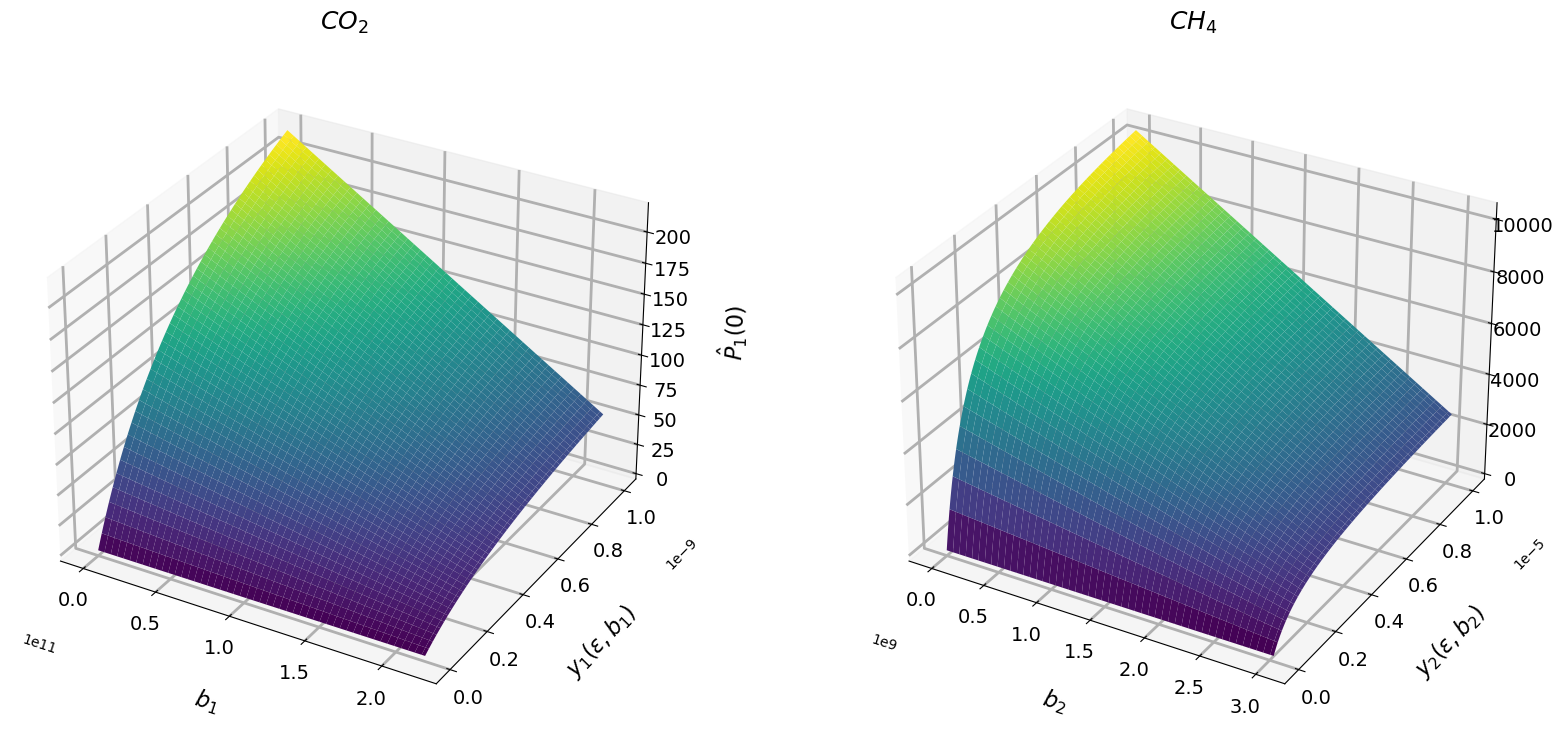

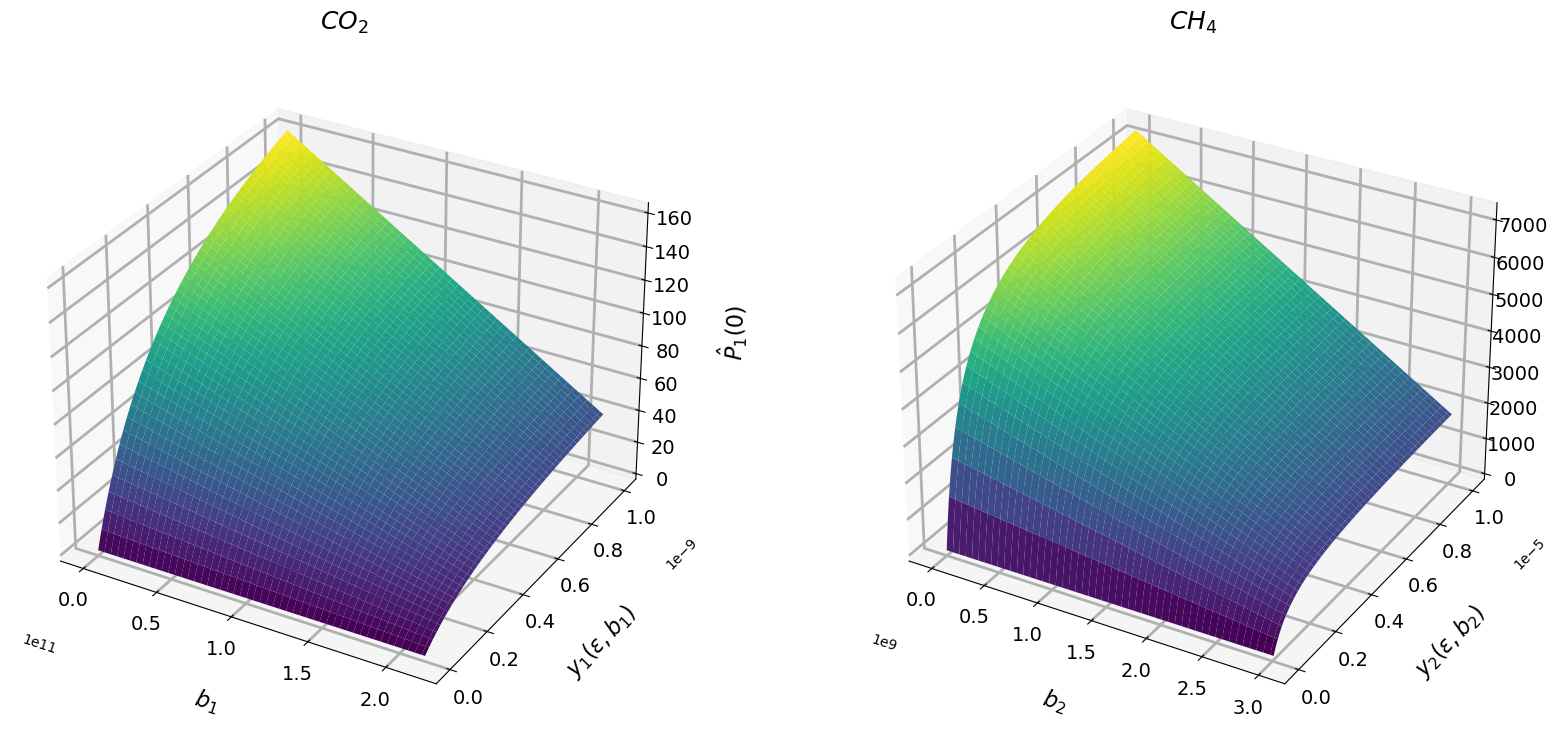

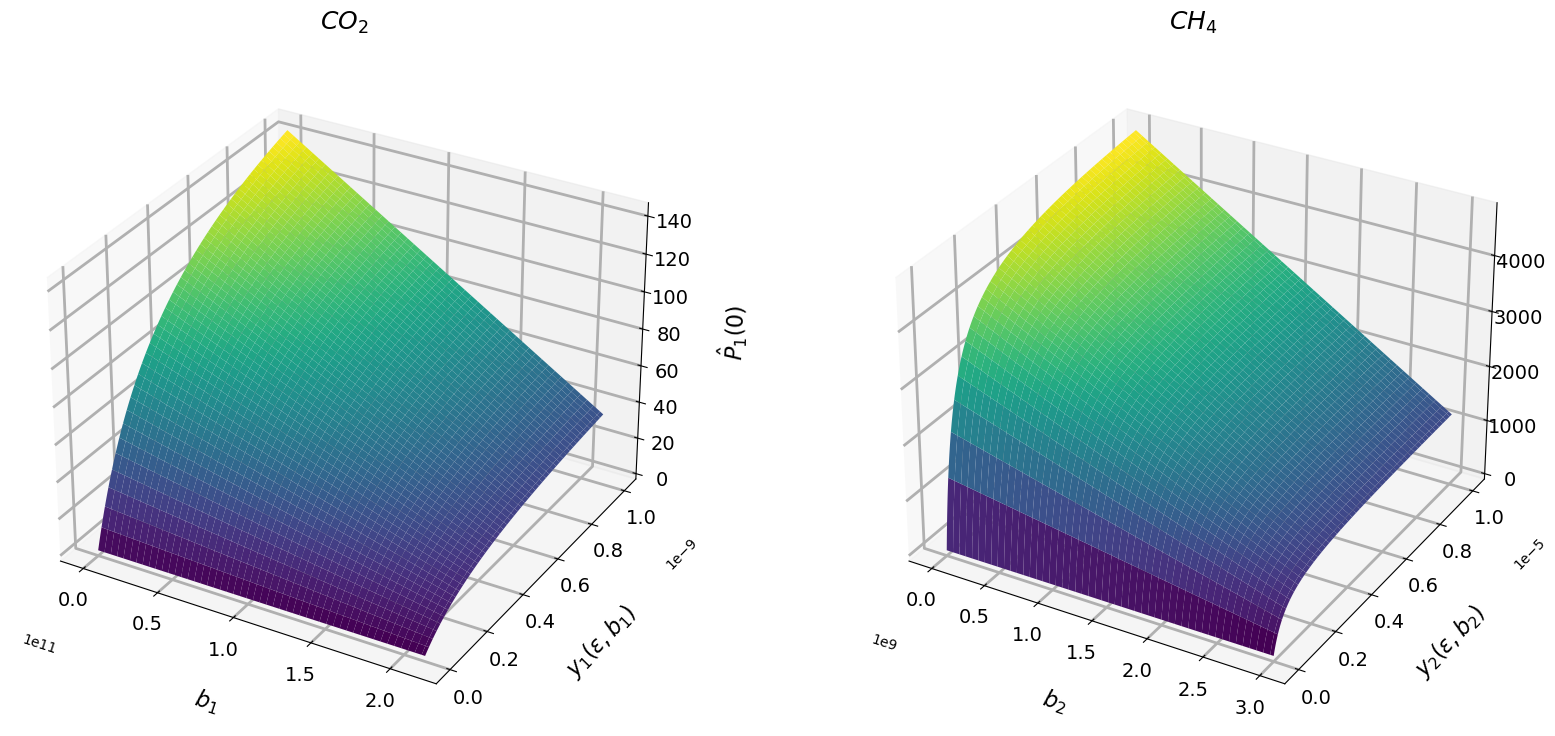

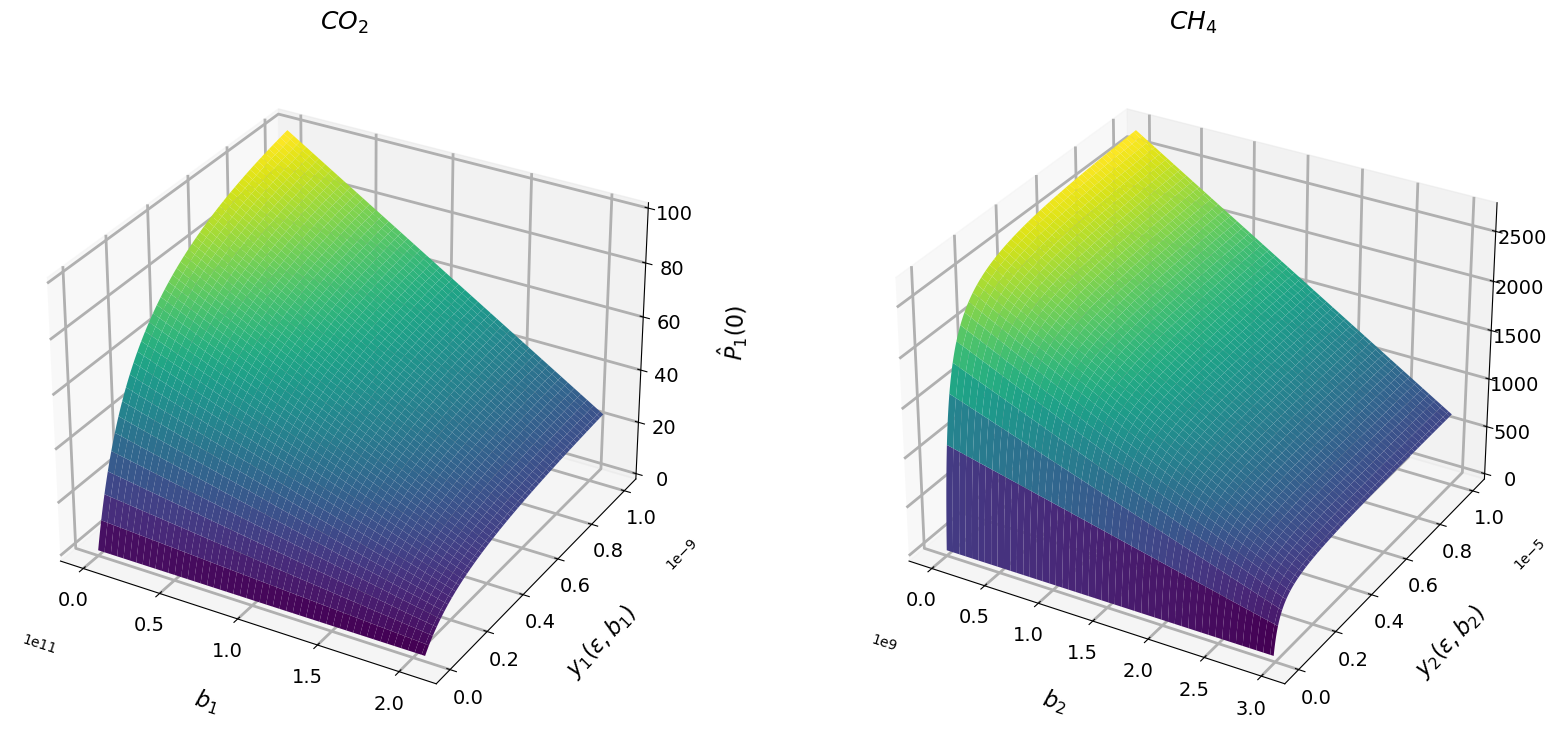

In [55]:
################################################       3D Plot: P_j(0) vs (b_j, y_j)       ################################################

# For each (h, η) scenario indexed by i
for i in range(len(b_linspace_sq["0"])):

    # Create figure and subplots (one surface per sector)
    fig = plt.figure(figsize=(18, 8))  # Keep the original figure size

    # =========================
    # Sector 1: CO2 (key "0")
    # =========================
    ax1 = fig.add_subplot(121, projection='3d')

    # X1: allocation grid b_1,  Y1: y_1 grid,  Z1: prices for all (b_1, y_1)
    X1, Y1 = np.meshgrid(b_linspace_sq["0"][i], y_3D_plot[i]["0"])
    Z1 = np.array(PP_3D_plot[i]["0"])

    # Plot the surface for sector 1
    ax1.plot_surface(X1, Y1, Z1, cmap='viridis')
    ax1.set_xlabel(r'$b_1$', labelpad=20, fontsize=16)
    ax1.set_ylabel(r'$y_1(\epsilon,b_1)$', labelpad=20, fontsize=16)
    ax1.set_zlabel(r'$\hat{P}_1(0)$', labelpad=20, fontsize=16)
    ax1.set_title(r'$CO_2$', pad=20, fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=14)

    # Thicker grid lines for readability
    ax1.xaxis._axinfo['grid'].update({'linewidth': 2.0})
    ax1.yaxis._axinfo['grid'].update({'linewidth': 2.0})
    ax1.zaxis._axinfo['grid'].update({'linewidth': 2.0})

    # =========================
    # Sector 2: CH4 (key "1")
    # =========================
    ax2 = fig.add_subplot(122, projection='3d')

    # X2: allocation grid b_2,  Y2: y_2 grid,  Z2: prices for all (b_2, y_2)
    X2, Y2 = np.meshgrid(b_linspace_sq["1"][i], y_3D_plot[i]["1"])
    Z2 = np.array(PP_3D_plot[i]["1"])

    # Plot the surface for sector 2
    ax2.plot_surface(X2, Y2, Z2, cmap='viridis')
    ax2.set_xlabel(r'$b_2$', labelpad=20, fontsize=16)
    ax2.set_ylabel(r'$y_2(\epsilon,b_2)$', labelpad=20, fontsize=16)
    ax2.set_zlabel(r'$\hat{P}_2(0)$', labelpad=20, fontsize=16)
    ax2.set_title(r'$CH_4$', pad=20, fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=14)

    # Thicker grid lines
    ax2.xaxis._axinfo['grid'].update({'linewidth': 2.0})
    ax2.yaxis._axinfo['grid'].update({'linewidth': 2.0})
    ax2.zaxis._axinfo['grid'].update({'linewidth': 2.0})

    # Layout adjustments to avoid overlap and keep symmetry
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

    # Save figure per (h, η) scenario
    plt.savefig(f'3d_Price_b_y_plot_{i}.png', bbox_inches='tight', facecolor='w', dpi=300)
    plt.show()


In [57]:
################################################     Abatement process     ################################################
# The abatement process is defined by:
#   \hat{a}_{ij}(t) = \eta^{ij} (\hat{P}_j(t) - h^{ij})
# In the multi-scenario case (lists of (h, η)), this is applied scenario-by-scenario.

print("-" * columns)
print("The abatement process:")

display(Math(r'\hat{a}_{ij}(t) = \eta^{ij}(\hat{P}_j(t)-h^{ij})'))

def Emissions_abate(eta, P, h, adj, combinations=None):
    """
    Compute abatement paths \hat{a}_{ij}(t) for each sector j and firm i.

    Parameters
    ----------
    eta : dict
        - If combinations is None:
              eta[key] is scalar \bar{\eta}^j
          else:
              eta is not used; we read \eta from combinations[key][j][1].
    P : dict
        - If combinations is None:
              P[key] is a (time × B) array of prices for sector j.
          else:
              P[key][j] is a (time × B) array for scenario j in sector j.
    h : dict
        - If combinations is None:
              h[key] is scalar \bar{h}^j.
          else:
              h is not used; we read h from combinations[key][j][0].
    adj : float
        Scaling factor used elsewhere to convert to Gt; we divide by adj
        so that outputs are in Gt/year.
    combinations : dict or None
        - None: single (h, η) per sector.
        - dict: combinations[key][j] = (h^{ij}, η^{ij}) for scenario j.

    Returns
    -------
    abate : dict
        - If combinations is None:
              abate[key] is same shape as P[key].
          else:
              abate[key][j] has same shape as P[key][j].
    """
    abate = {}

    for key in P.keys():
        if combinations is None:
            # Single (h, η) per sector:  \hat{a}_j(t) = η^j (P_j(t) - h^j)
            abate[key] = eta[key] * (P[key] - h[key])
            # Convert back to Gt/year using adj
            abate[key] /= adj
        else:
            # Multiple (h, η) combinations for this sector
            abate[key] = []
            for j in range(len(combinations[key])):
                # combinations[key][j] = (h^{ij}, η^{ij})
                # P[key][j] is the matching price path for that (h, η) scenario
                a_j = combinations[key][j][1] * (P[key][j] - combinations[key][j][0])
                a_j /= adj  # back to Gt/year
                abate[key].append(a_j)

    return abate


# Compute abatement paths under the benchmark allocations and under b = 0
if isinstance(h_1, list) and isinstance(eta_1, list):
    abate       = Emissions_abate(eta=eta, P=PP,       h=h, adj=adj, combinations=combinations)
    abate_bnull = Emissions_abate(eta=eta, P=PP_bnull, h=h, adj=adj, combinations=combinations)
else:
    abate       = Emissions_abate(eta=eta, P=PP,       h=h, adj=adj, combinations=None)
    abate_bnull = Emissions_abate(eta=eta, P=PP_bnull, h=h, adj=adj, combinations=None)

--------------------------------------------------------------------------------
The abatement process:


<IPython.core.display.Math object>

In [58]:
###########################################     Emissions (with abatement)     ############################################

print("-" * columns)
print("Emissions trajectory (with abatement)")

display(Math(r"dE_{ij}^a(t)=\big(\mu^{ij}-\hat{a}_{ij}(t)\big)dt+\sigma_{ij}(t)\,dW_{ij}(t)"))

print("Emissions trajectory (Business as Usual)")
display(Math(r"dE_{ij}^{BAU}(t)=\mu^{ij}dt+\sigma_{ij}(t)dW_{ij}(t)"))

display(Math(r"""
\text{Thus: } 
E_{ij}^a(t)
= \int_0^t (\mu^{ij}-a_{ij}(s))\,ds
  + \int_0^t \sigma_{ij}(s)\,dW_{ij}(s)
"""))

display(Math(r"""
E_{ij}^{BAU}(t)=
\mu t+\int_0^t\sigma_{ij}(s)\,dW_{ij}(s)
"""))

display(Math(r"""
E_{ij}^a(t)=
\begin{cases}
0, & t<0,\\[4pt]
E_{ij}^a(t), & 0\le t\le T,\\[4pt]
E_{ij}^a(T), & t>T.
\end{cases}
"""))


# ============================================================
#                  WIENER PROCESS SIMPLIFICATION
# ============================================================

def Simplify_W(W, a):
    """
    Stacks W["0"]["Firm_k"], W["1"]["Firm_k"], ... into 
    W_simp[k][:, q] = W[q]["Firm_k"].

    Ensures consistent shape across firms.
    """

    W_Simp = {}

    # Initialise output containers with correct shape
    for key in W["0"].keys():        
        if key.startswith("Firm_"):

            # We only need the shape from abate["0"]:
            if isinstance(abate["0"], list):
                W_Simp[key] = np.zeros(abate["0"][0].shape)
            else:
                W_Simp[key] = np.zeros(abate["0"].shape)

    # Fill stacked structure
    for key in W_Simp.keys():
        for q, sector in enumerate(W.keys()):
            W_Simp[key][:, q] = W[sector][key]

    # Rename Firm_0, Firm_1 → "0", "1", ...
    W_simp = {}
    for i, key in enumerate(W_Simp.keys()):
        W_simp[str(i)] = W_Simp[key]

    return W_simp



# ============================================================
#                EMISSIONS SDE SIMULATION
# ============================================================

def Emissions(mu, a, sigma, W, dt, adj, T_firm, T_regulator):

    # Create matching BAU abatement = 0
    a_null = {key: [np.zeros_like(arr) for arr in arr_list] 
              for key, arr_list in a.items()}

    W_simp = Simplify_W(W = W, a = a)

    # Regulator time grids
    NN_regulator = [int(Tr / dt) for Tr in T_regulator]
    t_long       = [np.linspace(0., Tr, N) for Tr, N in zip(T_regulator, NN_regulator)]

    # Firm horizon
    NN_firm  = int(T_firm / dt)
    t_short  = np.linspace(0., T_firm, NN_firm)

    E, E_BAU = {}, {}

    # Loop sectors j = "0","1"
    for key in mu.keys():

        # MULTIPLE COMBINATION CASE (your general structure)
        if isinstance(a[key], list):

            E[key], E_BAU[key] = [], []

            # Loop over combinations index j
            for j in range(len(a[key])):

                # Prepare containers (one per regulator horizon)
                E_inner     = [np.zeros((N, W_simp["0"].shape[1])) for N in NN_regulator]
                E_inner_BAU = [np.zeros((N, W_simp["0"].shape[1])) for N in NN_regulator]

                # Pre-compute dW for all firms/paths
                dW = np.diff(W_simp["0"], prepend=0, axis=0)

                # Loop regulator horizons
                for k in range(len(NN_regulator)):
                    Nsteps = NN_regulator[k]

                    for step in range(1, Nsteps):

                        if step <= NN_firm:
                            # Drift integrals
                            drift       = np.trapz(mu[key] - a[key][j][:step, :],     dx=dt, axis=0)
                            drift_BAU   = np.trapz(mu[key] - a_null[key][j][:step, :], dx=dt, axis=0)

                            # Ito stochastic integral
                            ito_term = np.sum(sigma[key][:step, None] * dW[:step, :], axis=0)

                            # Emissions
                            E_inner[k][step, :]     = drift * adj + ito_term
                            E_inner_BAU[k][step, :] = drift_BAU * adj + ito_term

                        else:
                            # Freeze after T_firm
                            E_inner[k][step, :]     = E_inner[k][step - 1, :]
                            E_inner_BAU[k][step, :] = E_inner_BAU[k][step - 1, :]

                E[key].append(E_inner)
                E_BAU[key].append(E_inner_BAU)

        # =====================================================================
        # SINGLE-VALUE NON-LIST CASE (not used in your current runs but cleaned)
        # =====================================================================
        else:

            E_inner     = [np.zeros((N, W_simp["0"].shape[1])) for N in NN_regulator]
            E_inner_BAU = [np.zeros((N, W_simp["0"].shape[1])) for N in NN_regulator]

            dW = np.diff(W_simp["0"], prepend=0, axis=0)

            for k in range(len(NN_regulator)):
                Nsteps = NN_regulator[k]

                for step in range(1, Nsteps):

                    if step <= NN_firm:

                        drift       = np.trapz(mu[key] - a[key][0][:step],     dx=dt, axis=0)
                        drift_BAU   = np.trapz(mu[key] - a_null[key][0][:step], dx=dt, axis=0)

                        ito_term = np.sum(sigma[key][:step, None] * dW[:step, :], axis=0)

                        E_inner[k][step, :]     = drift * adj + ito_term
                        E_inner_BAU[k][step, :] = drift_BAU * adj + ito_term

                    else:
                        E_inner[k][step, :]     = E_inner[k][step - 1, :]
                        E_inner_BAU[k][step, :] = E_inner_BAU[k][step - 1, :]

            E[key]     = E_inner
            E_BAU[key] = E_inner_BAU

    return t_long, t_short, E, E_BAU



# ============================================================
#                EXECUTION FOR BOTH CASES
# ============================================================

t, t_short, emissions,      emissions_BAU = Emissions(mu=mu, a=abate,       sigma=vol_exp, W=W,
                                                      dt=dt_T, adj=adj, T_firm=T, T_regulator=T_tilde)

t, t_short, emissions_bnull, emissions_BAU_bnull = Emissions(mu=mu, a=abate_bnull, sigma=vol_exp, W=W,
                                                             dt=dt_T, adj=adj, T_firm=T, T_regulator=T_tilde)


--------------------------------------------------------------------------------
Emissions trajectory (with abatement)


<IPython.core.display.Math object>

Emissions trajectory (Business as Usual)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [59]:
###############################################  Radiative forcing (code)  ################################################

# Radiative forcing
print("-" * columns)

display(Math(
    r"R_{ij}^a(t)=\int_{-\infty}^0E_{ij}^a(t+u)d\psi^j(u)=\int_{-\infty}^0E_{ij}^a(t+u)\psi^j(du)"
    r"\quad\text{where the weighing }\psi^j\text{ is a Radon measure with support on }(-\infty,0]."
))

display(Math(
    r"\text{Therefore, for }CO_2\text{, }\psi^{1}(du)=f^{CO_2}(u)du,\quad u\leq 0\text{ and in the presence of one firm per sector:}"
))

display(Math(
    r"R_{i1}^a(t)=R_{1}^a(t)=\int_{-t}^{(T-t)\wedge 0}E_{1}^a(t+u)f^{CO_2}(u)du"
))

display(Math(r"\text{where for }CO_2:"))

display(Math(
    r"f^{CO_2}(u)=d_1e^{\frac{u}{8.696}}+d_2e^{\frac{u}{93.33}}+d_3e^{\frac{u}{645.87}}+d_4,\quad u\leq 0"
))

display(Math(
    r"\text{Where }d_1=0.004223\times0.27218,\quad d_2=0.004223\times0.14621,"
    r"\quad d_3=0.004223\times0.13639,\quad d_4=0.004223\times0.44422"
))

display(Math(r"\text{On the other hand for }CH_4\text{ we have}:"))

display(Math(r"\psi^{CH_4}(du)=f^{CH_4}(u)= d e^{\frac{u}{12}},\quad u\leq 0"))

display(Math(r"\text{Where }d=1.65"))


# === Kernels f^j(u) ===

def f_CO2(u,
          d1=0.004223 * 0.27218,
          d2=0.004223 * 0.14621,
          d3=0.004223 * 0.13639,
          d4=0.004223 * 0.44422):
    return (d1 * np.exp(u / 8.696)
            + d2 * np.exp(u / 93.33)
            + d3 * np.exp(u / 645.87)
            + d4)


tau_CH4 = 12  # decay constant for CH4 (lifetime)


def f_OtherGas(u, d=1.65, tau_gas=tau_CH4):
    return d * np.exp(u / tau_gas)


# === Radiative forcing operator ===

def R_All(E, dt, adj, timeout=100000, pulse=False, d=1.65, show=False):
    """
    Computes R_{ij}^a(t) = ∫ E_{ij}^a(t+u) f^j(u) du, for each sector key in E.

    Shapes:
      - Case 1 (main use): E[dic][k][i][t, paths]
      - Case 2:           E[dic][k][t, paths]
      - Pulse case:       E[dic][t] (1D or 2D)
    """

    start_time = time.time()
    R = {key: [] for key in E.keys()}
    f_values = {}

    for dic in E.keys():
        print(f"Processing key: {dic}")

        # ------------------------------------------------------------------
        # Case 1: E[dic] is list of scenarios, each scenario is list of grids
        #         (this matches your emissions structure: [scenario][horizon][t, paths])
        # ------------------------------------------------------------------
        if isinstance(E[dic], list) and pulse is False and isinstance(E[dic][0], list):

            for k in range(len(E[dic])):  # scenario index
                print(f"  Scenario {k + 1}/{len(E[dic])}")
                R_inner = [np.zeros(arr.shape) for arr in E[dic][k]]  # one per horizon

                for i in range(len(E[dic][k])):  # horizon index
                    T_steps = E[dic][k][i].shape[0]
                    Tmax = T_steps * dt

                    for t_idx in range(T_steps):

                        if time.time() - start_time > timeout:
                            raise TimeoutError("The function execution time exceeded the timeout threshold.")

                        t = t_idx * dt
                        u_start = -t
                        u_end = min(Tmax - t, 0.0)
                        u_steps = int((u_end - u_start) / dt) + 1
                        u = np.linspace(u_start, u_end, u_steps)

                        # Choose kernel
                        if dic == "0":
                            f_values[dic] = f_CO2(u)
                        else:
                            f_values[dic] = f_OtherGas(u, d=d)

                        for u_idx, u_val in enumerate(u):
                            # index for E(t+u)
                            idx_offset = int(u_val / dt)
                            E_idx = t_idx + idx_offset

                            # enforce piecewise definition: for t+u > T, use E(T)
                            if E_idx < 0:
                                continue
                            if E_idx >= T_steps:
                                E_idx = T_steps - 1

                            integrand = (E[dic][k][i][E_idx, :] / adj) * f_values[dic][u_idx]
                            R_inner[i][t_idx, :] += integrand * dt

                        if t_idx % 10 == 0:
                            print(f"    Horizon {i + 1}/{len(E[dic][k])}: time step {t_idx}/{T_steps}")

                R[dic].append(R_inner)

        # ------------------------------------------------------------------
        # Case 2: E[dic] is list of arrays [scenario][t, paths]
        # ------------------------------------------------------------------
        elif isinstance(E[dic], list) and pulse is False and not isinstance(E[dic][0], list):

            for k in range(len(E[dic])):  # scenarios
                print(f"  Scenario {k + 1}/{len(E[dic])}")

                T_steps = E[dic][k].shape[0]
                Tmax = T_steps * dt
                R_inner = np.zeros_like(E[dic][k])

                for t_idx in range(T_steps):

                    if time.time() - start_time > timeout:
                        raise TimeoutError("The function execution time exceeded the timeout threshold.")

                    t = t_idx * dt
                    u_start = -t
                    u_end = min(Tmax - t, 0.0)
                    u_steps = int((u_end - u_start) / dt) + 1
                    u = np.linspace(u_start, u_end, u_steps)

                    if dic == "0":
                        f_values[dic] = f_CO2(u)
                    else:
                        f_values[dic] = f_OtherGas(u, d=d)

                    for u_idx, u_val in enumerate(u):
                        idx_offset = int(u_val / dt)
                        E_idx = t_idx + idx_offset

                        if E_idx < 0:
                            continue
                        if E_idx >= T_steps:
                            E_idx = T_steps - 1

                        integrand = (E[dic][k][E_idx, :] / adj) * f_values[dic][u_idx]
                        R_inner[t_idx, :] += integrand * dt

                    if t_idx % 10 == 0:
                        print(f"    time step {t_idx}/{T_steps}")

                R[dic].append(R_inner)

        # ------------------------------------------------------------------
        # Pulse case: E[dic] is a single trajectory (1D or 2D)
        # ------------------------------------------------------------------
        elif pulse is True:

            R_inner = np.zeros_like(E[dic])
            T_steps = E[dic].shape[0]
            Tmax = T_steps * dt

            for t_idx in range(T_steps):

                if time.time() - start_time > timeout:
                    raise TimeoutError("The function execution time exceeded the timeout threshold.")

                t = t_idx * dt
                u_start = -t
                u_end = min(Tmax - t, 0.0)
                u_steps = int((u_end - u_start) / dt) + 1
                u = np.linspace(u_start, u_end, u_steps)

                if dic == "0":
                    f_values[dic] = f_CO2(u)
                else:
                    f_values[dic] = f_OtherGas(u, d=d)

                for u_idx, u_val in enumerate(u):
                    idx_offset = int(u_val / dt)
                    E_idx = t_idx + idx_offset

                    if E_idx < 0:
                        continue
                    if E_idx >= T_steps:
                        E_idx = T_steps - 1

                    integrand = (E[dic][E_idx] / adj) * f_values[dic][u_idx]
                    if show:
                        display(Math(
                            f"\\text{{Integrand: }}{integrand}\\text{{ Emission: }}{E[dic][E_idx]}"
                        ))
                    R_inner[t_idx] += integrand * dt

                if t_idx % 10 == 0:
                    print(f"    time step {t_idx}/{T_steps}")

            R[dic] = R_inner

    return R, f_values


--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [62]:
################################################      (d) calibration      ################################################

# Dummy emissions dict (kept exactly as you had it)
emissions = {"0": 1, "1": 1}

# ------------------------------------------------------------------------------------
# Dirac delta emissions (exactly your structure, cleaned only cosmetically)
# ------------------------------------------------------------------------------------
def dirac_delta_emissions(E_m, t_m, t):
    """
    Creates a discrete Dirac-like pulse at time t_m of magnitude E_m.
    Returns:
        ems       : pulse emissions array
        ems_total : cumulative emissions
    """
    t = np.asarray(t, dtype=float)
    ems = np.zeros_like(t, dtype=float)

    # Pulse at t_m
    ems[np.isclose(t, t_m, atol=1e-8)] = float(E_m)

    # Cumulative emissions
    ems_total = np.cumsum(ems)
    return ems, ems_total


# Example calibration grid
t_sim_cali = np.arange(0, 50)

emissions_pulse_dirac_cali = {}
for key in emissions.keys():
    emissions_pulse_dirac_cali[key], _ = dirac_delta_emissions(
        E_m=0.3, t_m=0, t=t_sim_cali
    )

print("-" * columns)

# ------------------------------------------------------------------------------------
# Math for GWP definition (Pierrehumbert-consistent)
# ------------------------------------------------------------------------------------
display(Math(
    r"\text{We will calculate } GWP_h \text{ using Pierrehumbert's definition:}"
))
display(Math(
    r"GWP_h = \frac{\overline{\Delta F}^h(CH_4)}{\overline{\Delta F}^h(CO_2)}"
))
display(Math(
    r"GWP_{\widetilde{T}} = "
    r"\frac{\overline{R_{CH_4}}(\widetilde{T})}{\overline{R_{CO_2}}(\widetilde{T})}"
))

display(Markdown(
    'Data source for IPCC AR4/AR5/AR6 methane GWP values: '
    '[AR4, AR5, AR6](https://catalog.data.gov/dataset/ipcc-ar4-ar5-and-ar6-20-100-and-500-year-gwps)'
))

print("-" * columns)
print("Calibration based on IPCC AR-6")

# ------------------------------------------------------------------------------------
# Read and filter IPCC GWP data
# ------------------------------------------------------------------------------------
t_sim = np.arange(0, 1700)

IPCC_GWP = pd.read_excel(REPO_ROOT / "Data" /"IPCC_AR4-AR6_GWPs.xlsx", header=0, sheet_name="Main")

IPCC_GWP_filtered = IPCC_GWP.loc[IPCC_GWP["GHG"] == "Methane"].copy()

# Extract AR version and timeline (e.g. "AR6-100")
IPCC_GWP_filtered["AR"] = IPCC_GWP_filtered["Indicator"].str.split("-").str[0]
IPCC_GWP_filtered["Timeline"] = IPCC_GWP_filtered["Indicator"].str.split("-").str[1]
IPCC_GWP_filtered["AR_num"] = (
    IPCC_GWP_filtered["AR"].str.extract(r"(\d+)").astype(int)
)

# Select the latest AR version for each time horizon
latest_ar_indices = (
    IPCC_GWP_filtered.groupby("Timeline")["AR_num"].idxmax()
)

filtered_df = IPCC_GWP_filtered.loc[latest_ar_indices].copy()
filtered_df["Year"] = filtered_df["Timeline"].astype(int)

filtered_df = filtered_df[
    ["Year", "Indicator", "GHG", "GWP kgCO2e/kg GHG"]
]

years = filtered_df["Year"]
gwp_values = filtered_df["GWP kgCO2e/kg GHG"]
indicators = filtered_df["Indicator"]

# ------------------------------------------------------------------------------------
# Build Dirac emissions for calibration
# ------------------------------------------------------------------------------------
emissions_pulse_dirac = {}
for key in emissions.keys():
    emissions_pulse_dirac[key], _ = dirac_delta_emissions(
        E_m=emissions[key], t_m=0, t=t_sim
    )

# ------------------------------------------------------------------------------------
# GWP function (using your R_All exactly as provided)
# ------------------------------------------------------------------------------------
def GWP(T_tilde=100, emissions_dirac=emissions_pulse_dirac, d_GWP=0.165):
    """
    Computes GWP(T_tilde) = mean RF(CH4)/mean RF(CO2) up to horizon T_tilde.
    Uses your R_All() operator in pulse mode.
    """

    RF_Pulse_GWP, _ = R_All(
        E=emissions_dirac,
        dt=1,
        adj=1,
        timeout=100000,
        d=d_GWP,
        pulse=True
    )

    # Single horizon
    if not isinstance(T_tilde, list):
        GWP_CO2 = np.mean(RF_Pulse_GWP["0"][: int(T_tilde)])
        GWP_CH4 = np.mean(RF_Pulse_GWP["1"][: int(T_tilde)])
        return GWP_CH4 / GWP_CO2

    # Vector of horizons
    GWPs = []
    for t_hor in T_tilde:
        GWP_CO2 = np.mean(RF_Pulse_GWP["0"][: int(t_hor)])
        GWP_CH4 = np.mean(RF_Pulse_GWP["1"][: int(t_hor)])
        GWPs.append(GWP_CH4 / GWP_CO2)
    return GWPs


# Horizons for curve plotting
T_Tildes = list(np.arange(10, 500))

# ------------------------------------------------------------------------------------
# Calibration: estimate optimal CH4 decay constant 'd'
# ------------------------------------------------------------------------------------
def objective(d_GWP):
    GWPS = GWP(
        T_tilde=years.tolist(),
        emissions_dirac=emissions_pulse_dirac,
        d_GWP=d_GWP
    )
    return np.sum((GWPS - gwp_values) ** 2)

# Optimisation
result = minimize(objective, x0=[0.165], bounds=[(0.01, 10)])
d_CH4_optimal = result.x[0]

# Final calibrated GWPs over 10–500y
GWPS = GWP(
    T_tilde=T_Tildes,
    emissions_dirac=emissions_pulse_dirac,
    d_GWP=d_CH4_optimal
)


--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Data source for IPCC AR4/AR5/AR6 methane GWP values: [AR4, AR5, AR6](https://catalog.data.gov/dataset/ipcc-ar4-ar5-and-ar6-20-100-and-500-year-gwps)

--------------------------------------------------------------------------------
Calibration based on IPCC AR-6
Processing key: 0
    time step 0/1700
    time step 10/1700
    time step 20/1700
    time step 30/1700
    time step 40/1700
    time step 50/1700
    time step 60/1700
    time step 70/1700
    time step 80/1700
    time step 90/1700
    time step 100/1700
    time step 110/1700
    time step 120/1700
    time step 130/1700
    time step 140/1700
    time step 150/1700
    time step 160/1700
    time step 170/1700
    time step 180/1700
    time step 190/1700
    time step 200/1700
    time step 210/1700
    time step 220/1700
    time step 230/1700
    time step 240/1700
    time step 250/1700
    time step 260/1700
    time step 270/1700
    time step 280/1700
    time step 290/1700
    time step 300/1700
    time step 310/1700
    time step 320/1700
    time step 330/1700
    time step 340/1700
    time step 350/1700
    time step 360/1700
    time step 370/1700
    tim

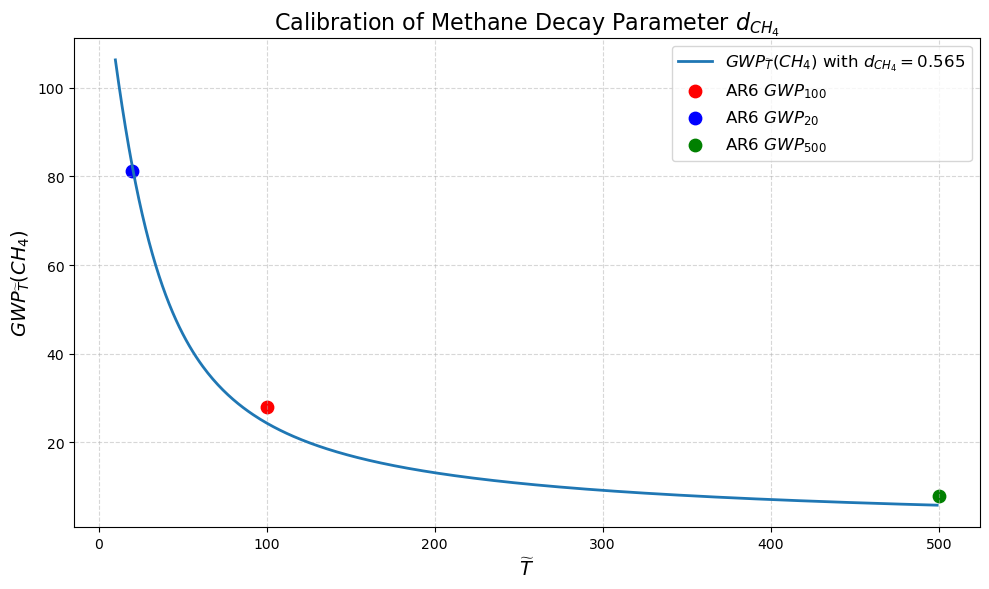

In [63]:
# -----------------------------------------------------------
# GWP(T̃) curve + AR6 calibration points
# -----------------------------------------------------------

plt.figure(figsize=(10,6))

# Plot calibrated continuous GWP curve
plt.plot(
    T_Tildes, 
    GWPS, 
    label=rf'$GWP_{{\widetilde{{T}}}}(CH_4)$ with $d_{{CH_4}} = {d_CH4_optimal:.3f}$',
    linewidth=2
)

# Colors for 20, 100, 500-year AR6 points
colors = ['red', 'blue', 'green']

# AR6: 100-year (index 0)
plt.scatter(
    years.iloc[0], gwp_values.iloc[0],
    color=colors[0], s=80,
    label=r"AR6 $GWP_{100}$"
)

# AR6: 20-year (index 1)
plt.scatter(
    years.iloc[1], gwp_values.iloc[1],
    color=colors[1], s=80,
    label=r"AR6 $GWP_{20}$"
)

# AR6: 500-year (index 2)
plt.scatter(
    years.iloc[2], gwp_values.iloc[2],
    color=colors[2], s=80,
    label=r"AR6 $GWP_{500}$"
)

# -----------------------------------------------------------
# Plot formatting
# -----------------------------------------------------------

plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel(r"$\widetilde{T}$", fontsize=14)
plt.ylabel(r"$GWP_{\widetilde{T}}(CH_4)$", fontsize=14)
plt.title("Calibration of Methane Decay Parameter $d_{CH_4}$", fontsize=16)

plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig("dCH4Calibrations_NEW.png", bbox_inches='tight', facecolor='w', dpi=300)
plt.show()


In [66]:
###############################################     Radiative forcing      ################################################

# Radiative forcing under abatement
R, f_values = R_All(
    E  = emissions,
    dt = dt_T,
    adj = adj,
    d   = d_CH4_optimal
)

# Radiative forcing when b^j = 0
R_bnull, f_values = R_All(
    E  = emissions_bnull,
    dt = dt_T,
    adj = adj,
    d   = d_CH4_optimal
)

# Radiative forcing under Business-As-Usual
R_BAU, f_values = R_All(
    E  = emissions_BAU,
    dt = dt_T,
    adj = adj,
    d   = d_CH4_optimal
)


Processing key: 0
Processing key: 1
Processing key: 0
  Scenario 1/4
    Horizon 1/4: time step 0/26
    Horizon 1/4: time step 10/26
    Horizon 1/4: time step 20/26
    Horizon 2/4: time step 0/100
    Horizon 2/4: time step 10/100
    Horizon 2/4: time step 20/100
    Horizon 2/4: time step 30/100
    Horizon 2/4: time step 40/100
    Horizon 2/4: time step 50/100
    Horizon 2/4: time step 60/100
    Horizon 2/4: time step 70/100
    Horizon 2/4: time step 80/100
    Horizon 2/4: time step 90/100
    Horizon 3/4: time step 0/250
    Horizon 3/4: time step 10/250
    Horizon 3/4: time step 20/250
    Horizon 3/4: time step 30/250
    Horizon 3/4: time step 40/250
    Horizon 3/4: time step 50/250
    Horizon 3/4: time step 60/250
    Horizon 3/4: time step 70/250
    Horizon 3/4: time step 80/250
    Horizon 3/4: time step 90/250
    Horizon 3/4: time step 100/250
    Horizon 3/4: time step 110/250
    Horizon 3/4: time step 120/250
    Horizon 3/4: time step 130/250
    Horizon 3/4

In [67]:
##################################################      Temperature      ##################################################

# Radiative forcing
print("-" * columns)

display(Math(r"\text{For the temperature impact we have the formula:}"))
display(Math(r"I^a(t)=\frac{1}{C}\left(R^a(t)-\alpha\int_0^te^{-\alpha(t-s)}R^a(s)ds\right)"))
display(Math(r"\text{letting:}"))
display(Math(r"\alpha=\lambda/C"))

def compute_Ia(Ra, lambd, C, dt=1):
    """
    Computes temperature impact I^a(t) from radiative forcing R^a(t).

    Parameters:
        Ra (dict): radiative forcing dictionary { "0": array, "1": array }
        lambd (float): climate feedback parameter λ
        C (float): heat capacity parameter C
        dt (float): time step (defaults to 1 but dt_T should be passed)

    Returns:
        Ia (dict): temperature impact dictionary
    """
    
    Ia = {}
    alpha = lambd / C

    for key in Ra.keys():
        R_arr = Ra[key]
        T = len(R_arr)

        Ia[key] = np.zeros(T)
        kernel = np.exp(-alpha * np.arange(T))  # e^{-alpha * k}

        # Convolution: integral_0^t e^{-α(t-s)} R(s) ds
        conv = np.convolve(R_arr, kernel, mode='full')[:T] * dt

        Ia[key] = (1 / C) * (R_arr - alpha * conv)

    return Ia


--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
############################################      The temperature index      ##############################################

# Formula recap (paper-consistent LaTeX)
display(Math(r"\text{As discussed earlier, we have the temperature index at time }t\text{ as:}"))
display(Math(r"I^{\textbf{a}}(t)=\frac{1}{C}\left(R^{\textbf{a}}(t)-\alpha\!\int_0^t e^{-\alpha(t-s)} R^{\textbf{a}}(s)\,ds\right)"))
display(Math(r"\text{letting } \alpha=\lambda/C"))
display(Math(r"\text{Thus at regulator's horizon } \widetilde{T}:"))
display(Math(r"I^{\textbf{a}}(\widetilde{T})=\frac{1}{C}\Big(R^{\textbf{a}}(\widetilde{T})-\alpha\!\int_0^{\widetilde{T}} e^{-\alpha(\widetilde{T}-s)}R^{\textbf{a}}(s)\,ds\Big)"))
display(Math(r"R^{\textbf{a}}(\widetilde{T})=\sum_{ij}R_{ij}^{\textbf{a}}(\widetilde{T})"))
display(Math(r"\text{If }R^{\textbf{a}}\text{ is a semimartingale, then: }"))
display(Math(r"I^{\textbf{a}}(\widetilde{T})=\frac{1}{C}\int_0^{\widetilde{T}} e^{\alpha(s-\widetilde{T})}\, dR^{\textbf{a}}(s)"))
display(Math(r"\text{The temperature bound becomes } U \le U_0\text{ where:}"))
display(Math(r"""
U_0 := \sum_j N^j \bar{\mu}^j \int_0^{\widetilde{T}} \!ds\, e^{\lambda(s-\widetilde{T})}
   \int_0^{T\wedge s}\! f^j(u-s)\,du
"""))

display(Math(r"\text{And in our model: }"))
display(Math(r"""
\mathbb{E}[\hat{I}(\widetilde{T})]
  = U = \sum_j N^j\left(\bar{\mu}^j+\bar{c}^j-\hat{P}_j(0)\right)
     \int_0^{\widetilde{T}} e^{\alpha(s-\widetilde{T})}
        \int_0^{T\wedge s} f^j(u-s)\,ds\,du
"""))

print("-" * columns)


############################################      Temperature index code      ##############################################

def Temp(T_firm, T_regulator, N, mu_bar, c_bar, eta_bar, P_hat_0,
         y_bnull, lambda_, mu_mix, d, adj):
    """
    Compute the *expected* temperature index U and U0 at horizon T_regulator.

    This implements exactly the formulas from the paper:
      - integrals over the CO₂ kernel f_CO2
      - integrals over the CH₄ kernel f_OtherGas
      - analytical expectation expressions (NOT simulated temperature path)

    Parameters
    ----------
    T_firm: float
        Firm-level horizon T from the model.
    T_regulator: list
        Regulator horizons \widetilde{T}.
    N: int
        Number of firms (1 in your one-firm-per-sector case).
    mu_bar, c_bar, eta_bar: dict
        Deterministic sector parameters.
    P_hat_0: dict
        Initial abatement prices \hat{P}_j(0).
    y_bnull: dict
        Null-case results (not used directly here but required for consistency).
    lambda_: float
        Climate feedback parameter.
    mu_mix: float
        Heat capacity parameter C.
    d: float
        Decay constant for CH4 kernel.
    adj: float
        Unit adjustment factor.

    Returns
    -------
    results_E, results_U : lists
        Expected temperature index U and baseline U0 for each \tilde{T}.
    """

    # α = λ / C
    alpha = lambda_ / mu_mix

    results_E, results_U = [], []

    # --- Define the CO₂ and CH₄ kernels -----------------------------------

    def f_CO2(u_s,
              d1=0.004223 * 0.27218,
              d2=0.004223 * 0.14621,
              d3=0.004223 * 0.13639,
              d4=0.004223 * 0.44422):
        """Pierrehumbert-style multi-exponential kernel for CO₂."""
        return d1*np.exp(u_s/8.696) + d2*np.exp(u_s/93.33) \
             + d3*np.exp(u_s/645.87) + d4

    def f_OtherGas(u_s, d, tau_gas=tau_CH4):
        """Single exponential decay kernel for CH₄ (or other gas)."""
        return d * np.exp(u_s / tau_gas)

    # ------------------------------------------------------------------------
    # Main loop over regulator horizons \widetilde{T}
    # ------------------------------------------------------------------------

    for k in range(len(T_regulator)):

        # ------ Inner integrands used by quad --------------------------------

        def integrand_inner_CO2(u, s):
            # u - s ≤ 0 always
            return f_CO2(u - s)

        def integrand_inner_CH4(u, s):
            return f_OtherGas(u - s, d=d)

        # ------ Outer integrands (s-loop) ------------------------------------

        def integrand_outer_CO2(s):
            return np.exp(alpha * (s - T_regulator[k])) \
                * quad(integrand_inner_CO2, 0, min(T_firm, s), args=(s,))[0]

        def integrand_outer_CH4(s):
            return np.exp(alpha * (s - T_regulator[k])) \
                * quad(integrand_inner_CH4, 0, min(T_firm, s), args=(s,))[0]

        # The REG-temperature integral for CO₂ and CH₄:
        term_CO2 = quad(integrand_outer_CO2, 0, T_regulator[k])[0]
        term_CH4 = quad(integrand_outer_CH4, 0, T_regulator[k])[0]

        # ----------------------------------------------------------------------
        # Case 1: multiple combinations (lists)
        # ----------------------------------------------------------------------
        if isinstance(c_bar["0"], list):

            result_inner_E, result_inner_U = [], []

            for j in range(len(c_bar["0"])):
                result_E, result_U = 0, 0

                # Loop over sectors j = "0","1"
                for dic in mu_bar.keys():

                    # dic = "0" → CO₂, dic = "1" → CH₄
                    if int(dic) % 2 == 0:
                        term_2 = term_CO2
                    else:
                        term_2 = term_CH4

                    # Contribution to U
                    contribution_E = N * (
                        (mu_bar[dic]*adj)
                        + c_bar[dic][j]
                        - eta_bar[dic][j][1] * P_hat_0[dic][j][0][0]
                    )/adj * term_2

                    contribution_U = N * (mu_bar[dic]*adj)/adj * term_2

                    result_E += contribution_E
                    result_U += contribution_U

                # accumulate for this j
                result_inner_E.append(result_E)
                result_inner_U.append(result_U)

            # accumulate across regulator horizons
            results_E.append(result_inner_E)
            results_U.append(result_inner_U)

        # ----------------------------------------------------------------------
        # Case 2: scalar (not list)
        # ----------------------------------------------------------------------
        else:
            result_E, result_U = 0, 0

            for dic in mu_bar.keys():

                if int(dic) % 2 == 0:
                    term_2 = term_CO2
                else:
                    term_2 = term_CH4

                result_E += N * (
                    (mu_bar[dic]*adj) + c_bar[dic]
                    - eta_bar[dic] * P_hat_0[dic][0][0]
                )/adj * term_2

                result_U += N * (mu_bar[dic]*adj)/adj * term_2

            results_E.append(result_E)
            results_U.append(result_U)

    return results_E, results_U

# Display final regulator optimization text
display(Math(r"\text{We know that the regulator's objective function is:}"))
display(Math(r"""
\begin{align}
\inf_{\mathcal{D}}
  \sum_{j=1}^K \frac{\bar{\eta}^j}{2}
  \int_{0}^{T} \left\{
     \int_0^t \frac{2y^j}{1+2y^j\bar{\eta}^j(T-s)}
     (\sigma^j(s))^2\, ds
  \right\}dt
  + \frac{\bar{\eta}^j}{2}\hat{P}_j^2(0)T
  -\frac{\bar{\nu}^j T}{2}
\end{align}
"""))

display(Math(r"\text{subject to } \mathbb{E}[\hat{I}(\widetilde{T})] \le U."))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------------------------------------------------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

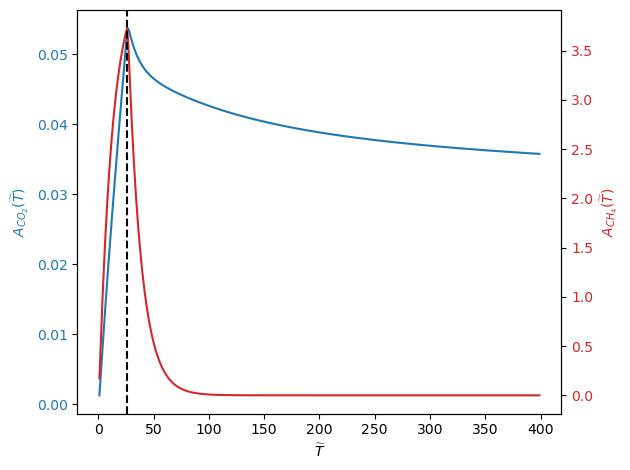

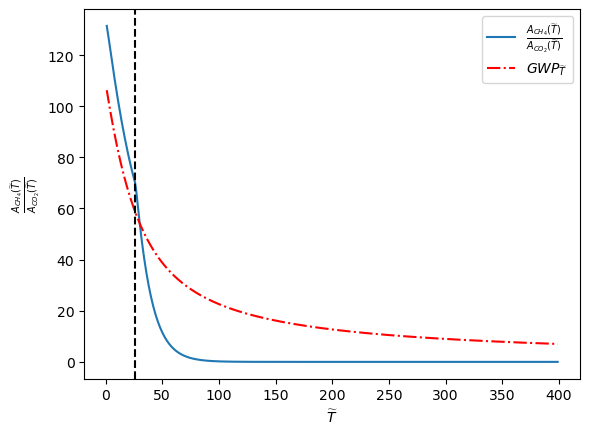

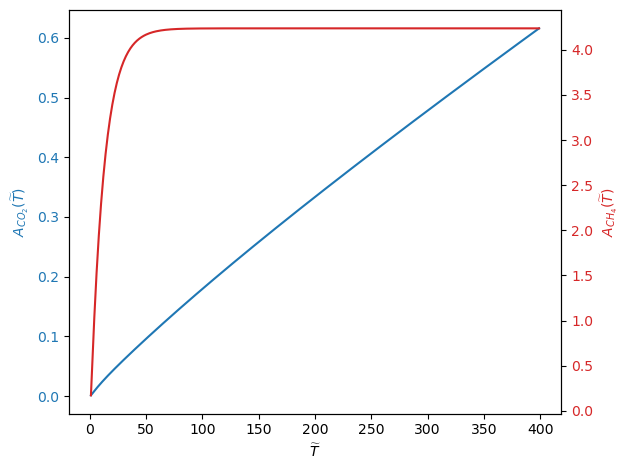

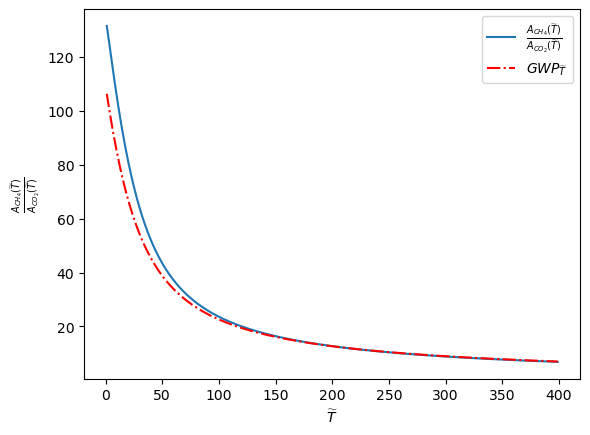

In [72]:
############################################      Annuity Factor codes       ##############################################

display(Math(r"\text{For the annuity factor quantifying temperature impact over horizon } \widetilde{T}:"))

display(Math(r"""
\begin{equation}
A_j(\widetilde{T}):=A_j(\widetilde{T};\alpha, f_j,T):=\int_0^{\widetilde{T}} e^{\alpha(s-\widetilde{T})}
\left(\int_{0}^{T\wedge s} f_j(v-s)\,dv\right)\,ds
\end{equation}
"""))

# CH4 kernel scale calibrated earlier
d_CH4 = d_CH4_optimal


def Annuity(T_firm, T_regulator, lambda_, mu_mix, d, mu, TTilde=False):
    """
    Compute annuity factors A_j(\widetilde{T}) for CO2 (j=1) and CH4 (j=2),
    and their BAU-scaled versions.

    Parameters
    ----------
    T_firm : float
        Firm’s time horizon T in the model.
    T_regulator : array-like
        Sequence of regulator horizons \widetilde{T}.
    lambda_ : float
        Climate feedback parameter λ.
    mu_mix : float
        Heat capacity / mixing parameter C (used via α = λ / C).
    d : float
        Scale parameter for CH4 decay kernel.
    mu : dict
        Drift parameters mu["0"] for CO2 and mu["1"] for CH4.
    TTilde : bool, default False
        If False:
            A_j(\widetilde{T}) uses inner limit T∧s with T = T_firm.
        If True:
            A_j(\widetilde{T}) uses inner limit \widetilde{T}∧s.

    Returns
    -------
    results_T_CO2, results_T_CH4, results_T_CO2_BAU, results_T_CH4_BAU : list
        A_CO2, A_CH4 and their BAU-scaled analogues for each \widetilde{T}.
    """

    # α = λ / C
    alpha = lambda_ / mu_mix

    # Store annuities and BAU-scaled versions
    results_T_CO2, results_T_CH4 = [], []
    results_T_CO2_BAU, results_T_CH4_BAU = [], []

    # CO2 kernel (Pierrehumbert style multi-exponential)
    def f_CO2(u_s,
              d1=0.004223 * 0.27218,
              d2=0.004223 * 0.14621,
              d3=0.004223 * 0.13639,
              d4=0.004223 * 0.44422):
        return (d1 * np.exp(u_s / 8.696)
              + d2 * np.exp(u_s / 93.33)
              + d3 * np.exp(u_s / 645.87)
              + d4)

    # Single-exponential kernel for CH4
    def f_OtherGas(u_s, d_local, tau_gas=tau_CH4):
        return d_local * np.exp(u_s / tau_gas)

    # Loop over regulator horizons \widetilde{T}
    for k in range(len(T_regulator)):

        # Decide inner integration limit: T∧s with T = T_firm or T = \widetilde{T}
        if TTilde is False:
            inner_T = T_firm
        else:
            inner_T = T_regulator[k]

        # ---------- CO2 part (j = 1) -------------------------------------

        def integrand_inner_CO2(u, s):
            # u - s ≤ 0 always
            return f_CO2(u - s)

        def integrand_outer_CO2(s):
            # exp(α (s - \tilde{T})) ∫_0^{T∧s} f_CO2(v-s) dv
            return np.exp(alpha * (s - T_regulator[k])) * quad(
                integrand_inner_CO2,
                0,
                min(inner_T, s),
                args=(s,)
            )[0]

        term_2_CO2 = quad(integrand_outer_CO2, 0, T_regulator[k])[0]

        result_CO2     = term_2_CO2                 # pure annuity factor A_CO2
        result_CO2_BAU = mu["0"] * term_2_CO2      # A_CO2 scaled by CO2 drift

        results_T_CO2.append(result_CO2)
        results_T_CO2_BAU.append(result_CO2_BAU)

        # ---------- CH4 part (j = 2) -------------------------------------

        def integrand_inner_CH4(u, s, d_local):
            return f_OtherGas(u - s, d_local)

        def integrand_outer_CH4(s):
            return np.exp(alpha * (s - T_regulator[k])) * quad(
                integrand_inner_CH4,
                0,
                min(inner_T, s),
                args=(s, d)
            )[0]

        term_2_CH4 = quad(integrand_outer_CH4, 0, T_regulator[k])[0]

        result_CH4     = term_2_CH4                 # pure annuity factor A_CH4
        result_CH4_BAU = mu["1"] * term_2_CH4      # A_CH4 scaled by CH4 drift

        results_T_CH4.append(result_CH4)
        results_T_CH4_BAU.append(result_CH4_BAU)

    return results_T_CO2, results_T_CH4, results_T_CO2_BAU, results_T_CH4_BAU


# Long horizon for plotting annuity factors and ratios
Long_T = np.arange(1, 400)

# Annuity with inner limit T∧s, T = T_firm
Annuity_results = Annuity(
    T_firm=T,
    T_regulator=Long_T,
    lambda_=lamda,
    mu_mix=mu_mix,
    mu=mu,
    d=d_CH4
)

# Annuity with inner limit \widetilde{T}∧s
Annuity_results_TTilde = Annuity(
    T_firm=T,
    T_regulator=Long_T,
    lambda_=lamda,
    mu_mix=mu_mix,
    mu=mu,
    d=d_CH4,
    TTilde=True
)


# ============================================================
# Plot A_CO2 and A_CH4 (inner limit T∧s, T = T_firm)
# ============================================================

fig, ax1 = plt.subplots()

color1 = 'tab:blue'
ax1.set_xlabel(r'$\widetilde{T}$')
ax1.set_ylabel(r'$A_{CO_2}(\widetilde{T})$', color=color1)
ax1.plot(Long_T, Annuity_results[0], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Second y-axis for CH4
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel(r'$A_{CH_4}(\widetilde{T})$', color=color2)
ax2.plot(Long_T, Annuity_results[1], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Mark \widetilde{T} = 26 (for your focal horizon)
ax2.axvline(x=26, linestyle="--", color="black")

fig.tight_layout()
plt.savefig('AnnuityFactor_Twin.png', bbox_inches='tight', dpi=300)
plt.show()

# Ratio A_CH4 / A_CO2 and comparison to calibrated GWP_{\tilde{T}}

ratio = list(np.array(Annuity_results[1]) / np.array(Annuity_results[0]))

plt.plot(Long_T, ratio,
         label=r'$\frac{A_{CH_4}(\widetilde{T})}{A_{CO_2}(\widetilde{T})}$')
plt.plot(Long_T, GWPS[:399],
         color="red",
         label=r"$GWP_{\widetilde{T}}$",
         linestyle="-.")
plt.xlabel(r'$\widetilde{T}$')
plt.axvline(x=26, linestyle="--", color="black")
plt.legend()
plt.ylabel(r'$\frac{A_{CH_4}(\widetilde{T})}{A_{CO_2}(\widetilde{T})}$')
plt.savefig('AnnuityRatio_Twin_NEW.png', bbox_inches='tight', dpi=300)
plt.show()


# ============================================================
# Same plots but with inner limit \widetilde{T}∧s
# ============================================================

fig, ax1 = plt.subplots()

color1 = 'tab:blue'
ax1.set_xlabel(r'$\widetilde{T}$')
ax1.set_ylabel(r'$A_{CO_2}(\widetilde{T})$', color=color1)
ax1.plot(Long_T, Annuity_results_TTilde[0], color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel(r'$A_{CH_4}(\widetilde{T})$', color=color2)
ax2.plot(Long_T, Annuity_results_TTilde[1], color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.savefig('AnnuityFactor_Twin_TTilde_NEW.png', bbox_inches='tight', dpi=300)
plt.show()

ratio_TTilde = list(
    np.array(Annuity_results_TTilde[1]) / np.array(Annuity_results_TTilde[0])
)

plt.plot(Long_T, ratio_TTilde,
         label=r'$\frac{A_{CH_4}(\widetilde{T})}{A_{CO_2}(\widetilde{T})}$')
plt.plot(Long_T, GWPS[:399],
         color="red",
         label=r"$GWP_{\widetilde{T}}$",
         linestyle="-.")
plt.xlabel(r'$\widetilde{T}$')
plt.ylabel(r'$\frac{A_{CH_4}(\widetilde{T})}{A_{CO_2}(\widetilde{T})}$')
plt.legend()
plt.savefig('AnnuityRatio_Twin_TTilde_NEW.png', bbox_inches='tight', dpi=300)
plt.show()


## Checkpoint

In [74]:
#############################################   Saving simulation outputs   #############################################

# We save each simulated object into a separate pickle file.
# This allows loading them quickly later without recomputation.
# All variable names remain exactly as originally defined.

# Save Brownian motions
with open(REPO_ROOT / 'Pickle Files' / 'WSimul.pkl', 'wb') as pickle_file:
    pickle.dump(W, pickle_file)

# Save drift parameters μ_j
with open(REPO_ROOT / 'Pickle Files' / 'MuSimul.pkl', 'wb') as pickle_file:
    pickle.dump(mu, pickle_file)

# Save unadjusted μ_j (if used for diagnostics or comparisons)
with open(REPO_ROOT / 'Pickle Files' / 'MuSimulUnadjusted.pkl', 'wb') as pickle_file:
    pickle.dump(mu_Unadjusted, pickle_file)

# Save volatility processes σ_j (or standard deviations)
with open(REPO_ROOT / 'Pickle Files' / 'StdSimul.pkl', 'wb') as pickle_file:
    pickle.dump(std, pickle_file)

# Save unadjusted σ_j
with open(REPO_ROOT / 'Pickle Files' / 'StdSimulUnadjusted.pkl', 'wb') as pickle_file:
    pickle.dump(std_Unadjusted, pickle_file)

# Save η parameters (the 2D abatement cost elasticity parameters)
with open(REPO_ROOT / 'Pickle Files' / 'EtaSimul.pkl', 'wb') as pickle_file:
    pickle.dump(eta, pickle_file)

# Save baseline h parameters
with open(REPO_ROOT / 'Pickle Files' / 'hSimul.pkl', 'wb') as pickle_file:
    pickle.dump(h, pickle_file)

# Save ε_min (the minimum admissible emission-reduction intensity)
with open(REPO_ROOT / 'Pickle Files' / 'EpsSimul.pkl', 'wb') as pickle_file:
    pickle.dump(epsilon_min, pickle_file)


In [3]:
#############################################   Loading saved simulation objects   #############################################

# We reload all objects exactly as they were saved.  
# This allows the notebook to resume work without rerunning heavy simulations.

# Load Brownian motions W_t^{(j)}
with open(REPO_ROOT / 'Pickle Files' / 'WSimul.pkl', 'rb') as pickle_file:
    W = pickle.load(pickle_file)

# Load drift parameters μ_j
with open(REPO_ROOT / 'Pickle Files' / 'MuSimul.pkl', 'rb') as pickle_file:
    mu = pickle.load(pickle_file)

# Load unadjusted μ_j (used for diagnostics, e.g. before applying adj)
with open(REPO_ROOT / 'Pickle Files' / 'MuSimulUnadjusted.pkl', 'rb') as pickle_file:
    mu_Unadjusted = pickle.load(pickle_file)

# Load volatility processes σ_j (or standard deviations)
with open(REPO_ROOT / 'Pickle Files' / 'StdSimul.pkl', 'rb') as pickle_file:
    std = pickle.load(pickle_file)

# Load unadjusted σ_j
with open(REPO_ROOT / 'Pickle Files' / 'StdSimulUnadjusted.pkl', 'rb') as pickle_file:
    std_Unadjusted = pickle.load(pickle_file)

# Load η parameters (abatement cost elasticities)
with open(REPO_ROOT / 'Pickle Files' / 'EtaSimul.pkl', 'rb') as pickle_file:
    eta = pickle.load(pickle_file)

# Load baseline h parameters
with open(REPO_ROOT / 'Pickle Files' / 'hSimul.pkl', 'rb') as pickle_file:
    h = pickle.load(pickle_file)


## Optimization
⚠ **Note:**  
The optimization routines shown below (grid search and stochastic-gradient versions) are **not meant to be executed inside this main notebook**.  
They are included **only as function definitions** so that the theoretical pipeline is complete and the codebase is self-contained.

The *actual* execution of the optimization procedures is done separately in:

- **`Optimize_GridSearch.ipynb`** — for the full grid-search–based optimization.  
- **`Optimize_SGD.ipynb`** — for the stochastic-gradient–based optimization.

This separation ensures:
- faster development and debugging,
- avoids accidental long-running computations,
- keeps the main notebook clean and replicable.

Please refer to those notebooks to run the optimization loops or experiments.
or experiments.


In [83]:
############################################        Optimization (code)       ##############################################

# Load simulated Brownian motions (if not already loaded)
with open('WSimul.pkl', 'rb') as pickle_file:
    W = pickle.load(pickle_file)


def Optimization(
    mu_opt,           # dict: optimal drifts μ^j (possibly post-adjustment)
    c,                # dict: c^j parameters
    nu,               # dict: ν^j (cost offset)
    std,              # dict: σ^j(t) volatility levels
    W,                # dict: Brownian paths, structure as in earlier code
    T,                # float: firm’s horizon T
    T_tilde,          # float: regulator’s horizon \tilde{T}
    eta,              # dict: η^j abatement elasticities
    delta,            # dict: δ^j (retention rate, used in max b grid)
    eps,              # float: target tracking-error / norm bound ε
    y_initial_guess,  # float: initial guess for Lagrange multiplier y
    lambda_,          # float: climate feedback parameter λ
    gamma_,           # float: exponential decay rate for volatility term
    U,                # float: temperature constraint threshold U
    ul=20,            # int: number of grid points per b-dimension
    d=d_CH4,          # float: calibrated d_CH4 from GWP calibration
    adj=1e9           # float: scaling factor (Gt ↔ tonnes, etc.)
):
    """
    Grid over (b_1, b_2), solve for y^j, equilibrium prices P_j(0),
    compute social cost, and impose the temperature constraint E_U <= U.

    Returns
    -------
    Constrained_results : DataFrame
        Rows corresponding to (b_1, b_2) that satisfy the temperature constraint.
    Also writes:
        - 'Constrained_results_{U}_{T_tilde}.pkl'
        - 'Unconstrained_results_{U}_{T_tilde}.pkl'
    """

    # ----------------------------------------------------------------------------------
    # 1. Grid over b_j in [0, (1 - δ_j)*(μ_j + c_j/adj)*T)
    # ----------------------------------------------------------------------------------
    def b1bkGrid(mu, c, T, delta, ul=20, adj=1e9):
        """
        Build a Cartesian grid over b_j for all sectors j.

        b_j ∈ [0, (1 - δ_j)*(μ_j + c_j/adj)*T), with ul points (endpoint=False).
        """
        max_, x_ = {}, {}
        for key in mu.keys():
            max_[key] = (1 - delta[key]) * (mu[key] + c[key] / adj) * T
            x_[key] = np.linspace(0, max_[key], ul, endpoint=False)

        # Cartesian product of all b_j grids
        x_values = [x_[key] for key in mu.keys()]
        grids = np.meshgrid(*x_values, indexing='ij')
        cartesian_prod = np.stack([grid.flatten() for grid in grids], axis=-1)
        return cartesian_prod

    # ----------------------------------------------------------------------------------
    # 2. Solve for the Lagrange multipliers y^j from the norm constraint
    # ----------------------------------------------------------------------------------
    def solveY(W, std, T, eta, mu, c, adj, eps, b, y_initial_guess, gamma_, combinations=None):
        """
        For each sector j, solve for y^j such that

            (P_j(0))^2 + ∫_0^T (σ_j(t) adj e^{-γ t})^2 / (1 + 2 y^j η^j (T - t))^2 dt = ε^2

        where
            P_j(0) = 2 y^j ( ( (μ_j adj + c_j) T - b_j adj ) / (1 + 2 y^j η^j T ) ).
        """

        # Count number of sectors from W structure (Sector* keys under gas "1")
        sectors = 0
        for key in W["1"].keys():
            if key.startswith("Sector"):
                sectors += 1  

        y = {}
        if isinstance(std, dict):
            for i in range(sectors):

                def integrand(t, y_local):
                    vol = (std[f"{i}"] * adj) * np.exp(-gamma_ * t)
                    return (vol ** 2) / (1 + 2 * y_local * eta[f"{i}"] * (T - t)) ** 2

                def equation(y_local):
                    integral_result, _ = quad(integrand, 0, T, args=(y_local,))
                    term_1 = (((mu[f"{i}"] * adj + c[f"{i}"]) * T) - (b[f"{i}"] * adj)) / (1 + (2 * y_local * eta[f"{i}"] * T))
                    return (term_1 ** 2) + integral_result - (eps ** 2)

                sol = root(equation, y_initial_guess)
                if sol.success:
                    y[f"{i}"] = sol.x[0]
                else:
                    print(f"Solver failed to converge for sector {i}")
                    y[f"{i}"] = None

        return y

    # ----------------------------------------------------------------------------------
    # 3. Price function P_j(0) given y^j and b_j
    # ----------------------------------------------------------------------------------
    def Pricing(y, mu, c, T, b, eta, adj=1e9):
        """
        Compute equilibrium carbon prices:

            P_j(0) = \frac{2 y^j ((μ^j adj + c^j)T - b^j adj)}{1 + 2 y^j η^j T}.
        """
        P_null = {}
        for key in y.keys():
            P_null[key] = (
                2 * y[key] * (((mu[key] * adj) + c[key]) * T - (b[key] * adj))
            ) / (1 + 2 * y[key] * eta[key] * T)
        return P_null

    # ----------------------------------------------------------------------------------
    # 4. Social cost functional J given y^j and P_j(0)
    # ----------------------------------------------------------------------------------
    def socialCost(T, std, y, eta, nu, P, adj=1e9):
        """
        Social cost:

            J = ∑_j [ (η^j / 2) ∫_0^T ∫_0^t ... ds dt
                      + (η^j / 2) P_j(0)^2 T
                      - (ν^j / 2) T ].

        The nested integrals encode the diffusion contribution as in the paper.
        """

        def inner_integrand(s, y_local, eta_local, T, adj_local, std_local):
            vol = (std_local * adj_local) * np.exp(-gamma_ * s)
            return (vol ** 2) / (1 + 2 * y_local * eta_local * (T - s)) ** 2

        def outer_integrand(t, y_local, eta_local, T, adj_local, std_local):
            inner_result, _ = quad(inner_integrand, 0, t,
                                   args=(y_local, eta_local, T, adj_local, std_local))
            return inner_result

        result = 0.0
        for key in y:
            outer_result, _ = quad(
                outer_integrand, 0, T,
                args=(y[key], eta[key], T, adj, std[key])
            )
            result += (
                (eta[key] / 2) * outer_result
                + (eta[key] / 2) * (P[key] ** 2) * T
                - (nu[key] / 2) * T
            )

        return result

    # ----------------------------------------------------------------------------------
    # 5. Temperature index constraint E[Ĩ(\tilde{T})] <= U
    # ----------------------------------------------------------------------------------
    def Temp(T_firm, T_regulator, N, mu_bar, c_bar, eta_bar, P_hat_0, y_bnull,
             lambda_, mu_mix, d, adj):
        """
        Compute:
            U  = ∑_j N * (μ̄^j adj + c̄^j - η̄^j P̂_j(0)) / adj * A_j(\tilde{T})
            U0 = ∑_j N * μ̄^j * A_j(\tilde{T})

        where A_j(\tilde{T}) is the annuity factor with kernel f^j and α = λ / μ_mix.
        """

        alpha = lambda_ / mu_mix

        # CO2 kernel
        def f_CO2(u_s,
                  d1=0.004223 * 0.27218,
                  d2=0.004223 * 0.14621,
                  d3=0.004223 * 0.13639,
                  d4=0.004223 * 0.44422):
            return (
                d1 * np.exp(u_s / 8.696)
                + d2 * np.exp(u_s / 93.33)
                + d3 * np.exp(u_s / 645.87)
                + d4
            )

        # CH4 kernel
        def f_OtherGas(u, d_local=d, tau_gas=tau_CH4):
            return d_local * np.exp(u / tau_gas)

        def integrand_inner_CO2(u, s):
            return f_CO2(u - s)

        def integrand_inner_CH4(u, s, d_local):
            return f_OtherGas(u - s, d_local)

        def integrand_outer_CO2(s):
            return np.exp(alpha * (s - T_regulator)) * quad(
                integrand_inner_CO2, 0, min(T_firm, s), args=(s,)
            )[0]

        def integrand_outer_CH4(s):
            return np.exp(alpha * (s - T_regulator)) * quad(
                integrand_inner_CH4, 0, min(T_firm, s), args=(s, d)
            )[0]

        # Temperature indices
        result_E, result_U = 0.0, 0.0

        for dic in mu_bar.keys():

            if (int(dic) % 2) == 0:  # Even index → CO2

                term_2 = quad(integrand_outer_CO2, 0, T_regulator)[0]

                result_E += (
                    N * ((mu_bar[dic] * adj) + c_bar[dic] - (eta_bar[dic] * P_hat_0[dic])) / adj
                    * term_2
                )
                Temp_1_E = (
                    N * ((mu_bar[dic] * adj) + c_bar[dic] - (eta_bar[dic] * P_hat_0[dic])) / adj
                    * term_2
                )

                result_U += N * mu_bar[dic] * term_2
                Temp_1_U = N * mu_bar[dic] * term_2

            else:  # Odd index → CH4

                term_2 = quad(integrand_outer_CH4, 0, T_regulator)[0]

                result_E += (
                    N * ((mu_bar[dic] * adj) + (c_bar[dic] - (eta_bar[dic] * P_hat_0[dic]))) / adj
                    * term_2
                )
                Temp_2_E = (
                    N * ((mu_bar[dic] * adj) + (c_bar[dic] - (eta_bar[dic] * P_hat_0[dic]))) / adj
                    * term_2
                )

                result_U += N * (mu_bar[dic] * adj) / adj * term_2
                Temp_2_U = N * (mu_bar[dic] * adj) / adj * term_2

        return result_E, result_U

    # ----------------------------------------------------------------------------------
    # 6. Build grid and loop over all (b_0, b_1)
    # ----------------------------------------------------------------------------------
    b_grid = b1bkGrid(mu=mu_opt, c=c, T=T, delta=delta, ul=ul, adj=adj)

    # Storage for constrained (temperature-feasible) and unconstrained solutions
    J_constrained = []
    grid_constrained_df = []
    prices_constrained_df = []
    y_constrained_df = []

    J = []
    grid_df = []
    prices_df = []
    y_df = []
    Temps_list = []

    # NOTE: N and mu_mix are expected to be defined in the outer scope
    for i in range(len(b_grid)):
        timer = np.round((i / len(b_grid)) * 100)
        grid = {"0": b_grid[i][0], "1": b_grid[i][1]}

        # Solve for Lagrange multipliers y^j given this b-grid point
        y = solveY(
            W=W, std=std, T=T, eta=eta, mu=mu_opt, c=c,
            adj=adj, eps=eps, b=grid, y_initial_guess=y_initial_guess,
            gamma_=gamma_
        )

        # Check sign of y^j (necessary conditions)
        for key in y.keys():
            if y[key] is not None and y[key] < 0:
                print(f"The Lagrange multiplier for sector {key} at b={grid[key]} is less than 0!")

        # Prices P_j(0)
        Null_prices = Pricing(y=y, mu=mu_opt, c=c, T=T, b=grid, eta=eta, adj=adj)

        # Temperature index at \tilde{T}
        E_U, U_U = Temp(
            T_firm=T,
            T_regulator=T_tilde,
            N=N,
            mu_bar=mu_opt,
            c_bar=c,
            eta_bar=eta,
            P_hat_0=Null_prices,
            y_bnull=y,
            lambda_=lambda_,
            mu_mix=mu_mix,
            d=d,
            adj=adj
        )

        sys.stdout.write(f"\r Grid loop: {timer}% and the expected terminal temperature is {E_U}!")
        sys.stdout.flush()

        # If temperature constraint is satisfied, store in constrained set
        if E_U <= U:
            J_constrained.append(
                socialCost(T=T, std=std, y=y, eta=eta, nu=nu, P=Null_prices, adj=adj)
            )
            grid_constrained_df.append([grid["0"], grid["1"]])
            prices_constrained_df.append([Null_prices["0"], Null_prices["1"]])
            y_constrained_df.append([y["0"], y["1"]])

        # Store unconstrained (full grid) results
        J.append(socialCost(T=T, std=std, y=y, eta=eta, nu=nu, P=Null_prices, adj=adj))
        grid_df.append([grid["0"], grid["1"]])
        prices_df.append([Null_prices["0"], Null_prices["1"]])
        y_df.append([y["0"], y["1"]])
        Temps_list.append(E_U)

    # ----------------------------------------------------------------------------------
    # 7. Organise into DataFrames and write to disk
    # ----------------------------------------------------------------------------------
    J_constrained_df = pd.DataFrame(J_constrained)
    grid_constrained_df = pd.DataFrame(grid_constrained_df)
    prices_constrained_df = pd.DataFrame(prices_constrained_df)
    y_constrained_df = pd.DataFrame(y_constrained_df)

    J_df = pd.DataFrame(J)
    grid_df = pd.DataFrame(grid_df)
    prices_df = pd.DataFrame(prices_df)
    y_df = pd.DataFrame(y_df)
    Temps_df = pd.DataFrame(Temps_list)

    # One c/ν table reused for both constrained and unconstrained outputs
    c_df = pd.DataFrame(list(c.items()), columns=['Key', 'c'])
    nu_df = pd.DataFrame(list(nu.items()), columns=['Key', 'nu'])

    # Label columns
    J_constrained_df.columns = ["Constrained social cost"]
    grid_constrained_df.columns = ["b_0", "b_1"]
    prices_constrained_df.columns = ["P_0", "P_1"]
    y_constrained_df.columns = ["y_0", "y_1"]

    J_df.columns = ["Social cost"]
    grid_df.columns = ["b_0", "b_1"]
    prices_df.columns = ["P_0", "P_1"]
    y_df.columns = ["y_0", "y_1"]
    Temps_df.columns = ["Temps"]

    # Final concatenated DataFrames
    Constrained_results = pd.concat(
        [J_constrained_df, grid_constrained_df, prices_constrained_df, y_constrained_df, c_df, nu_df],
        axis=1
    )
    Unconstrained_results = pd.concat(
        [J_df, grid_df, prices_df, y_df, c_df, nu_df, Temps_df],
        axis=1
    )

    # Save to disk with consistent naming
    Constrained_results.to_pickle(f"Constrained_results_{U}_{T_tilde}.pkl")
    Unconstrained_results.to_pickle(f"Unconstrained_results_{U}_{T_tilde}.pkl")

    return Constrained_results


In [ ]:
###########################################     Optimization (Execution)      #############################################

delta = {"0": 0.9, "1": 0.9}
J = []

for T_Tilde in T_tilde:
    print(T_Tilde)
    
    # Correct argument order
    result = Optimization(
        mu_opt = mu,
        c = c,
        nu = nu,
        std = std,
        W = W,
        T = T,
        T_tilde = T_Tilde,
        eta = eta,
        delta = delta,
        eps = (epsilon_min / adj),
        y_initial_guess = 1e-9,
        lambda_ = lamda,
        gamma_ = 0.25,
        U = 1.5,
        ul = 5,
        d = d_CH4,
        adj = 1e9
    )
    
    J.append(result)


In [ ]:
###########################################  Optimization via stochastic gradient  ###########################################


def Optimization_SGD(mu_opt,
                     c,
                     nu,
                     std,
                     W,
                     T,
                     T_tilde,
                     eta,
                     delta,
                     eps,
                     y_initial_guess,
                     lambda_,
                     gamma_,
                     U,
                     ul=20,
                     d=d_CH4,
                     adj=1e9,
                     max_iters=200,
                     lr=1e8,
                     h=1e6,
                     penalty_weight=1e6,
                     random_state=42):
    """
    Stochastic-gradient version of the Optimization routine.
    - Decision variable: b = (b_0, b_1)
    - Objective: socialCost(b) + penalty_weight * max(0, Temp(b) - U)^2
    - Constraint handled by penalty; b projected into [0, max_b] box.
    """

    rng = np.random.default_rng(random_state)

    # ------------------------ helpers from your original code ------------------------ #

    def b_bounds(mu, c, T, delta, adj=1e9):
        """
        Box constraints for b_j from the original grid code:
        max_j = (1 - delta_j) * (mu_j + c_j / adj) * T
        """
        max_ = {}
        for key in mu.keys():
            max_[key] = (1 - delta[key]) * (mu[key] + c[key] / adj) * T
        lower = np.array([0.0, 0.0])
        upper = np.array([max_["0"], max_["1"]])
        return lower, upper

    def solveY(W, std, T, eta, mu, c, adj, eps, b, y_initial_guess, gamma_, combinations=None):
        """
        Original solveY, unchanged except for using b as dict {"0":..., "1":...}.
        """
        sectors = 0
        for key in W["1"].keys():
            if key.startswith("Sector"):
                sectors += 1  

        y = {}
        if isinstance(std, dict):
            for i in range(sectors):

                def integrand(t, y_local):
                    vol = (std[f"{i}"] * adj) * np.exp(-gamma_ * t)
                    return (vol ** 2) / (1 + 2 * y_local * eta[f"{i}"] * (T - t)) ** 2

                def equation(y_local):
                    integral_result, _ = quad(integrand, 0, T, args=(y_local,))
                    term_1 = (((mu[f"{i}"] * adj + c[f"{i}"]) * T) - (b[f"{i}"] * adj)) / (1 + (2 * y_local * eta[f"{i}"] * T))
                    return (term_1 ** 2) + integral_result - (eps ** 2)

                sol = root(equation, y_initial_guess)
                if sol.success:
                    y[f"{i}"] = sol.x[0]
                else:
                    # If solver fails, mark as None so objective can penalise this point
                    print(f"Solver failed to converge for sector {i}")
                    y[f"{i}"] = None
        return y

    def Pricing(y, mu, c, T, b, eta, adj=1e9):
        """
        Price formula, unchanged.
        """
        P_null = {}
        for key in y.keys():
            P_null[key] = (2 * y[key] * ((((mu[key] * adj) + c[key]) * T) - (b[key] * adj))) / (1 + 2 * y[key] * eta[key] * T)
        return P_null

    def socialCost(T, std, y, eta, nu, P, adj=1e9):
        """
        Social cost functional, unchanged.
        """

        def inner_integrand(s, y_loc, eta_loc, T_loc, adj_loc, std_loc):
            vol = (std_loc * adj_loc) * np.exp(-gamma_ * s)
            return (vol ** 2) / (1 + 2 * y_loc * eta_loc * (T_loc - s)) ** 2

        def outer_integrand(t, y_loc, eta_loc, T_loc, adj_loc, std_loc):
            inner_result, _ = quad(inner_integrand, 0, t, args=(y_loc, eta_loc, T_loc, adj_loc, std_loc))
            return inner_result

        result = 0.0
        for key in y:
            outer_result, _ = quad(outer_integrand, 0, T, args=(y[key], eta[key], T, adj, std[key]))
            result += ((eta[key] / 2) * outer_result +
                       (eta[key] / 2) * P[key] ** 2 * T -
                       (nu[key] / 2) * T)
        return result

    def Temp(T_firm, T_regulator, N, mu_bar, c_bar, eta_bar, P_hat_0, y_bnull, lambda_, mu_mix, d, adj):
        """
        One-firm-per-sector temperature index U as in your Optimization.Temp.
        Slightly cleaned but same logic.
        """

        alpha = lambda_ / mu_mix

        def f_CO2(u_s, d1=0.004223 * 0.27218, d2=0.004223 * 0.14621,
                  d3=0.004223 * 0.13639, d4=0.004223 * 0.44422):
            return d1 * np.exp(u_s / 8.696) + d2 * np.exp(u_s / 93.33) + d3 * np.exp(u_s / 645.87) + d4

        def f_OtherGas(u, d_local=d, tau_gas=tau_CH4):
            return d_local * np.exp(u / tau_gas)

        def integrand_inner_CO2(u, s):
            return f_CO2(u - s)

        def integrand_inner_CH4(u, s, d_local):
            return f_OtherGas(u - s, d_local)

        def integrand_outer_CO2(s):
            return np.exp(alpha * (s - T_regulator)) * quad(integrand_inner_CO2, 0, min(T_firm, s), args=(s,))[0]

        def integrand_outer_CH4(s):
            return np.exp(alpha * (s - T_regulator)) * quad(integrand_inner_CH4, 0, min(T_firm, s), args=(s, d))[0]

        result_E, result_U = 0.0, 0.0

        for dic in mu_bar.keys():
            if (int(dic) % 2) == 0:
                term_2 = quad(integrand_outer_CO2, 0, T_regulator)[0]
                result_E += N * (((mu_bar[dic] * adj) + c_bar[dic] - (eta_bar[dic] * P_hat_0[dic])) / adj) * term_2
                result_U += N * mu_bar[dic] * term_2
            else:
                term_2 = quad(integrand_outer_CH4, 0, T_regulator)[0]
                result_E += N * (((mu_bar[dic] * adj) + (c_bar[dic] - (eta_bar[dic] * P_hat_0[dic]))) / adj) * term_2
                result_U += N * (mu_bar[dic] * adj) / adj * term_2

        return result_E, result_U

    # ------------------------ objective wrapper over b ------------------------ #

    lower_b, upper_b = b_bounds(mu_opt, c, T, delta, adj=adj)

    def project_b(b_vec):
        return np.minimum(np.maximum(b_vec, lower_b), upper_b)

    def evaluate(b_vec):
        """
        Given b_vec = [b0, b1], compute:
        - unconstrained social cost J(b)
        - temperature index E_U(b)
        - penalised objective J_pen(b)
        """
        b_dict = {"0": float(b_vec[0]), "1": float(b_vec[1])}

        # Solve Y; if fails, give huge penalty
        y = solveY(W=W, std=std, T=T, eta=eta, mu=mu_opt, c=c,
                   adj=adj, eps=eps, b=b_dict,
                   y_initial_guess=y_initial_guess, gamma_=gamma_)

        if any(v is None for v in y.values()):
            return 1e30, 1e30, 1e30, None, None  # terrible point

        # Prices
        P = Pricing(y=y, mu=mu_opt, c=c, T=T, b=b_dict, eta=eta, adj=adj)

        # Temperature constraint (uses global mu_mix, N)
        E_U, U_U = Temp(T_firm=T,
                        T_regulator=T_tilde,
                        N=1,
                        mu_bar=mu_opt,
                        c_bar=c,
                        eta_bar=eta,
                        P_hat_0=P,
                        y_bnull=y,
                        lambda_=lambda_,
                        mu_mix=mu_mix,
                        d=d,
                        adj=adj)

        # Social cost
        J_val = socialCost(T=T, std=std, y=y, eta=eta, nu=nu, P=P, adj=adj)

        # Penalty for violating E_U <= U
        violation = max(0.0, E_U - U)
        penalty = penalty_weight * (violation ** 2)

        J_pen = J_val + penalty

        return J_pen, J_val, E_U, y, P

    # ------------------------ SGD loop ------------------------ #

    # Start in the middle of the box
    b_current = project_b(0.5 * (lower_b + upper_b))

    history = []

    best = {
        "J_pen": np.inf,
        "J": np.inf,
        "E_U": np.inf,
        "b": b_current.copy(),
        "y": None,
        "P": None
    }

    for it in range(max_iters):
        # Evaluate at current point
        J_pen_curr, J_curr, E_U_curr, y_curr, P_curr = evaluate(b_current)

        if J_pen_curr < best["J_pen"]:
            best.update({
                "J_pen": J_pen_curr,
                "J": J_curr,
                "E_U": E_U_curr,
                "b": b_current.copy(),
                "y": y_curr,
                "P": P_curr
            })

        history.append({
            "iter": it,
            "b_0": b_current[0],
            "b_1": b_current[1],
            "J_pen": J_pen_curr,
            "J": J_curr,
            "E_U": E_U_curr
        })

        # Random direction for stochastic gradient estimate
        d_dir = rng.normal(size=2)
        d_dir /= np.linalg.norm(d_dir) + 1e-16  # normalise

        # Finite-difference along random direction
        b_perturbed = project_b(b_current + h * d_dir)
        J_pen_pert, _, _, _, _ = evaluate(b_perturbed)

        # Gradient estimate
        grad_est = (J_pen_pert - J_pen_curr) / h * d_dir

        # Gradient step
        b_next = b_current - lr * grad_est
        b_next = project_b(b_next)

        # Simple console feedback
        if it % 10 == 0 or it == max_iters - 1:
            sys.stdout.write(
                f"\r iter {it}/{max_iters} | "
                f"J_pen = {J_pen_curr:.3e} | "
                f"J = {J_curr:.3e} | "
                f"E_U = {E_U_curr:.3e} | "
                f"b = ({b_current[0]:.3e}, {b_current[1]:.3e})"
            )
            sys.stdout.flush()

        b_current = b_next

    sys.stdout.write("\n")

    # Wrap results into a DataFrame similar style to your previous output
    history_df = pd.DataFrame(history)

    # Best point summary
    best_row = pd.DataFrame([{
        "b_0": best["b"][0],
        "b_1": best["b"][1],
        "Social cost": best["J"],
        "Penalised objective": best["J_pen"],
        "Temp": best["E_U"],
        "y_0": best["y"]["0"] if best["y"] is not None else np.nan,
        "y_1": best["y"]["1"] if best["y"] is not None else np.nan,
        "P_0": best["P"]["0"] if best["P"] is not None else np.nan,
        "P_1": best["P"]["1"] if best["P"] is not None else np.nan
    }])

    return best_row, history_df


In [ ]:
###########################################     Optimization (SGD Execution)      #############################################

delta = {"0": 0.9, "1": 0.9}
J_SGD = []

for T_Tilde in T_tilde:
    print(f"\nRunning SGD optimisation for T_tilde = {T_Tilde}")
    best_row, history_df = Optimization_SGD(
        mu_opt = mu,
        c = c,
        nu = nu,
        std = std,
        W = W,
        T = T,
        T_tilde = T_Tilde,
        eta = eta,
        delta = delta,
        eps = (epsilon_min / adj),
        y_initial_guess = 1e-9,
        lambda_ = lamda,
        gamma_ = 0.25,
        U = 1.5,
        ul = 5,          # not really used here anymore, but kept for compatibility
        d = d_CH4,
        adj = 1e9,
        max_iters = 200,
        lr = 1e8,
        h = 1e6,
        penalty_weight = 1e6,
        random_state = 42
    )
    J_SGD.append(best_row)


## Optimization Plots
Do NOT Load the data in the [checkpoint section](#Checkpoint). Restart Kernel, load the [libraries](#Import-Relevant-Libraries) and plot from the data generated using the optimization algotithms. 

eta0
Case of 41.0 and eta0


C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:152: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl_J  = UnivariateSpline(t_grid, minima_J,  s=smoothness_parameter)
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])


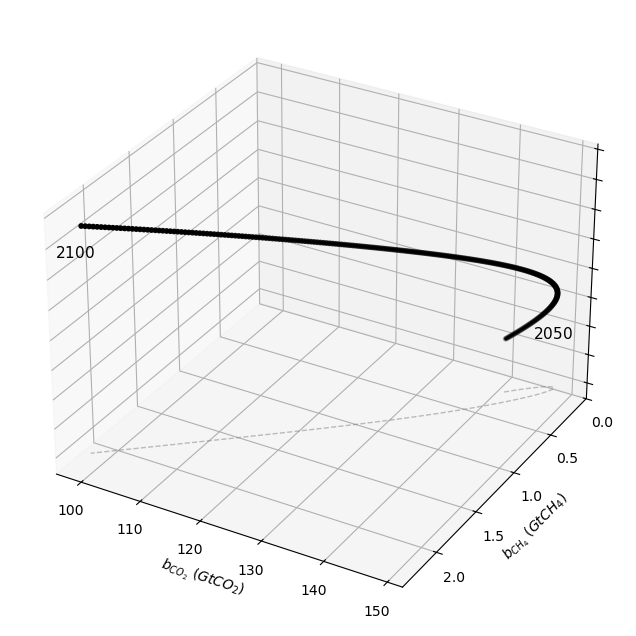

eta1


C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:152: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl_J  = UnivariateSpline(t_grid, minima_J,  s=smoothness_parameter)
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])


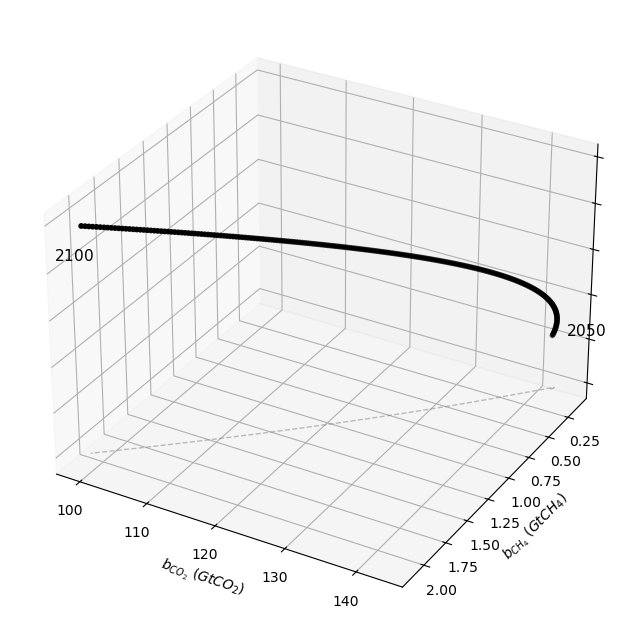

eta2
Case of 41.0 and eta2
Case of 71.0 and eta2


C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:152: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl_J  = UnivariateSpline(t_grid, minima_J,  s=smoothness_parameter)
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])


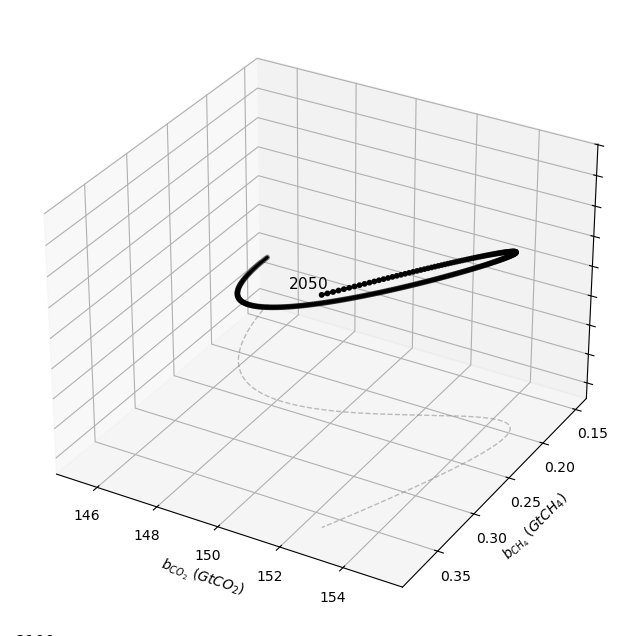

eta3


C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:152: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl_J  = UnivariateSpline(t_grid, minima_J,  s=smoothness_parameter)
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\1206475233.py:254: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])


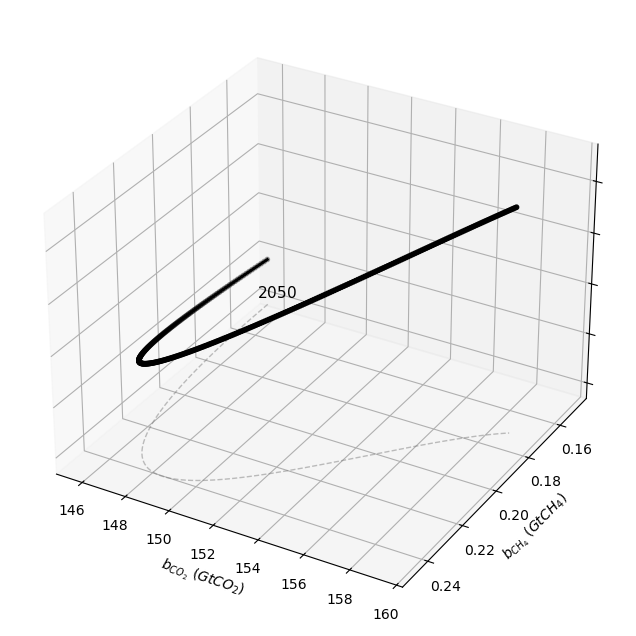

In [11]:
# ================================================================
# 3D line construction from constrained optima
# ---------------------------------------------------------------
# - Reads constrained/unconstrained results for different (η,h) sets
# - Extracts the minimum social cost point for each  \tilde{T}
# - Smooths these minima with splines
# - Produces 3D plots of the smoothed optimal path in (b0, b1, J)
# ================================================================

cubic = "No"                 # "No" = UnivariateSpline, "yes" = CubicSpline
smoothness_parameter = 100   # Smoothing penalty for UnivariateSpline
rid = 200                    # Number of points to discard from the *right* tail after smoothing

# ------------------------------------------------
# Helper: find minimum of social cost for given grid
# ------------------------------------------------
def plot_minima(b_vals, J_vals, z_offset=0.0):
    """
    Given b_vals = (b_0, b_1) points and corresponding J_vals,
    return the point (b_0*, b_1*, J_min + z_offset) where J is minimal.
    """
    J_vals = np.array(J_vals).flatten()
    min_index = np.argmin(J_vals)

    min_b0 = b_vals[min_index, 0]
    min_b1 = b_vals[min_index, 1]
    min_J  = J_vals[min_index] + z_offset

    return (min_b0, min_b1, min_J)


# ================================================================
# Settings for reading files and constructing lines
# ================================================================

Temp_Const = 0.3          # Temperature constraint used in file names
postfix    = "_TT"        # Extra tag used in file names
len_Tilde  = 15           # Step length in \tilde{T}

etahs = ["eta0", "eta1", "eta2", "eta3"]

# Horizons:  \tilde{T} = 26, 41, 56, ..., 101  (depending on len_Tilde)
T_tilde = np.arange(26, 105, len_Tilde).astype(float)

# Dictionaries of DataFrames keyed by "<Temp_Const>_<T_tilde>"
J_results_Unconstrained = {}
J_results_Constrained   = {}

# Will hold the smoothed minima sequences for each η-set:
# lines_3D_plot[etah] = [list_b0, list_b1, list_J]
lines_3D_plot = {}


# ================================================================
# Main loop over the different (η,h) configurations
# ================================================================
for etah in etahs:
    print(etah)

    # ------------------------------------------------------------
    # 1. Load all result files for this η-set
    # ------------------------------------------------------------
    for name in T_tilde:
        unconstrained_file_xlsx = REPO_ROOT / "Optimization Results (Unconstrained)" / f'Unconstrained_results_{Temp_Const}_{name}_50_{etah}{postfix}.xlsx'
        constrained_file_xlsx   = REPO_ROOT / "Optimization Results (Constrained)"   / f'Constrained_results_{Temp_Const}_{name}_50_{etah}{postfix}.xlsx'

        if os.path.exists(unconstrained_file_xlsx):
            J_results_Unconstrained[f'{Temp_Const}_{name}'] = pd.read_excel(unconstrained_file_xlsx)

        if os.path.exists(constrained_file_xlsx):
            J_results_Constrained[f'{Temp_Const}_{name}'] = pd.read_excel(constrained_file_xlsx)

    # ------------------------------------------------------------
    # 2. Initialise 3D figure for this η-set
    # ------------------------------------------------------------
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # (Kept for completeness; currently we do not colour-code minima by horizon)
    colors = [to_hex(c) for c in plt.cm.Reds(np.linspace(0, 1, len_Tilde))]
    color_index = 0  # Unused in the final plotting, but harmless

    # Lists to store minima across all horizons
    minima_b0 = []
    minima_b1 = []
    minima_J  = []

    # ------------------------------------------------------------
    # 3. Extract minima for each constrained problem at each \tilde{T}
    # ------------------------------------------------------------
    for name in T_tilde:
        key = f'{Temp_Const}_{name}'

        if key in J_results_Constrained:
            # Special ad-hoc averaging for specific problematic (T̃, η) combinations
            if ((name == 41.0 and etah == "eta0")
                or (name == 41.0 and etah == "eta2")
                or (name == 71.0 and etah == "eta2")):

                print(f"Case of {name} and {etah}")

                name_m = name - len_Tilde
                name_p = name + len_Tilde

                data_m = J_results_Constrained[f'{Temp_Const}_{name_m}']
                data_p = J_results_Constrained[f'{Temp_Const}_{name_p}']

                b_vals_m = np.column_stack((data_m['b_0'], data_m['b_1']))
                b_vals_p = np.column_stack((data_p['b_0'], data_p['b_1']))

                J_vals_m = data_m['Constrained social cost']
                J_vals_p = data_p['Constrained social cost']

                min_point_m = plot_minima(b_vals_m, J_vals_m)
                min_point_p = plot_minima(b_vals_p, J_vals_p)

                # Average of neighbouring minima
                min_point = (
                    (min_point_m[0] + min_point_p[0]) / 2,
                    (min_point_m[1] + min_point_p[1]) / 2,
                    (min_point_m[2] + min_point_p[2]) / 2,
                )

            else:
                # Regular case: take the minimum of this constrained grid
                data   = J_results_Constrained[key]
                b_vals = np.column_stack((data['b_0'], data['b_1']))
                J_vals = data['Constrained social cost']

                min_point = plot_minima(b_vals, J_vals)

            # Collect minima
            minima_b0.append(min_point[0])
            minima_b1.append(min_point[1])
            minima_J.append(min_point[2])

            # (Kept for possible future colour usage)
            color_index = (color_index + 1) % len(colors)

    # Store raw minima (before smoothing) for this η-set
    lines_3D_plot[etah] = [minima_b0, minima_b1, minima_J]

    # ============================================================
    # 4. Smooth the minima path in t = 0,...,n-1
    # ============================================================
    t_grid = np.arange(len(minima_b0))

    if cubic == "No":
        # Univariate smoothing splines
        spl_b0 = UnivariateSpline(t_grid, minima_b0, s=smoothness_parameter)
        spl_b1 = UnivariateSpline(t_grid, minima_b1, s=smoothness_parameter)
        spl_J  = UnivariateSpline(t_grid, minima_J,  s=smoothness_parameter)

    elif cubic == "yes":
        # Pure cubic splines (no smoothing penalty)
        spl_b0 = CubicSpline(t_grid, minima_b0)
        spl_b1 = CubicSpline(t_grid, minima_b1)
        spl_J  = CubicSpline(t_grid, minima_J)

    # Fine parameter grid for smooth plotting (500 points)
    fine_t   = np.linspace(0, len(minima_b0) - 1, 500)
    smooth_b0 = spl_b0(fine_t)
    smooth_b1 = spl_b1(fine_t)
    smooth_J  = spl_J(fine_t)

    # Vertical shift so that the CH4-axis stays positive and not too close to 0
    shift_value = (-np.min(smooth_b1)) + 0.15

    # ------------------------------------------------------------
    # Compute label for final year, based on how many points we drop
    # ------------------------------------------------------------
    years_analysis = [2024 + year for year in range(26, 106, 5)]
    num_points     = len(years_analysis)
    translation    = 500 / num_points        # mapping from index to "year index"
    points_omitted = math.floor(rid / translation)
    final_year     = years_analysis[-points_omitted]

    # Discard last `rid` points after smoothing to shorten the curve
    if rid != 0:
        smooth_b0 = smooth_b0[:-rid]
        smooth_b1 = smooth_b1[:-rid]
        smooth_J  = smooth_J[:-rid]

    # ============================================================
    # 5. Plot smoothed 3D line + markers + shadow
    # ============================================================
    # Main smooth path
    ax.plot(
        smooth_b0,
        smooth_b1 + shift_value,
        smooth_J  + shift_value,
        color='black',
        linestyle='-',
        linewidth=2,
    )

    # Small black markers along the path (to show discrete sampling)
    ax.scatter(
        smooth_b0,
        smooth_b1 + shift_value,
        smooth_J  + shift_value,
        color='black',
        s=10,
    )

    # Shadow of the line on the (b_0, b_1) plane (z = 0)
    ax.plot(
        smooth_b0,
        smooth_b1 + shift_value,
        np.zeros_like(smooth_J),
        color='grey',
        linestyle='--',
        linewidth=1,
        alpha=0.5,
    )

    # ------------------------------------------------------------
    # Annotate first and last points of the (unsmoothed) minima
    # ------------------------------------------------------------
    # First minimum (labelled 2050)
    ax.text(
        minima_b0[0] + 2,
        minima_b1[0] + shift_value,
        minima_J[0]  + shift_value,
        "$2050$",
        color='black',
        fontsize=11,
    )

    # Last (smoothed) point labelled with inferred final year
    ax.text(
        smooth_b0[-1] + 2,
        smooth_b1[-1] + 0.4 + shift_value,
        smooth_J[-1]  + shift_value,
        f"${final_year}$",
        color='black',
        fontsize=11,
    )

    # ------------------------------------------------------------
    # Axes labels / styling
    # ------------------------------------------------------------
    ax.set_xlabel(r'$b_{CO_2}\; (GtCO_2)$')
    ax.set_ylabel(r'$b_{CH_4}\; (GtCH_4)$')
    ax.set_zlabel('Social cost')

    # Hide z tick labels (we only care about relative height)
    ax.set_zticklabels([])

    # Invert b_1 axis to match paper convention
    ax.invert_yaxis()

    # Save & show figure
    plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])
    plt.savefig(
        f'3DPlotsLine_{etah}_{len_Tilde}{postfix}_smooth.png',
        facecolor="w",
        bbox_inches='tight',
        dpi=300,
    )
    plt.show()


Processing eta0 ...
  Special averaging case for T̃=41.0, eta0
  Special averaging case for T̃=51.0, eta0
Processing eta1 ...
  Special averaging case for T̃=41.0, eta1
Processing eta2 ...
  Special averaging case for T̃=31.0, eta2
  Special averaging case for T̃=61.0, eta2
Processing eta3 ...
  Special averaging case for T̃=61.0, eta3
Points omitted at the end: 6
Points omitted at the end: 6
Points omitted at the end: 6


C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\80704710.py:144: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl_z = UnivariateSpline(np.arange(len(z)), z, s=smoothness_parameter)
C:\Users\SALEHZAD\AppData\Local\Temp\ipykernel_6008\80704710.py:144: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl_z = UnivariateSpline(np.arange(len(z)), z, s=smoothness_parameter)


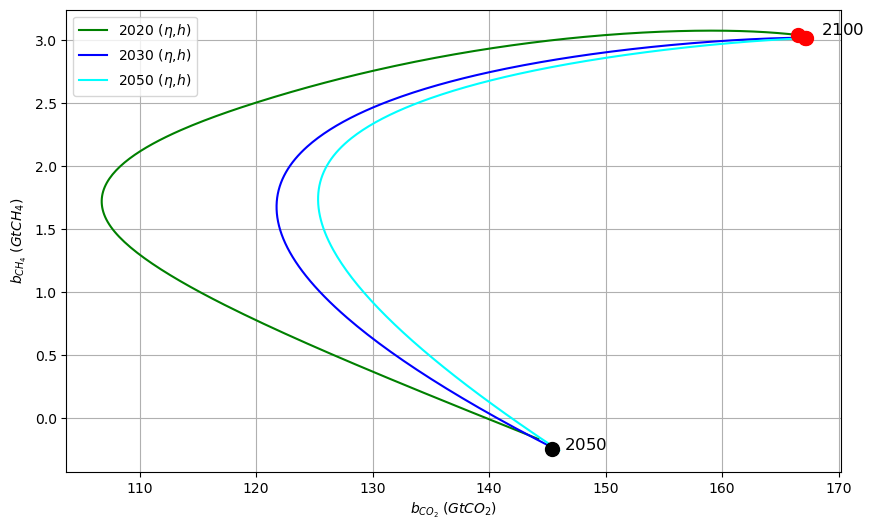

In [12]:
# ================================================================
# 1. Build lines_3D_plot from constrained optimisation results
#    (only data, no plots)
# ================================================================

Temp_Const = 0.3          # Temperature constraint that appears in filenames
postfix    = ""           # Suffix in filenames ("" or "_TT", etc.)
len_Tilde  = 5            # Step size for \tilde{T} in years

# Different (η, h) configurations
etahs = ["eta0", "eta1", "eta2", "eta3"]

# Horizons: \tilde{T} = 26, 31, 36, ..., 101
T_tilde = np.arange(26, 105, len_Tilde).astype(float)

# Storage for loaded results (not strictly needed for plotting but kept)
J_results_Unconstrained = {}
J_results_Constrained   = {}

# This is what will be used later by the 2D plot code:
# lines_3D_plot[etah] = [list_b0, list_b1, list_J]
lines_3D_plot = {}


def plot_minima(b_vals, J_vals, z_offset=0.0):
    """
    Given a grid of (b_0, b_1) and corresponding social costs J_vals,
    return the minimum point (b_0*, b_1*, J_min + z_offset).
    """
    J_vals = np.array(J_vals).flatten()
    min_index = np.argmin(J_vals)
    return (b_vals[min_index, 0],
            b_vals[min_index, 1],
            J_vals[min_index] + z_offset)


for etah in etahs:
    print(f"Processing {etah} ...")

    # ------------------------------------------------------------
    # 1.a Load Excel files for this η-set
    # ------------------------------------------------------------
    for name in T_tilde:
        unconstrained_file_xlsx = REPO_ROOT / "Optimization Results (Unconstrained)" /f'Unconstrained_results_{Temp_Const}_{name}_50_{etah}{postfix}.xlsx'
        constrained_file_xlsx   = REPO_ROOT / "Optimization Results (Constrained)" /f'Constrained_results_{Temp_Const}_{name}_50_{etah}{postfix}.xlsx'

        if os.path.exists(unconstrained_file_xlsx):
            J_results_Unconstrained[f'{Temp_Const}_{name}'] = pd.read_excel(unconstrained_file_xlsx)

        if os.path.exists(constrained_file_xlsx):
            J_results_Constrained[f'{Temp_Const}_{name}'] = pd.read_excel(constrained_file_xlsx)

    # ------------------------------------------------------------
    # 1.b Extract minima (b_0, b_1, J) for each \tilde{T}
    #     + special averaging cases you specified
    # ------------------------------------------------------------
    minima_b0 = []
    minima_b1 = []
    minima_J  = []

    for name in T_tilde:
        key = f'{Temp_Const}_{name}'
        if key not in J_results_Constrained:
            continue

        # Special manual-smoothing cases
        special_case = (
            (name == 41.0 and etah == "eta0")
            or (name == 51.0 and etah == "eta0")
            or (name == 41.0 and etah == "eta1")
            or (name == 31.0 and etah == "eta2")
            or (name == 61.0 and etah == "eta2")
            or (name == 61.0 and etah == "eta3")
        )

        if special_case:
            print(f"  Special averaging case for T̃={name}, {etah}")

            name_m = name - len_Tilde
            name_p = name + len_Tilde

            data_m = J_results_Constrained[f'{Temp_Const}_{name_m}']
            data_p = J_results_Constrained[f'{Temp_Const}_{name_p}']

            b_vals_m = np.column_stack((data_m['b_0'], data_m['b_1']))
            b_vals_p = np.column_stack((data_p['b_0'], data_p['b_1']))

            J_vals_m = data_m['Constrained social cost']
            J_vals_p = data_p['Constrained social cost']

            min_point_m = plot_minima(b_vals_m, J_vals_m)
            min_point_p = plot_minima(b_vals_p, J_vals_p)

            # Average of neighbours
            min_point = (
                (min_point_m[0] + min_point_p[0]) / 2.0,
                (min_point_m[1] + min_point_p[1]) / 2.0,
                (min_point_m[2] + min_point_p[2]) / 2.0,
            )

        else:
            data   = J_results_Constrained[key]
            b_vals = np.column_stack((data['b_0'], data['b_1']))
            J_vals = data['Constrained social cost']
            min_point = plot_minima(b_vals, J_vals)

        minima_b0.append(min_point[0])
        minima_b1.append(min_point[1])
        minima_J.append(min_point[2])

    # Store the sequence of minima for this η-set
    lines_3D_plot[etah] = [minima_b0, minima_b1, minima_J]


# ================================================================
# 2. Use lines_3D_plot to produce the 2D smoothed curve
#    (b_CO2 vs b_CH4) with common start and coloured end points
# ================================================================

rid       = 200   # Number of points to remove from the *end* of the smoothed curve
rid_front = 4     # Number of first points to remove for one of the lines (eta3)


def smooth_curve(x, y, z, smoothness_parameter=100):
    """
    Take discrete points (x, y, z) along a curve (indexed by t = 0,...,n-1),
    fit UnivariateSplines, evaluate them on a fine grid, and truncate the
    last `rid` points. Also compute the final year label after truncation.
    """
    # Fine parameter grid for smoothing
    fine_t = np.linspace(0, len(x) - 1, 500)

    # Years corresponding to each optimisation horizon (used for the final label)
    years_analysis = [2024 + year for year in range(26, 106, 5)]
    num_points     = len(years_analysis)
    translation    = 500 / num_points
    points_omitted = math.floor(rid / translation)
    print("Points omitted at the end:", points_omitted)
    final_year = years_analysis[-points_omitted]

    # Fit smoothing splines
    spl_x = UnivariateSpline(np.arange(len(x)), x, s=smoothness_parameter)
    spl_y = UnivariateSpline(np.arange(len(y)), y, s=smoothness_parameter)
    spl_z = UnivariateSpline(np.arange(len(z)), z, s=smoothness_parameter)

    # Evaluate on fine grid and truncate tail
    if rid != 0:
        smooth_x = spl_x(fine_t)[:-rid]
        smooth_y = spl_y(fine_t)[:-rid]
        smooth_z = spl_z(fine_t)[:-rid]
    else:
        smooth_x = spl_x(fine_t)
        smooth_y = spl_y(fine_t)
        smooth_z = spl_z(fine_t)

    return smooth_x, smooth_y, smooth_z, final_year


# ------------------------------------------------
# 2D figure
# ------------------------------------------------
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)

colors_MAC = ['red', 'green', 'blue', 'cyan']
Years_MAC  = [2015, 2020, 2030, 2050]
counter    = 1

# Universal start point (same for all lines): first point of first η
first_key = list(lines_3D_plot.keys())[0]
start_x = lines_3D_plot[first_key][0][0]  # b_CO2
start_y = lines_3D_plot[first_key][1][0]  # b_CH4

smooth_x = {}
smooth_y = {}
final_year_dict = {}

# Build smoothed 2D curves for each η (except eta0 if you wish)
for key in lines_3D_plot.keys():
    # CHANGE IF NEEDED: skip "eta0" from the overlay
    if key != "eta0":
        x_vals, y_vals, z_vals = lines_3D_plot[key]

        smooth_x[key], smooth_y[key], smooth_z, final_year = smooth_curve(
            x_vals, y_vals, z_vals, smoothness_parameter=100
        )
        final_year_dict[key] = final_year

        # Plot the smoothed 2D line
        if key == "eta3":
            # For eta3, trim a few points at the front to align visually
            ax1.plot(
                smooth_x[key][rid_front:],
                smooth_y[key][rid_front:],
                color=colors_MAC[counter],
                linestyle='-',
                label=f"{Years_MAC[counter]} ($\\eta$,$h$)",
            )
        else:
            ax1.plot(
                smooth_x[key],
                smooth_y[key],
                color=colors_MAC[counter],
                linestyle='-',
                label=f"{Years_MAC[counter]} ($\\eta$,$h$)",
            )

        counter += 1

# Universal starting point (corresponding roughly to \tilde{T}=26 / year 2050)
ax1.scatter(start_x + 1, start_y - 0.25, color='black', s=100, zorder=10)
ax1.text(start_x + 2, start_y - 0.25, "$2050$", fontsize=12, color='black')

# End points for each line, with final year label on the first one
end_x = {}
end_y = {}

for key in smooth_x.keys():
    end_x[key] = smooth_x[key][-1]
    end_y[key] = smooth_y[key][-1]

first_key = list(end_x.keys())[0]
for key in end_x.keys():
    ax1.scatter(end_x[key], end_y[key], color='red', s=100, zorder=10)
    if key == first_key:
        ax1.text(
            end_x[key] + 2,
            end_y[key],
            f"${final_year_dict[key]}$",
            fontsize=12,
            color='black',
        )

# Axes / styling
ax1.set_xlabel(r'$b_{CO_2}\; (GtCO_2)$')
ax1.set_ylabel(r'$b_{CH_4}\; (GtCH_4)$')
ax1.legend()
ax1.grid(True)

plt.savefig(f'2DLinePlots_{len_Tilde}{postfix}_smooth.png',
            facecolor='w', bbox_inches='tight', dpi=300)
plt.show()